In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting

import glob
from tqdm import tqdm  # progress bar

# Step 1

In [3]:
EC_AD = finder.Barcode(name = "AD",
                        preceder = "GGCTAGC",
                       post = "",
                       length = 120)

EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "",
                       length = 11)

EC_RPTR_BC = finder.Barcode(name = "RPTR_BC",
                       preceder = "CTCGAG",
                       post = "",
                       length = 14)


In [4]:
step1_mapper = initial_map.InitialMapper(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
                                       step_name = "step1", #Should include time point, replicate (don't need to specify BC type(s))
                                       seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2024/A10_A11/results/A10_S1.fastq.gz.assembled.fastq",
                                       design_file_path =  "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                       bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                                       reverse_complement = True)

In [5]:
# step1_mapper.create_map()

In [6]:
step1_mapper.preview_map()

step1_AD_AD_BC_RPTR_BC_initial
Total rows: 138671404


AD  AD_qual        AD_BC  \
0  TCTTCTTCTCCATCTCCACCATCTTCTTTGCCATCTCCATCTTCTA...     True                
1  TCTACTCAATCTACTTGGCCACCATCTTCTTCTTCTTCTCAACCAG...     True  CAATGCCTACT   
2  CCAGTTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTAGGAAAT...     True  AGAAGTTACGC   
3  TCTCCATCTGACTTTACTCCACCACCAACTGTTACTATCTTGCCAC...     True                
4  TCTTTGCCAGCTCAATCTCCACAAACTCAATATCAAGATCATTCTG...     True                

   AD_BC_qual         RPTR_BC  RPTR_BC_qual  Designed  
0       False  CAATTAGCTATAGC          True         1  
1        True  GTATCCGTACATGC          True         1  
2        True  ATAACACACAAACG          True         1  
3       False  GTAACAATGAAGGC          True         1  
4       False  CCTTTTCTATAAGT          True         1

Base prefix (stable across descriptors): step1_AD_AD_BC_RPTR_BC_
Full prefix for this instance: step1_AD_AD_BC_RPTR_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. grouped
5. thresholded
6. unique_target
7. designed

Removing rows with null or empty barcodes (excluding AD)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 28.04 seconds.


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: step1_AD_AD_BC_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 56.22 seconds.

Grouping step1_AD_AD_BC_RPTR_BC_quality...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

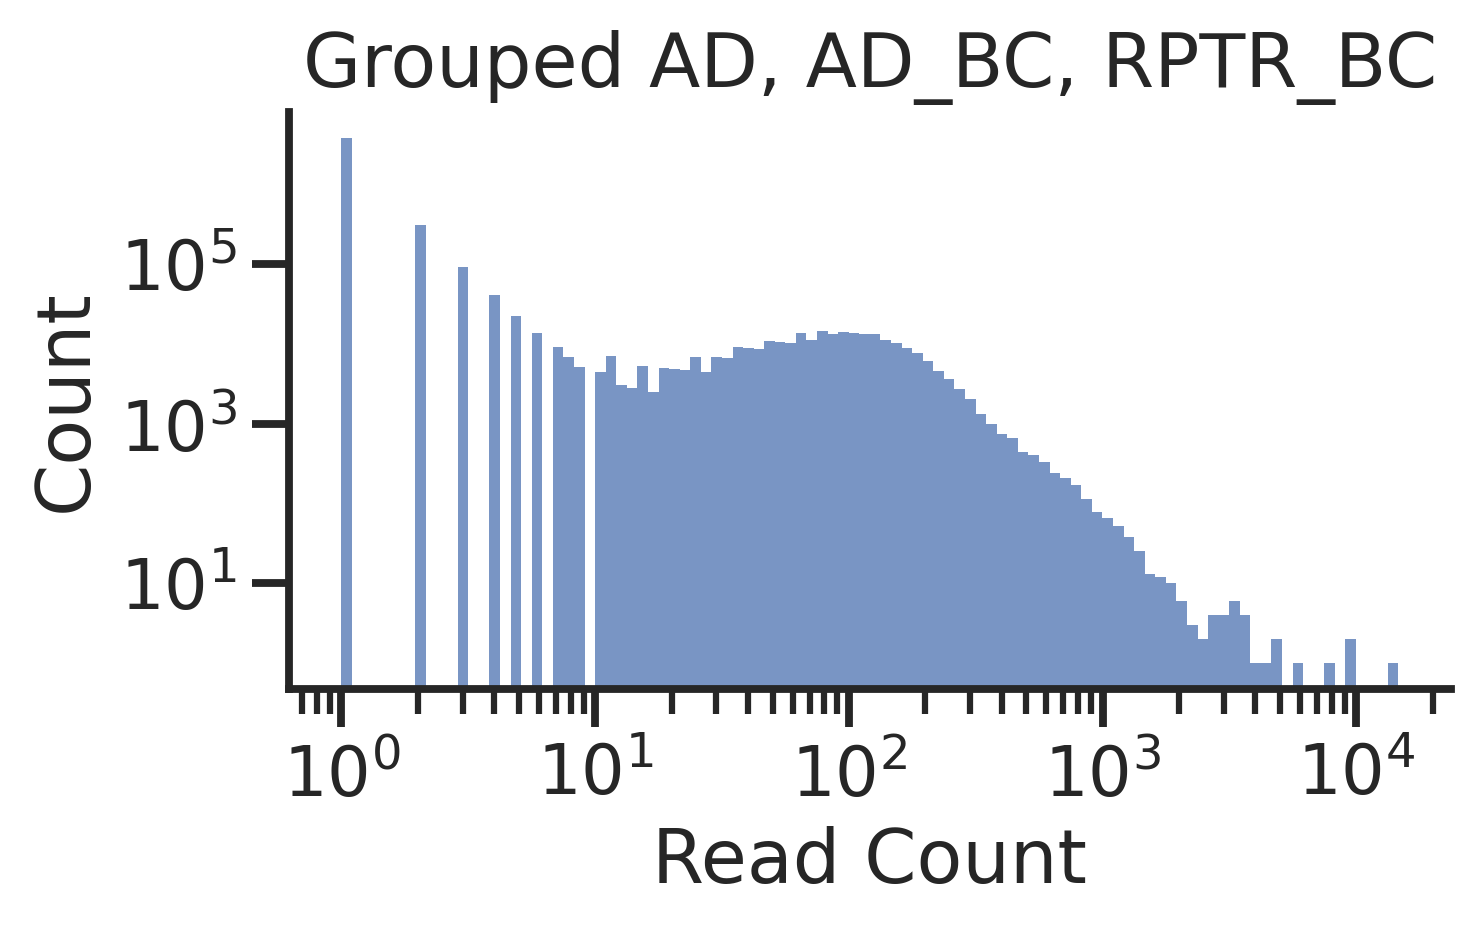

Done in 8.64 seconds.

Thresholding...
Using reads threshold of 50.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

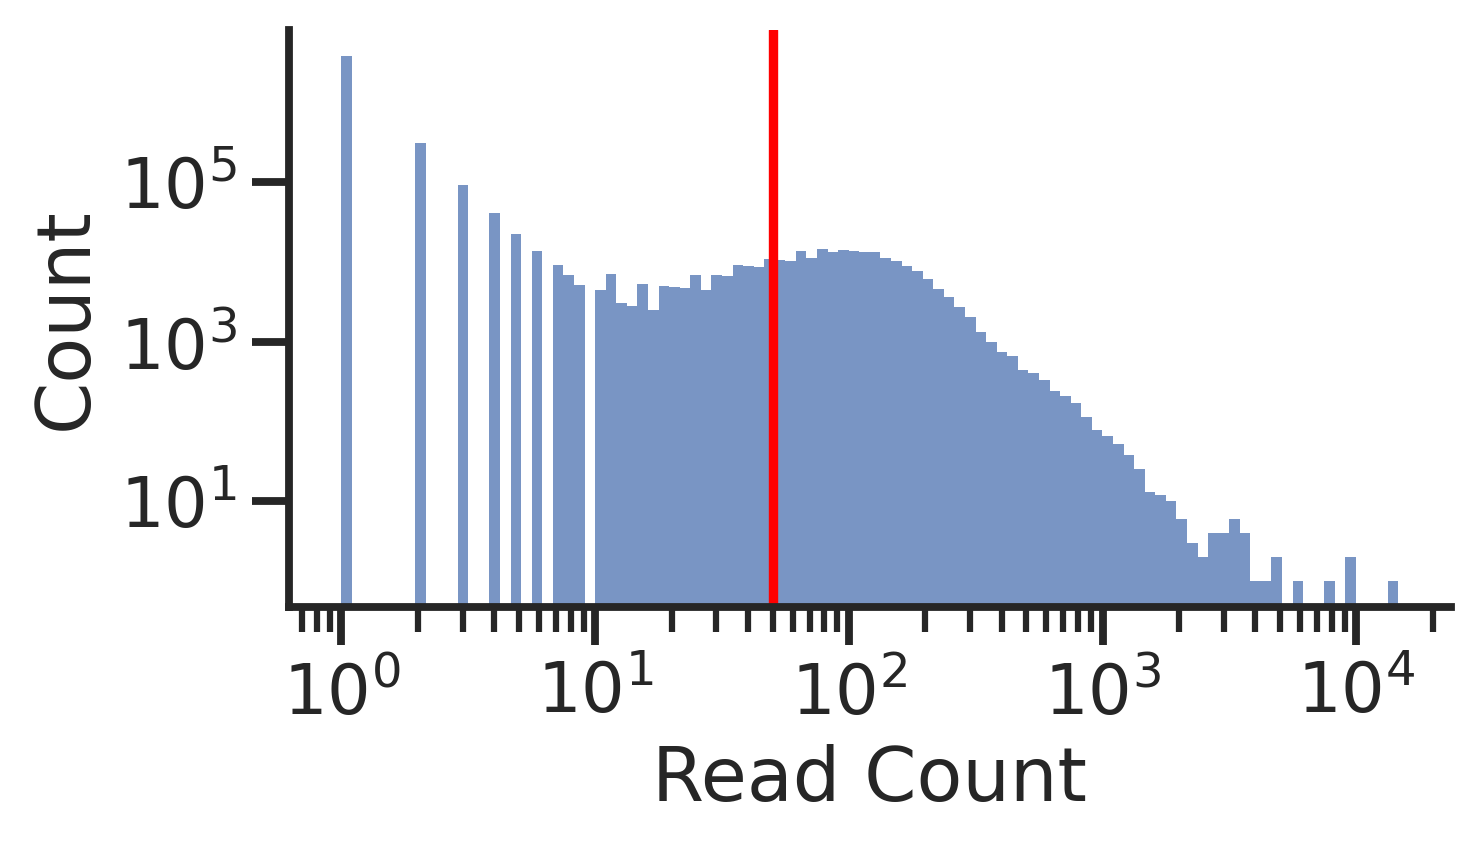

Done in 6.27 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: RPTR_BC → AD
Created filtered table: step1_AD_AD_BC_RPTR_BC_unique_target
Done in 0.62 seconds.


Filtering to designed sequences...
Created table: step1_AD_AD_BC_RPTR_BC_designed — kept only Designed == 1.
Done in 0.27 seconds.

Done.


In [7]:
refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
                                bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                                column_pairs = [( "RPTR_BC", "AD")],
                                design_check = True, 
                                reads_threshold = 50,
                                map_order = [
                                    "barcode_exists",
                                    "quality",
                                    "grouped",
                                    "thresholded",
                                    "unique_target",
                                    "designed"
                                ],                                
                                step_name = "step1",
                                should_check_exists = True,
                                plot_histograms = True,
                                output_figures_path="../../output/GCN4/figures/")
refiner.refine_map_from_db()

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_loss_summary'
Done in 3.41 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

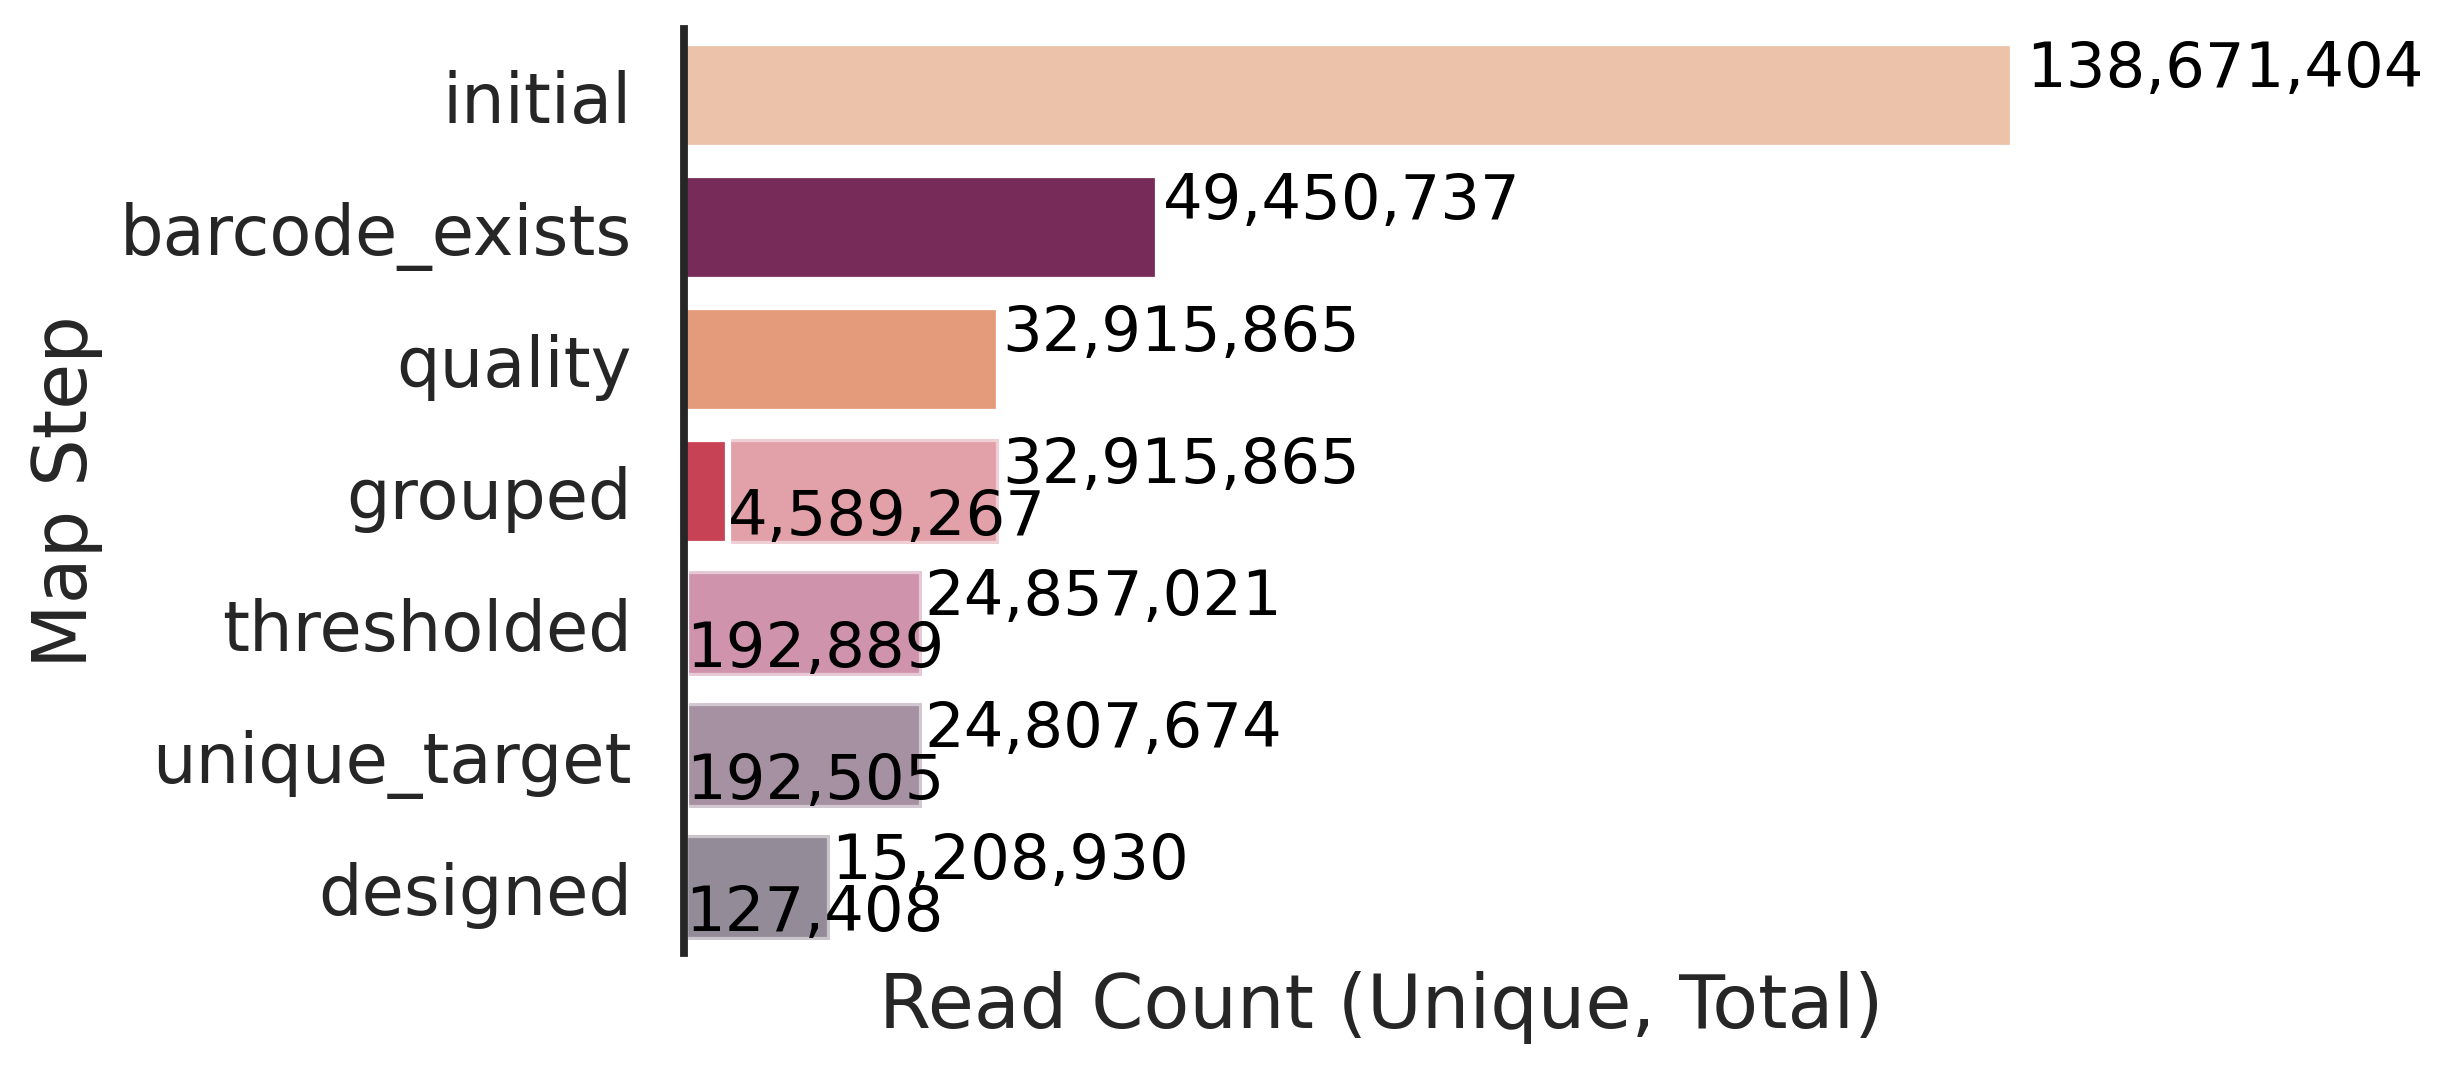

In [8]:
refiner.plot_loss(text_offset = -0.2)

# Step 2 Spike-in

## 1. AD + ADBC

In [9]:
AD_step2_paths = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/*AD*.assembled.fastq")
AD_step2_paths

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_AD_E1_MVS_0069_I1_AGCGAGCCAT_ACCGTAGATA_S6.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_AD_E1_MVS_0070_I1_TCCAGAACTC_ACGTGAGCGA_S7.fastq.gz.assembled.fastq']

In [10]:
step2_AD_mapper = initial_map.InitialMapper(
        db_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
        seq_file=AD_step2_paths,
        step_name="step2",
        bc_objects=[EC_AD, EC_AD_BC],
        reverse_complement=True
    )
step2_AD_mapper.create_map()

In [11]:
step2_AD_mapper.preview_map()

step2_AD_AD_BC_initial
Total rows: 528664


AD  AD_qual        AD_BC  \
0  TGGGGTTCATGCTGCTACTGCTGAACATCCAGCTATTAGAAGATTG...     True  TACACCCTTTG   
1  GGTGATAGATTGTCTAGAGCTTTGGGTTGGAGACCATGTTTGAGAT...     True  GCAGCTTCGTC   
2  TGTCCAATTTCTAATGAAATCTTGGGTTTGACTCCAGAATTGGTGG...     True  CTAGCTAGCCT   
3  ACTAATTTGCATGGTGTTAATGATATTGATCATACTCCAATGTTTG...     True  CCAGCACGTGC   
4  GATTTGAACTTTGGTCATCAATTGATTCATTTGGTTCTTCTTCTTT...     True  GATGTGGTGGT   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

In [12]:
# Refine ADBC map
step2_AD_ADBC_refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
                                                bc_objects=[EC_AD, EC_AD_BC],
                                                column_pairs = [],
                                                design_check = False,
                                                map_order = ['grouped', 'thresholded', 'quality'],
                                                step_name="step2",
                                                output_figures_path="../../output/GCN4/figures/",
                                                  should_check_exists = False)
step2_AD_ADBC_refiner.refine_map_from_db()

Base prefix (stable across descriptors): step2_AD_AD_BC_
Full prefix for this instance: step2_AD_AD_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. quality



Saved loss summary table as 'step2_AD_AD_BC_loss_summary'
Done in 0.50 seconds.



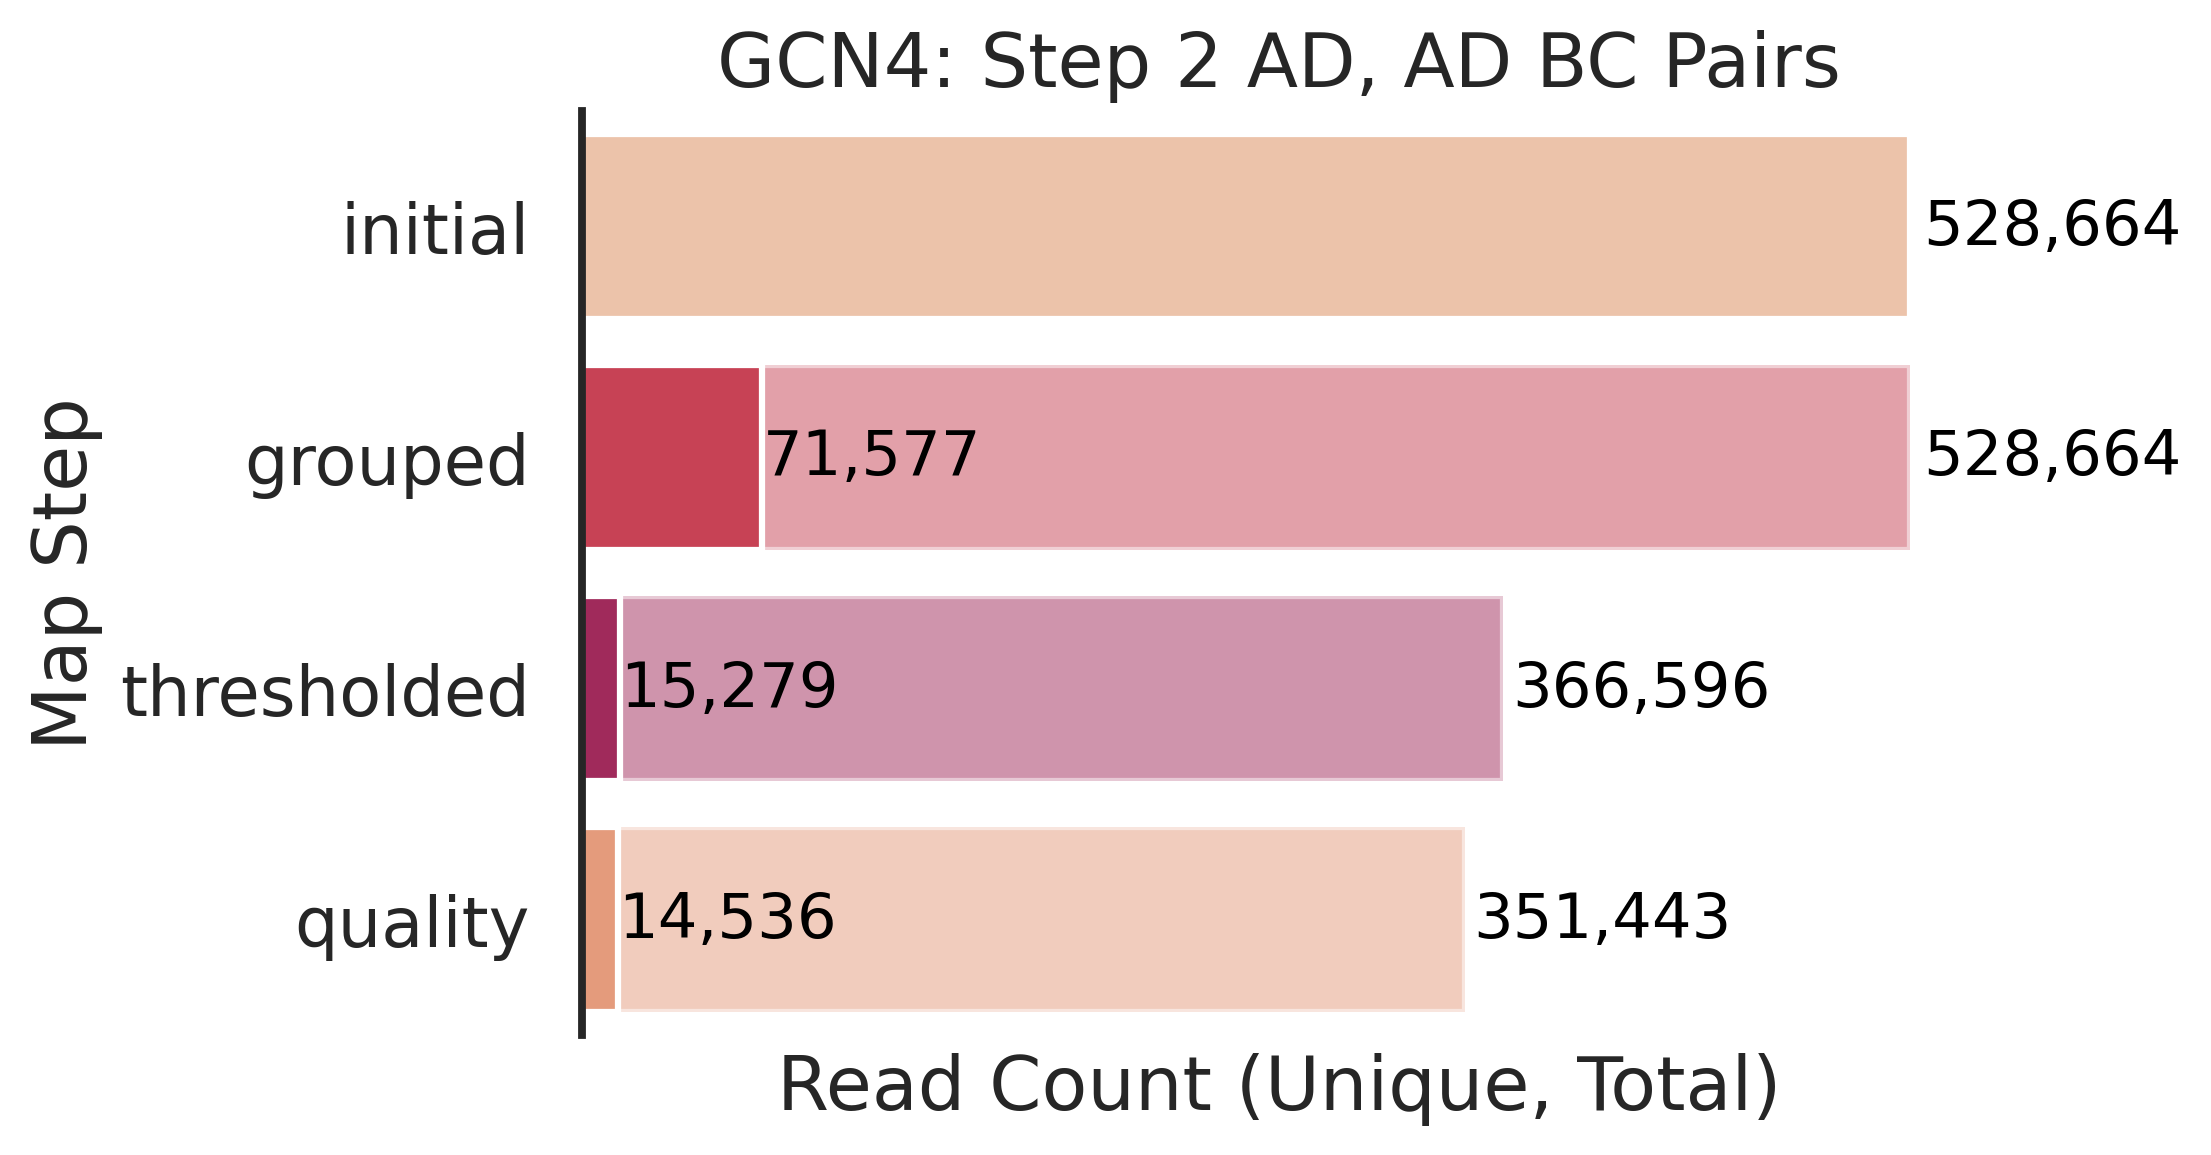

In [13]:
ax = step2_AD_ADBC_refiner.plot_loss()
plt.title("GCN4: Step 2 AD, AD BC Pairs")
plt.show()

## 2. RPTR BC

In [15]:
RPTR_step2_paths = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/*RPTR*.assembled.fastq")
RPTR_step2_paths

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E1_v1_MVS_0065_I1_CTATGGCGGA_CGGTAGAATT_S2.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E1_v2_MVS_0067_I1_GTCTTGTGCC_TCATGTAGGA_S4.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E3_v1_MVS_0066_I1_TGGCTGCTGA_GCCAGTCTGT_S3.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E3_v2_MVS_0068_I1_TCGAGGTTAA_CTCGCAGCAA_S5.fastq.gz.assembled.fastq']

In [16]:
step2_RPTR_mapper = initial_map.InitialMapper(
        db_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
        seq_file=RPTR_step2_paths,
        step_name="step2",
        bc_objects=[EC_RPTR_BC],
        reverse_complement=True
    )
step2_RPTR_mapper.create_map()

Reading 4 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 4.55 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 3.26 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.65 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 0.84 seconds.

Mapping complete.


In [17]:
step2_RPTR_mapper.preview_map()

step2_RPTR_BC_initial
Total rows: 1304387


RPTR_BC  RPTR_BC_qual  Designed
0  TGCTTATGCGCATC          True         1
1  TCTCCTCCCCTGCC          True         1
2  TGAGCGATATACGG          True         1
3  TATAATCTATGTAA          True         1
4  TTATCTGATGAAAG          True         1

In [18]:
# Refine RPTR map
step2_RPTR_refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
                                                bc_objects=[EC_RPTR_BC],
                                                column_pairs = [],
                                                design_check = False,
                                                map_order = ['grouped', 'thresholded', 'quality'],
                                                step_name="step2",
                                                output_figures_path="../../output/GCN4/figures/",
                                                  should_check_exists = False)
step2_RPTR_refiner.refine_map_from_db()


Base prefix (stable across descriptors): step2_RPTR_BC_
Full prefix for this instance: step2_RPTR_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. quality



Saved loss summary table as 'step2_RPTR_BC_loss_summary'
Done in 0.08 seconds.



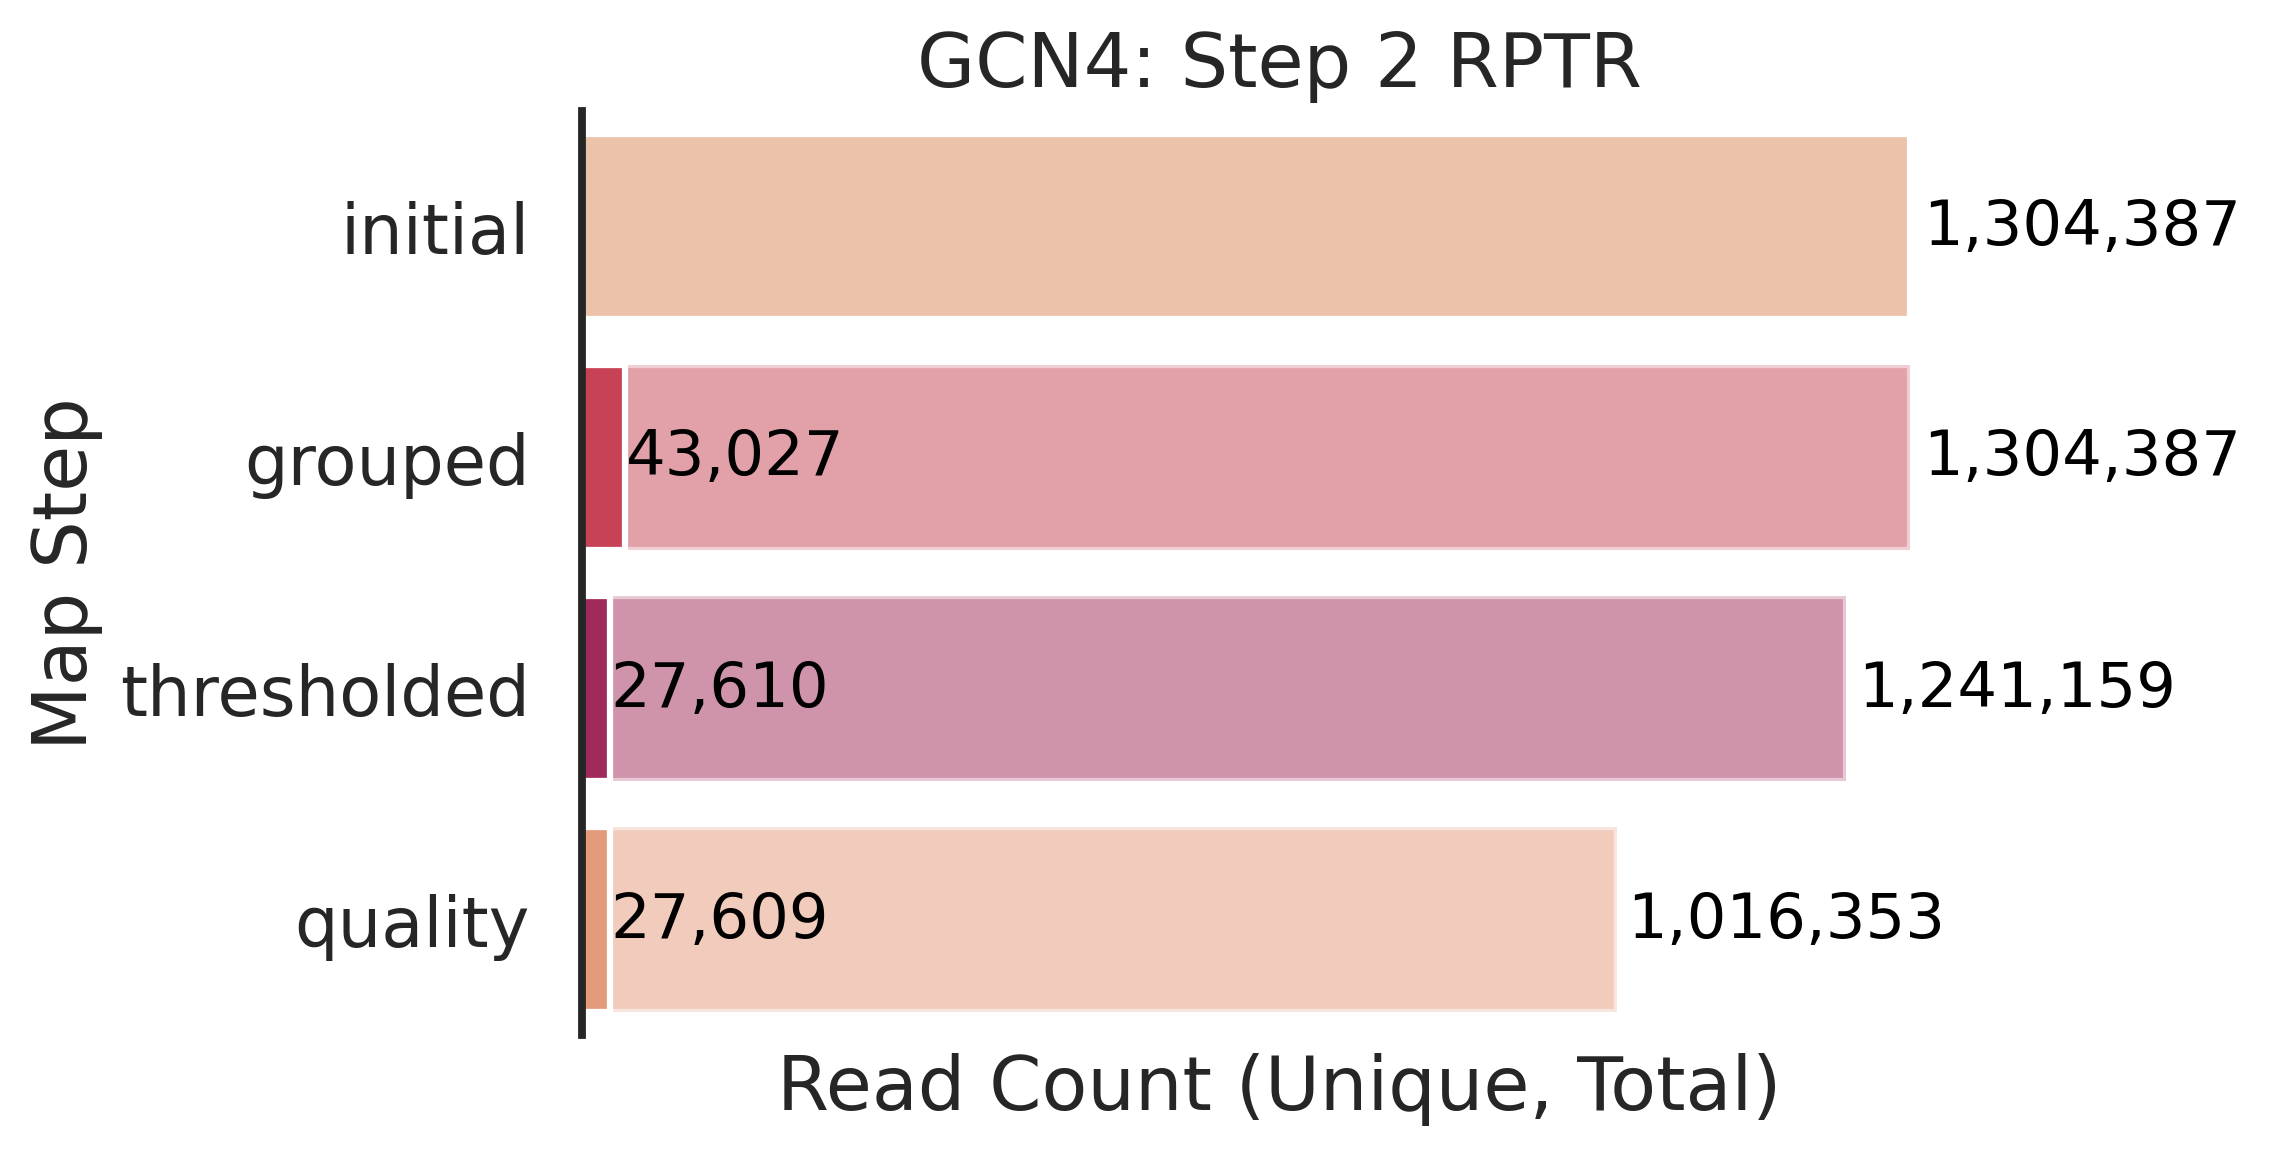

In [19]:
ax = step2_RPTR_refiner.plot_loss()
plt.title("GCN4: Step 2 RPTR")
plt.show()

In [20]:
complexity_checker = complexity.ComplexityChecker(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
                                                  step_name = "step2",
                                                  step1_map_name = "step1_AD_AD_BC_RPTR_BC_designed", 
                                                  step_suffix = "quality",
                                                  barcode_groups = [(EC_AD, EC_AD_BC), (EC_RPTR_BC)])
complexity_checker.count_overlap()

BC_type  map_unique  step2  seen_in_both  percent_of_map_seen
0  AD,AD_BC      127383  14536          4705                3.694
1   RPTR_BC      126943  27609          9735                7.669

# TREBL Experiments

## Yeast Pool A

### 1. AD + ADBC

In [21]:
yeast_pool_A_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/*")
yeast_pool_A_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/RPTR/*")
yeast_pool_A_output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A" # May need to change to your directory due to writing permissions

In [22]:
yeast_pool_A_AD_seq_files

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-10-1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-5-2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-240-1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-0-2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-240-1_67p

In [23]:
db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db"

Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22
Reading 1 FASTQ/TXT file(s)...
Done in 3.24 seconds.

Reverse complement of sequences...
Done in 1.62 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 4.10 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 3.38 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_initial
Total rows: 285659


AD  AD_qual        AD_BC  \
0  TCTTCTGCTCCACCATCTACTTCATTTACTGATATGTCTACTCCAT...     True  TTTCCGGCCCT   
1  TCTAATGTTGAACAATCTCCATTGTTGCCAGAAGAAGAATTGGAAG...     True  AACCAATGGAC   
2  AATCATACTGCTACTGAAGCTAGACAGAATGCTTTGAATCATAGAT...     True  TAGTTAGTTTC   
3  CCAATTGCATTTGATCCAAATGATCCAGTTGCTGCTAAGAGAGCTA...     True  ATGTGAATGAT   
4  TTGGATAATTATACTAGAAGGAAATCTTCTGTTACTAATTCTCCAG...     True  GGATAGATCAC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 2.12 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.24 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_designed...


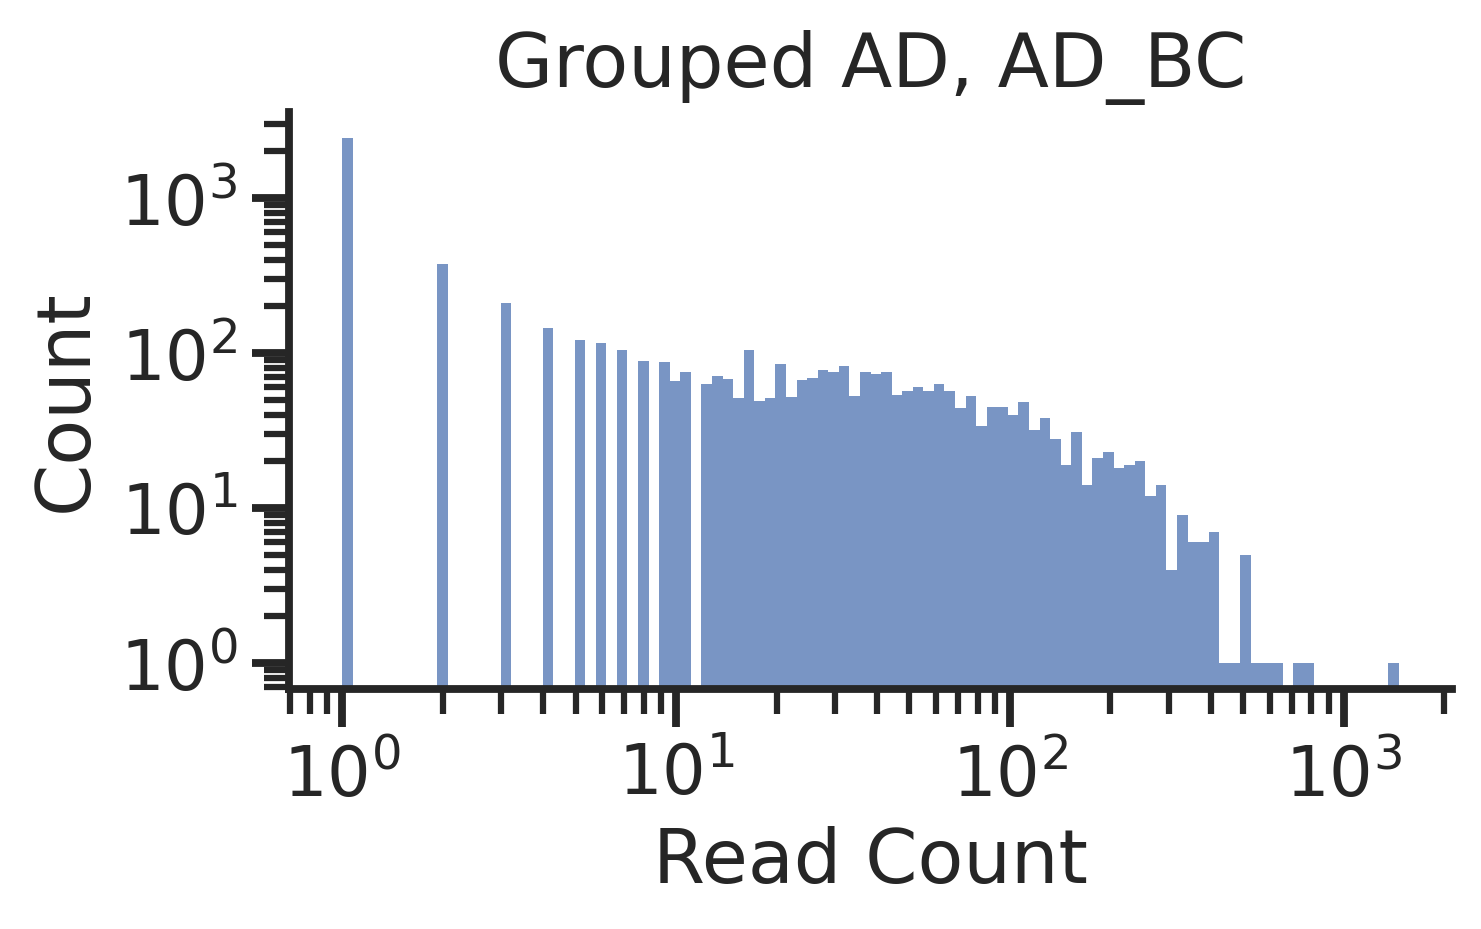

Done in 0.69 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  20


Using reads threshold of 20.


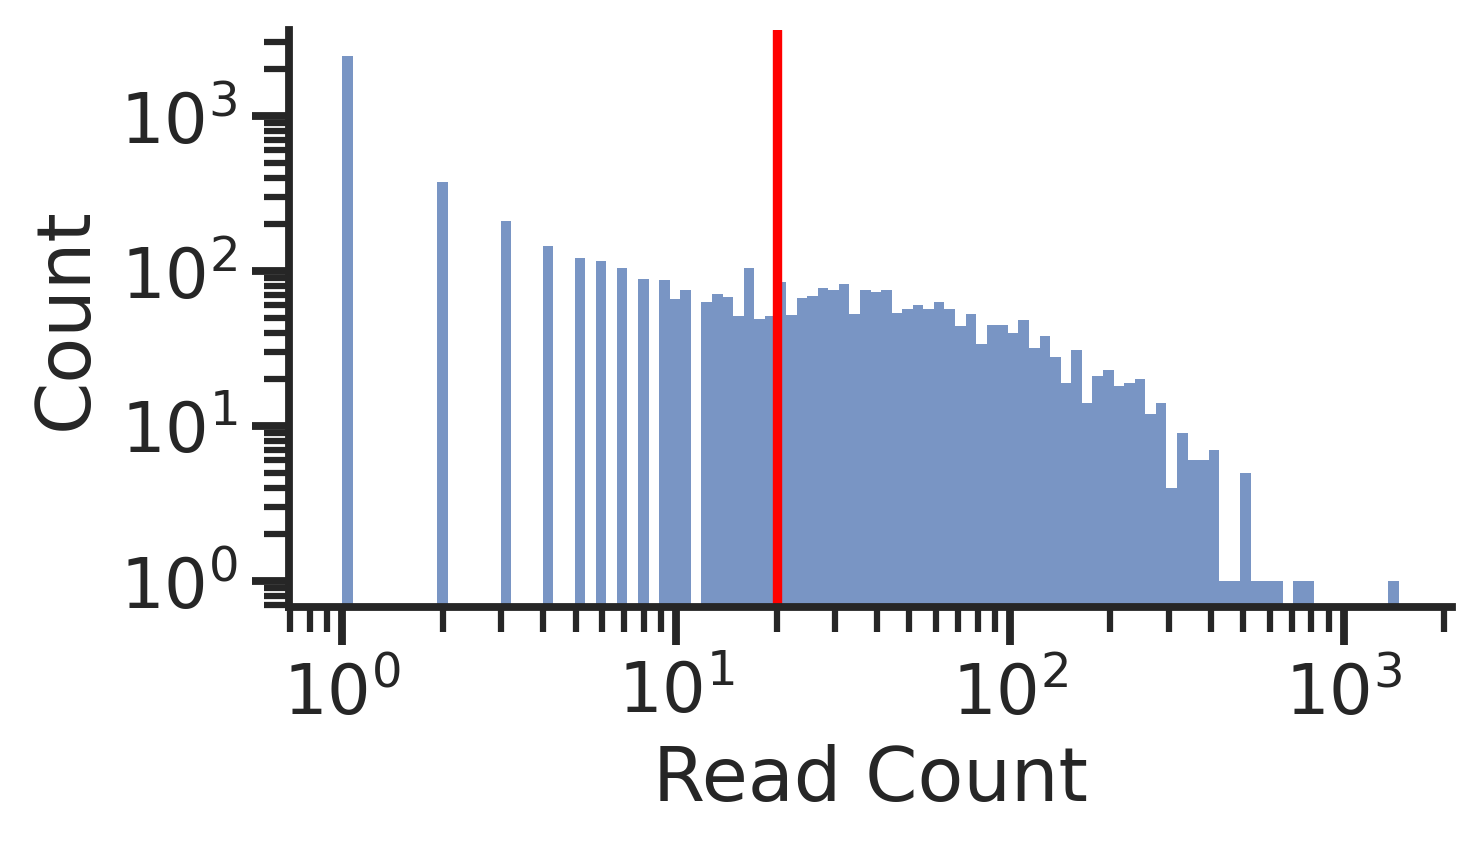

Done in 15.24 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_loss_summary'
Done in 0.09 seconds.

Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21
Reading 1 FASTQ/TXT file(s)...
Done in 0.75 seconds.

Reverse complement of sequences...
Done in 1.57 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 1.68 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 1.14 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_initial
Total rows: 247811


AD  AD_qual        AD_BC  \
0  GATTCTTTGTTTGAATCTCAAGATTTGTTTGCTTCTCCAGTTAAAC...     True  CTCCACTGCCC   
1  ATTCATCCATTGTTGTCTACTCAACCATTGTTCTCTGCTTTGCCAC...     True  ATATGAGGTTT   
2  TCTAGAGCTAGGAAATTGCAAAGAATGAAACAATTGGAAGATAAAG...     True  TCCGTTTCCGC   
3  CCATATAAGAGGAAATTGCCAACTTCTGATCATAGACATCCATTGG...     True  AGCGTATTACA   
4  ACTTCTTCTGGTTTGAGATCTGTTAGAGAAGTTTCTGAACCAGTTA...     True  AACAAACCTCT   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.49 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.21 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_designed...


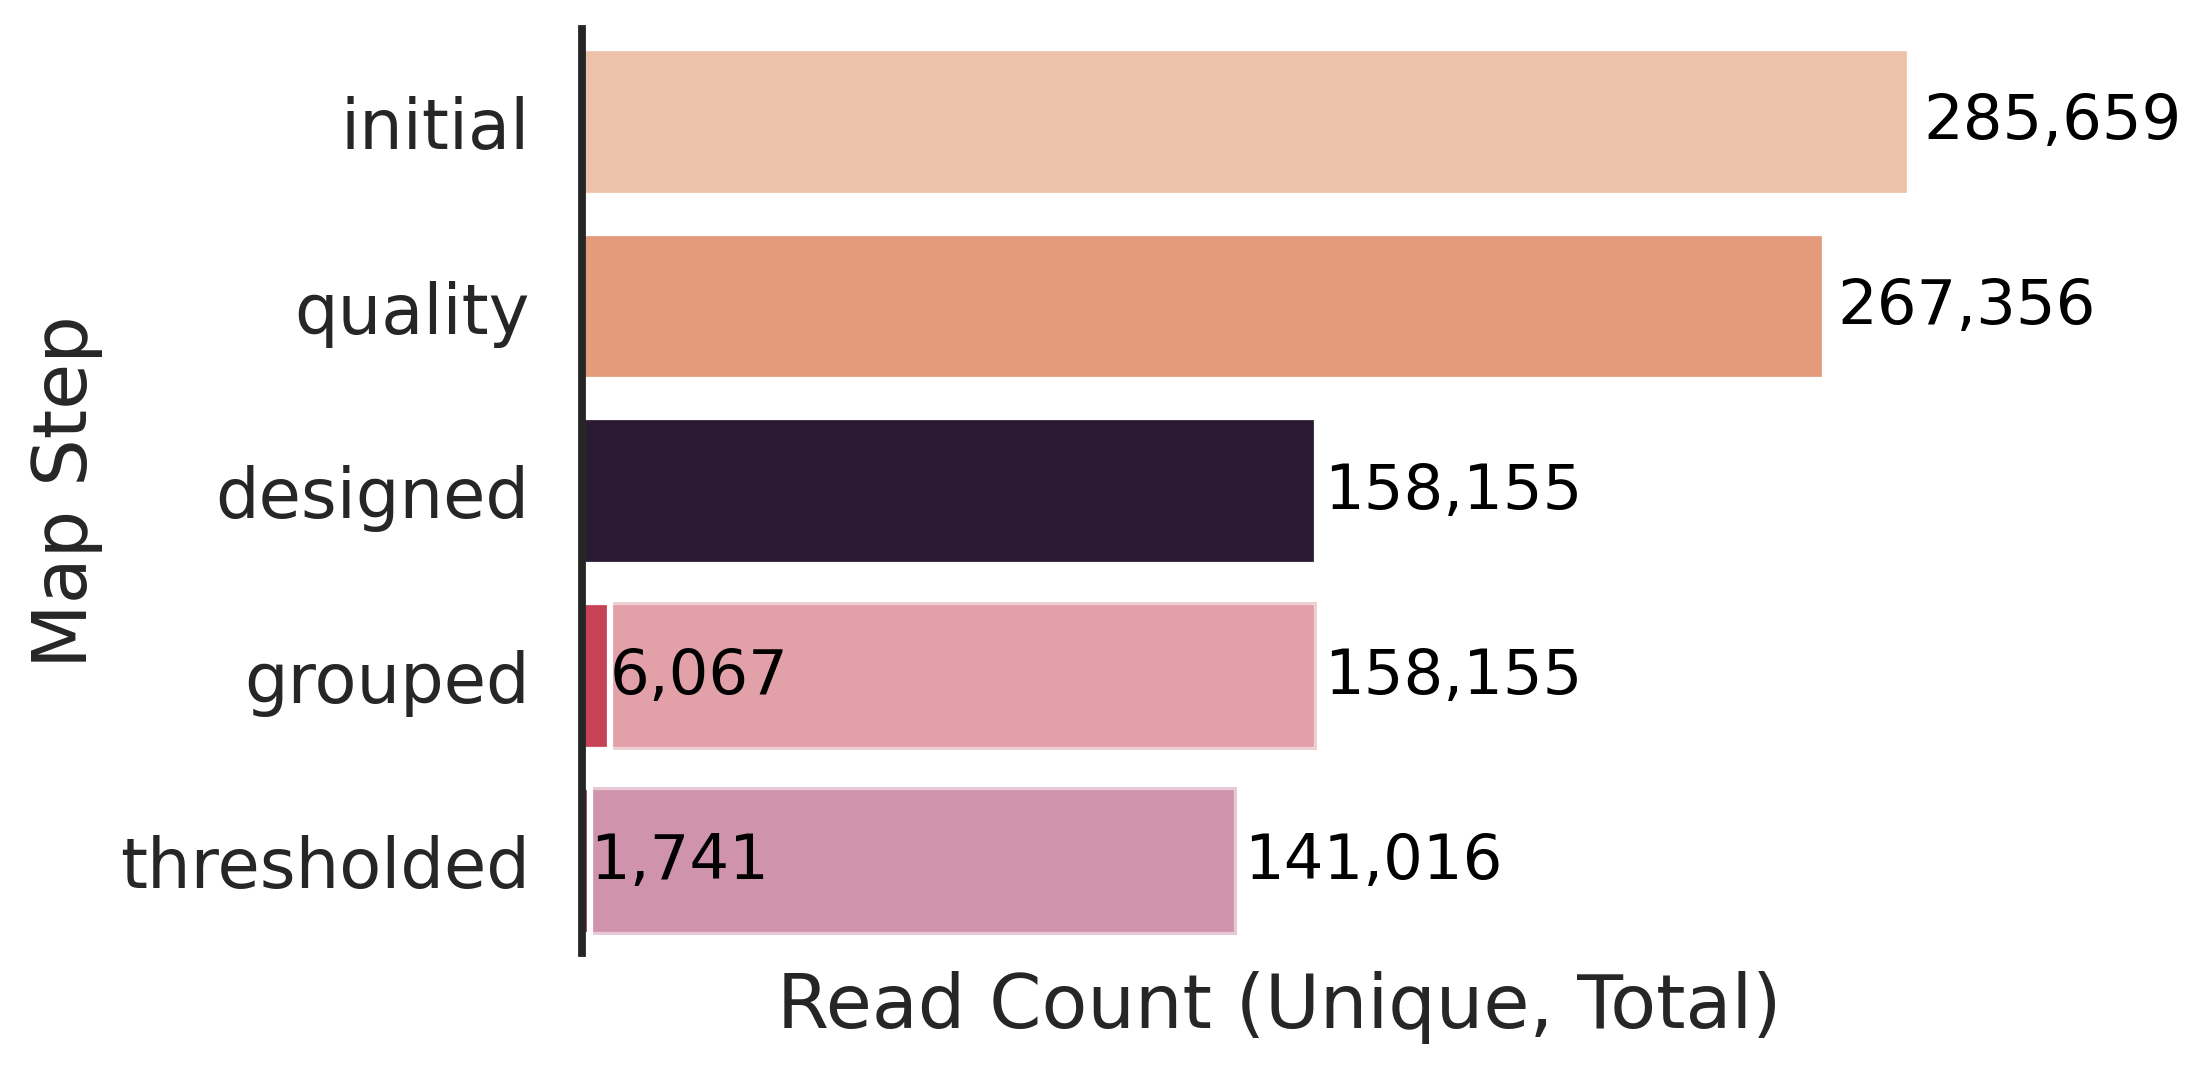

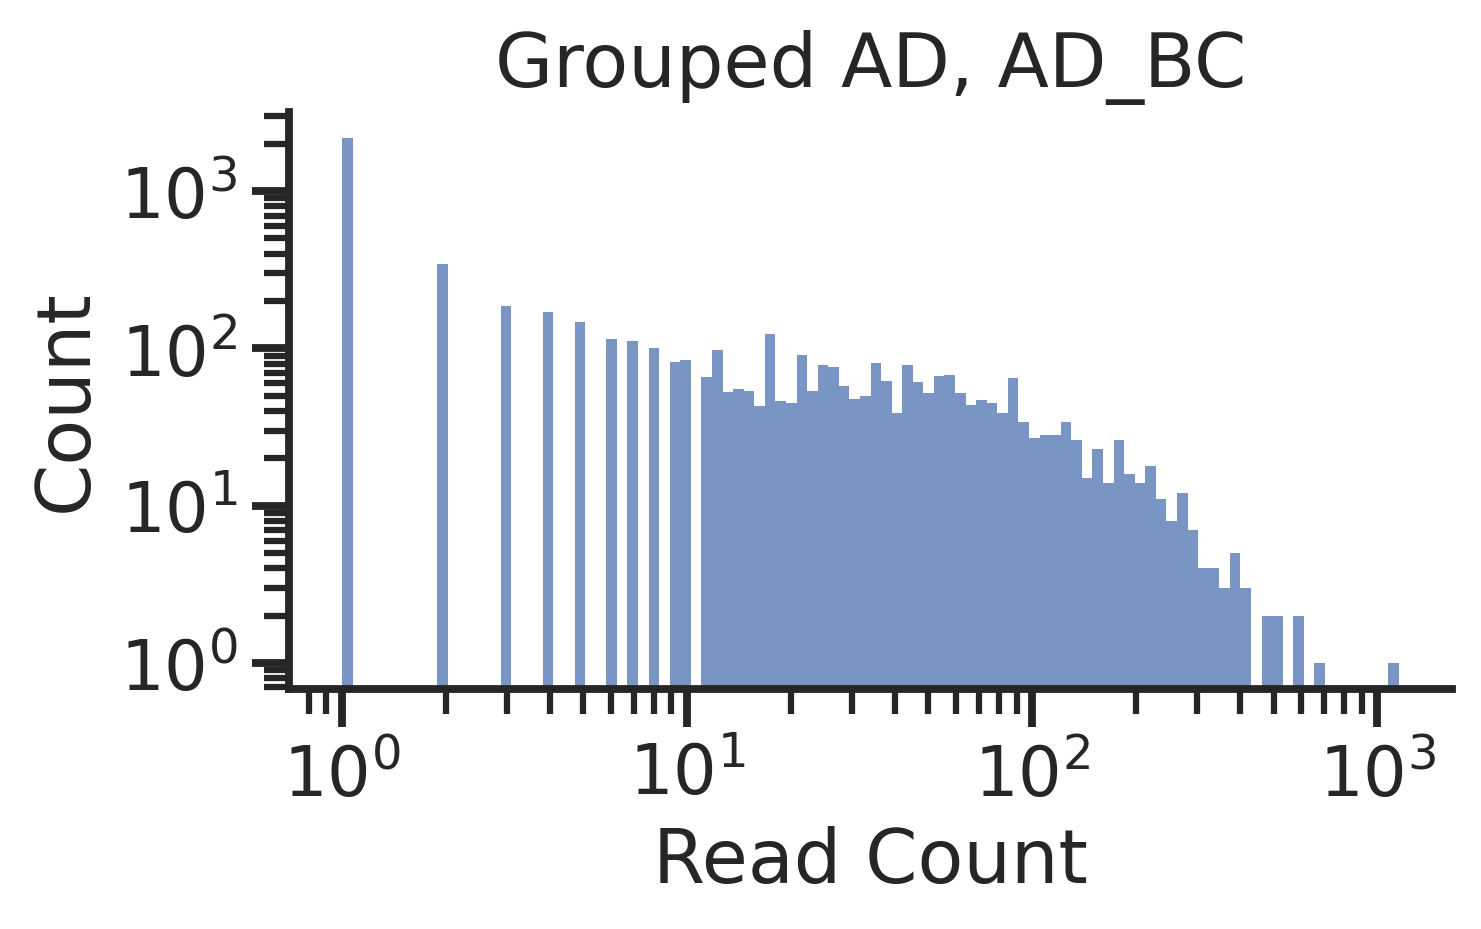

Done in 0.92 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  20


Using reads threshold of 20.


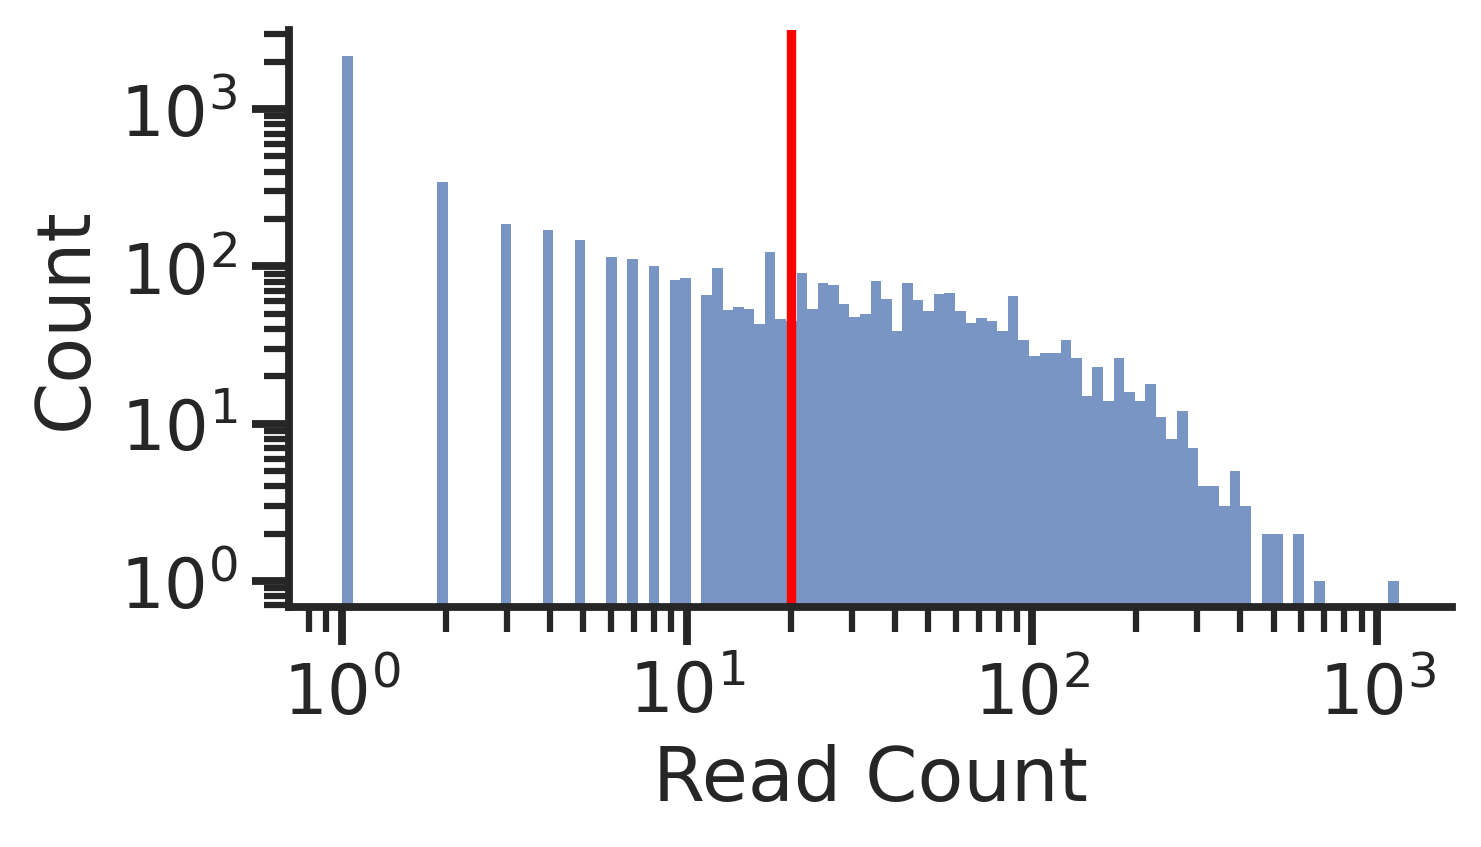

Done in 4.55 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_loss_summary'
Done in 0.09 seconds.

Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18
Reading 1 FASTQ/TXT file(s)...
Done in 1.05 seconds.

Reverse complement of sequences...
Done in 1.75 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 1.89 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 1.34 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_initial
Total rows: 305486


AD  AD_qual        AD_BC  \
0  GACCCAATGTCTGCTTCTATTGGTACTGCTATGACTGTTTCTCCTA...     True  GTCCTCTGTCG   
1  GTTCCAATGGATTTGTTGGTTCATCATGATGATCATGATGGTTTGA...     True  CCTTGATCAGT   
2  TCTCCAATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGC...     True  TGAGTGTGAAC   
3  CCAGAATATAATGATAACTTTGATGTTTCTCCATTTGTTGGTAATA...     True  AGTGTCGCATT   
4  GATTCTTTGTTTGAATCTCAAGATTTGTTTGCTTCTCCAGTTAAAC...     True  CTCCACTGCCC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.40 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.22 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_designed...


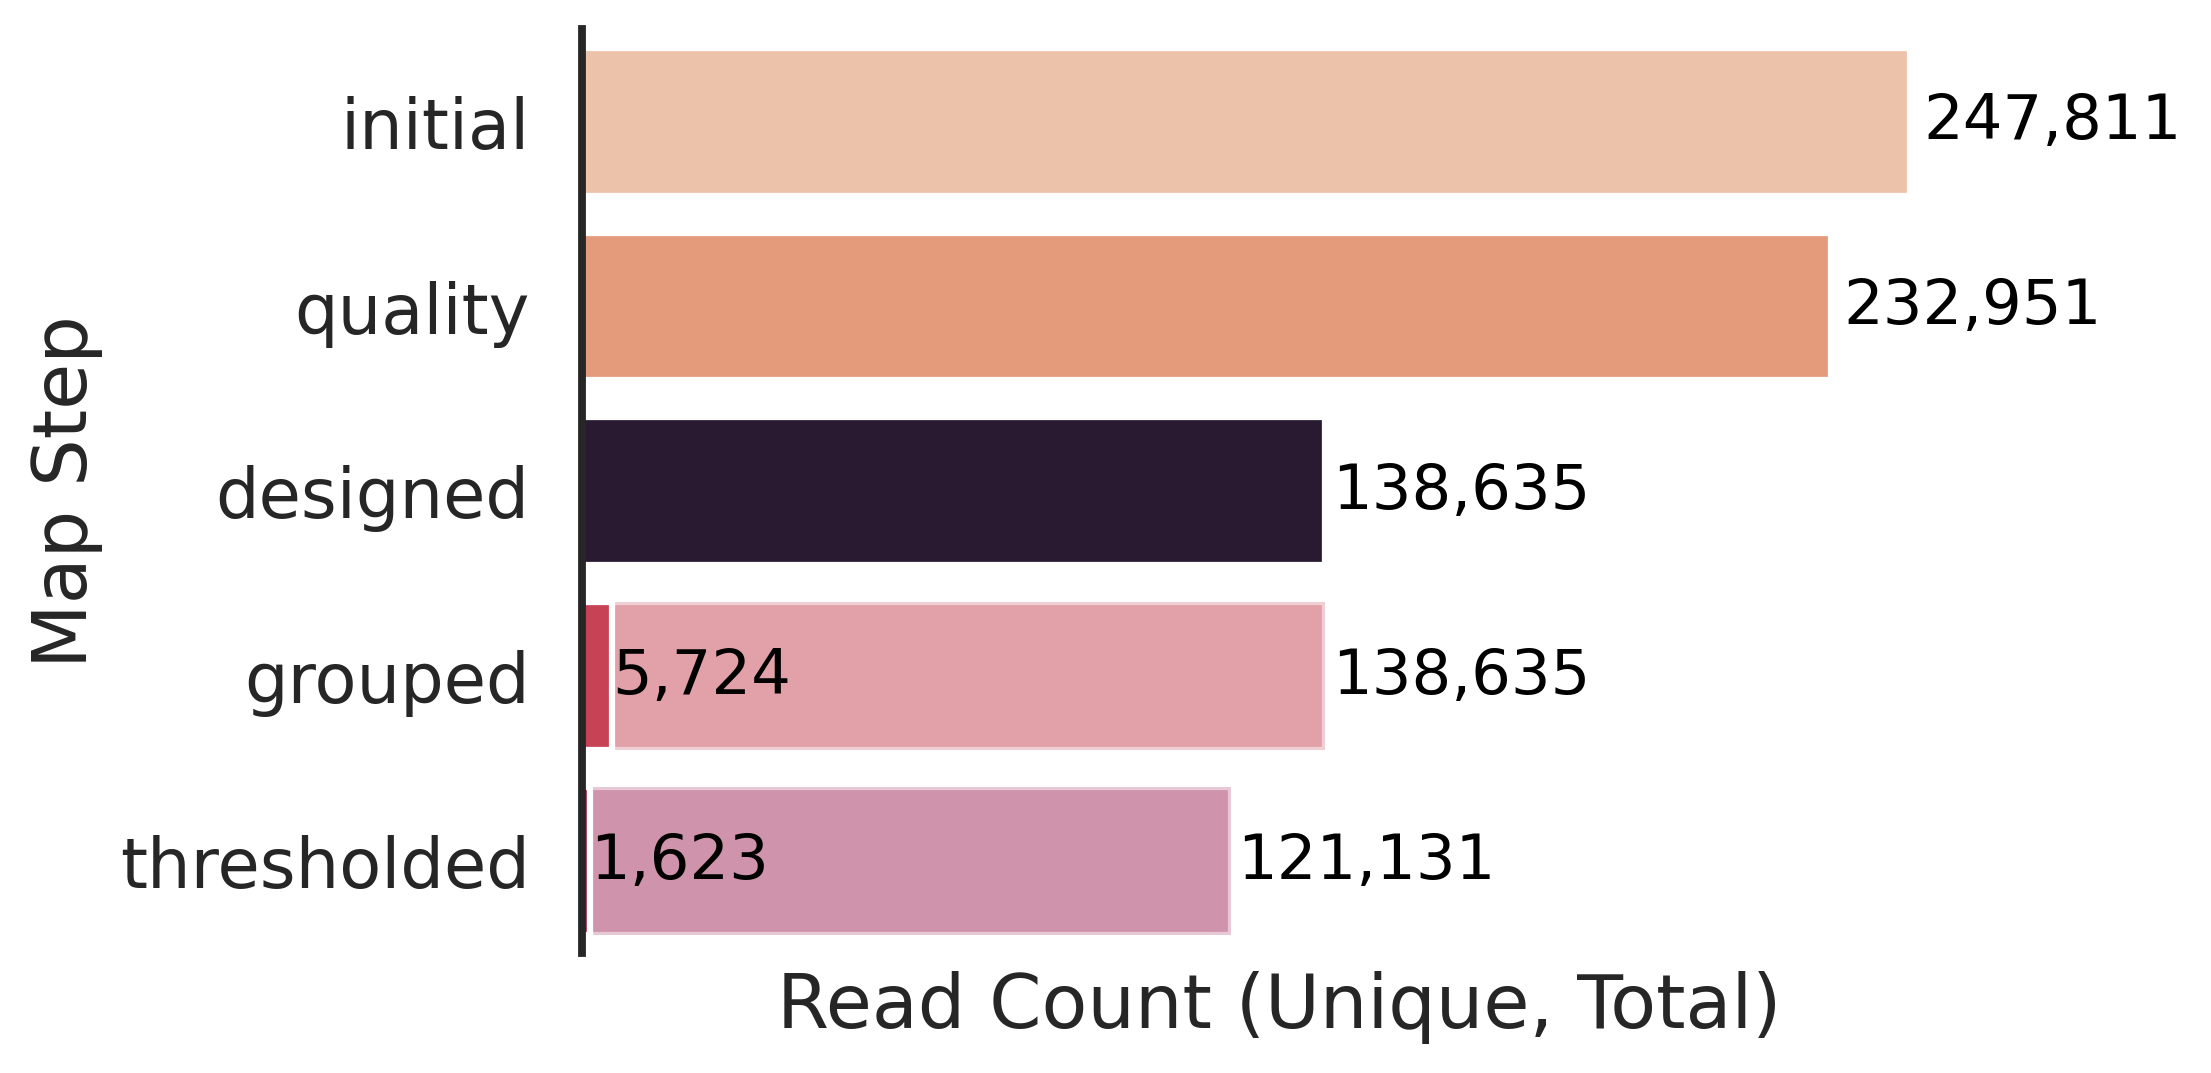

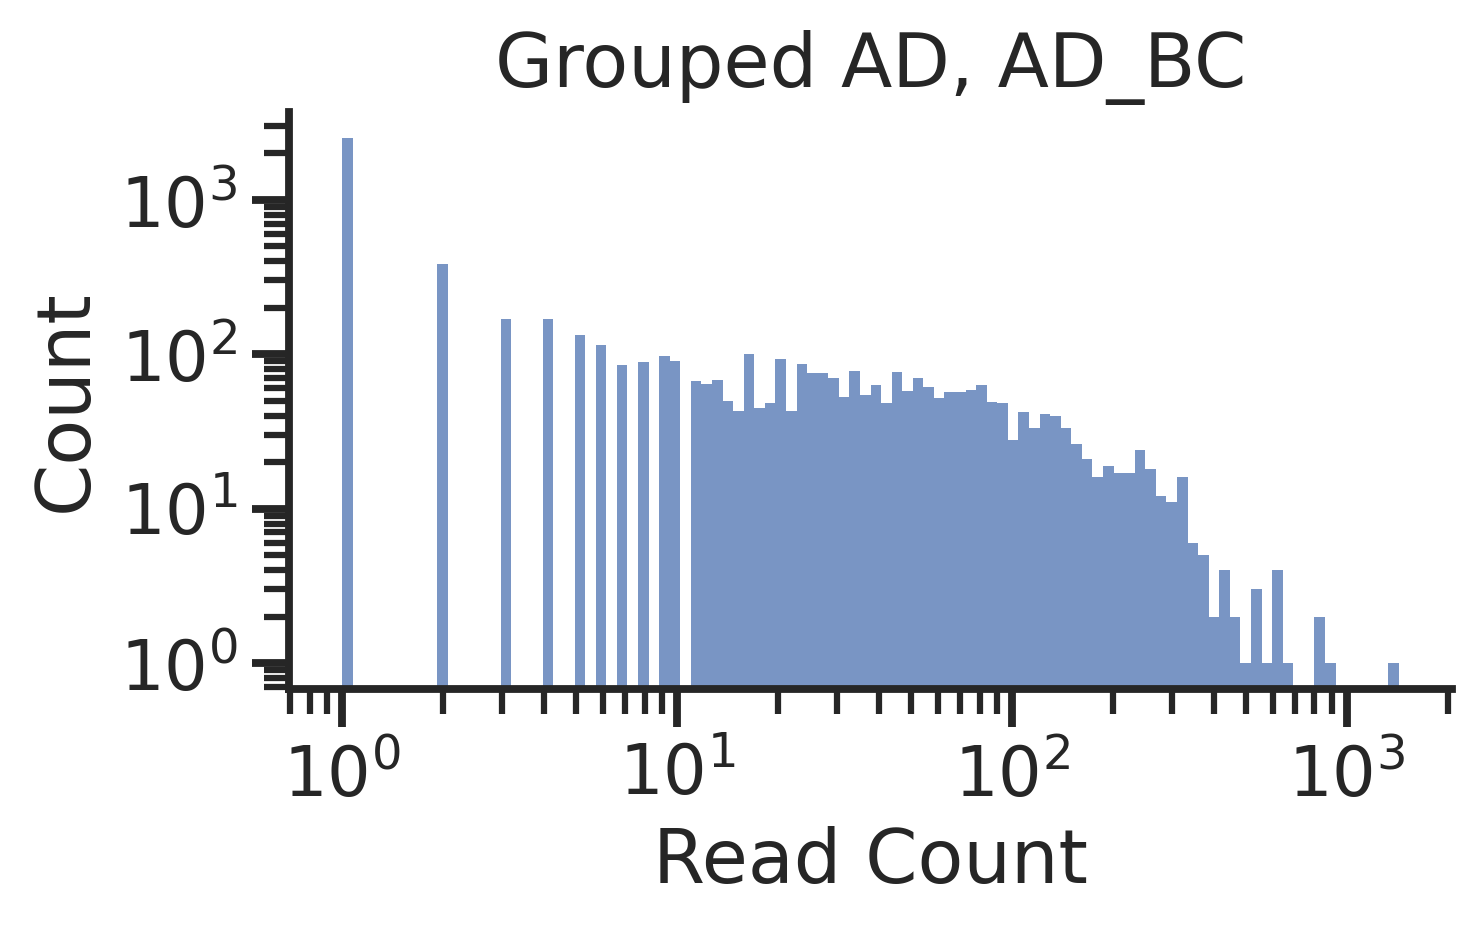

Done in 0.87 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  20


Using reads threshold of 20.


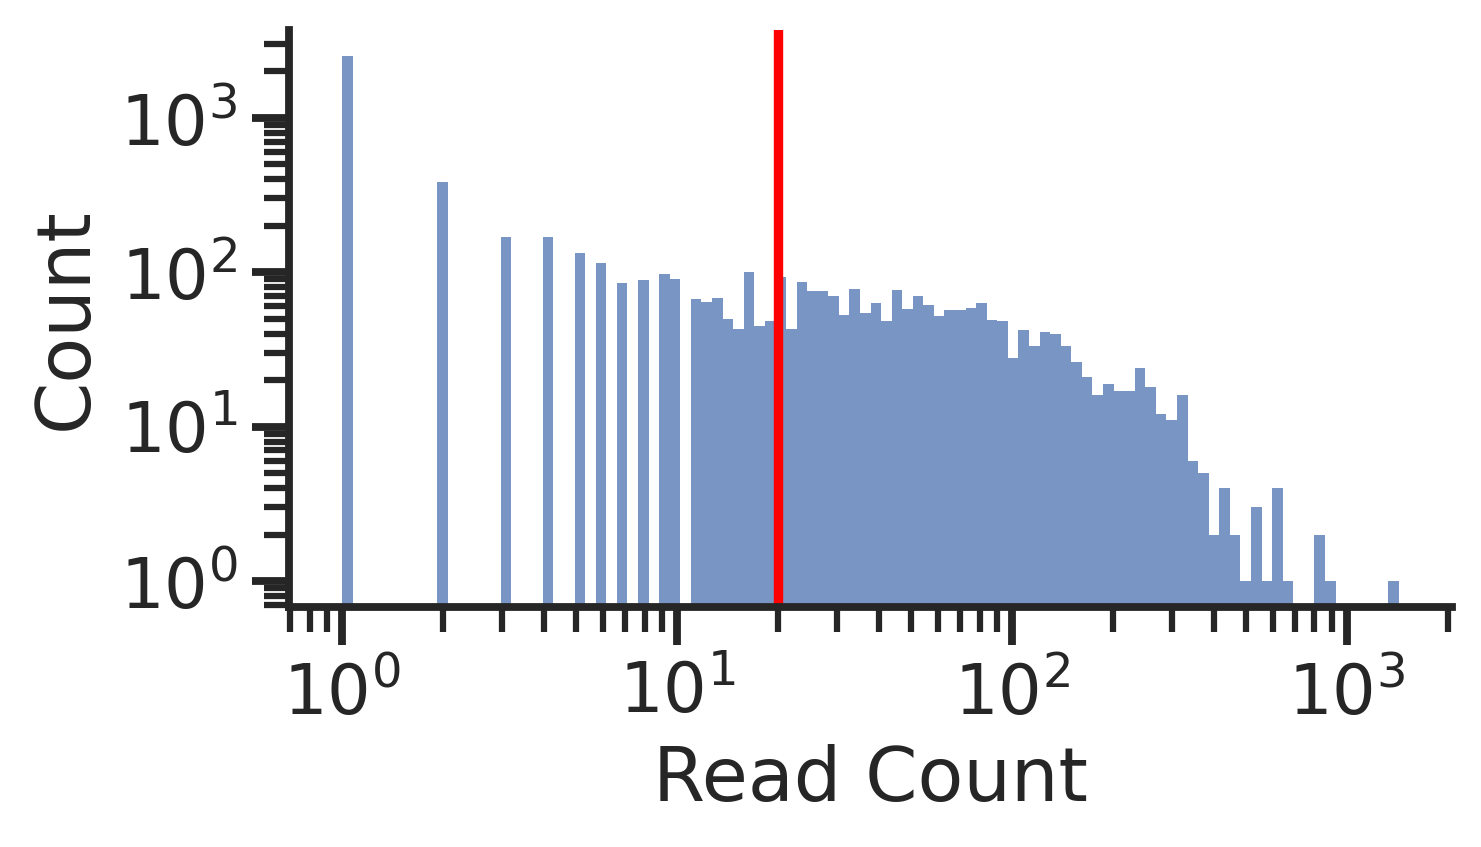

Done in 10.30 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20
Reading 1 FASTQ/TXT file(s)...
Done in 0.54 seconds.

Reverse complement of sequences...
Done in 1.50 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 1.61 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 1.25 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_initial
Total rows: 146856


AD  AD_qual        AD_BC  \
0  GGTGTTTCTTCTAGAAGAAGAGATAAACCATTGCCACCAATTATTG...     True  GCCTAACATCA   
1  AATTCTACTGCATTTACTAATTTGACTTCTCCATCTACTTATAATG...     True  ACGCCCGCCGC   
2  ATGTCTACTCCAAATATTCCACAAGGTGAATTGGGTTGTCCAGATA...     True  CCCTCCCCGAG   
3  ATCTTCTCTACTAATTTGGATGGTACTAATGATATTGATCATACTC...     True  TCGTCAAGAGA   
4  GTCTTTAATTTGGGTTATACTACTTCTTTGCCACCAGCTAGAAATT...     True  TTTGGTAACCG   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.33 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.08 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_designed...


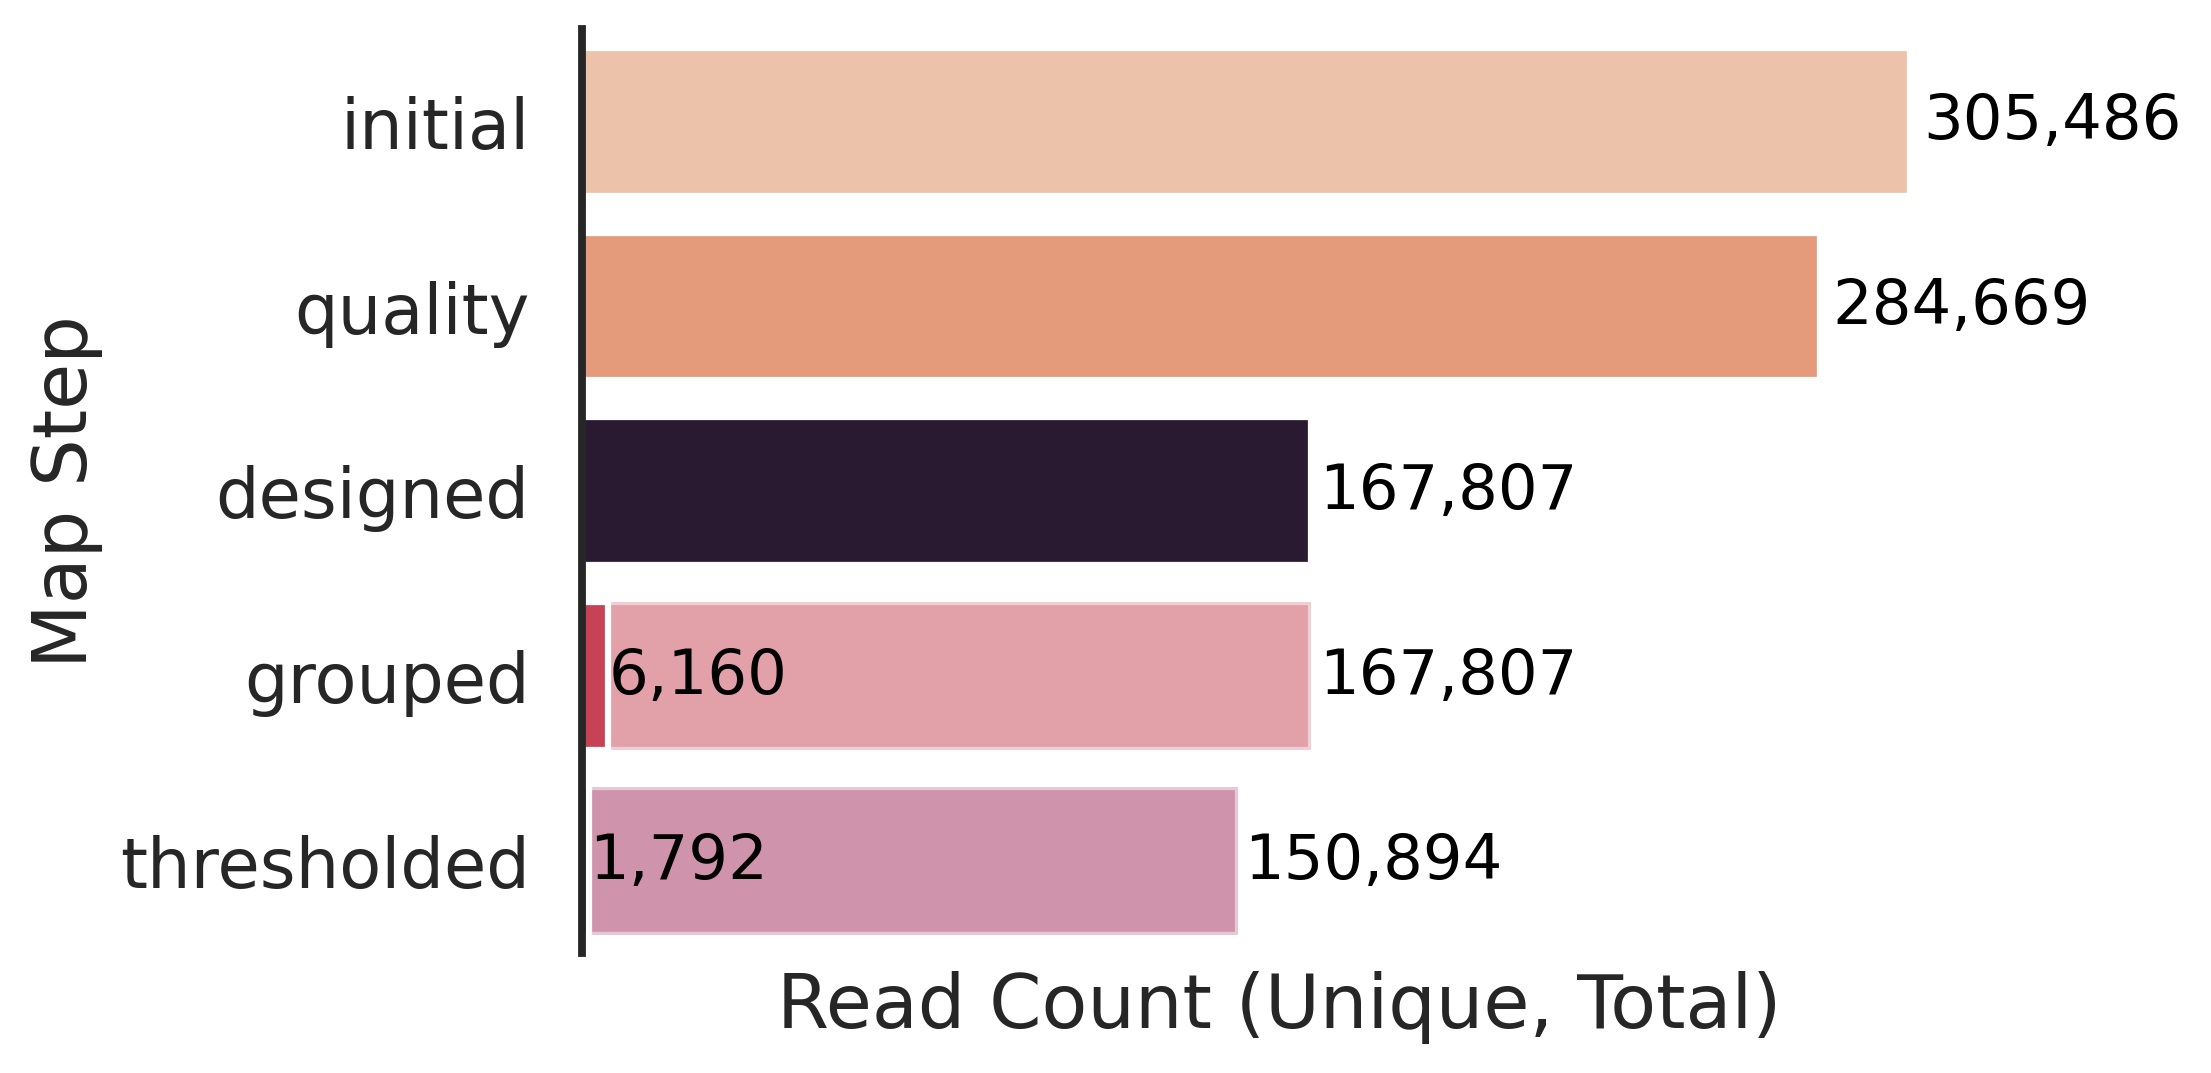

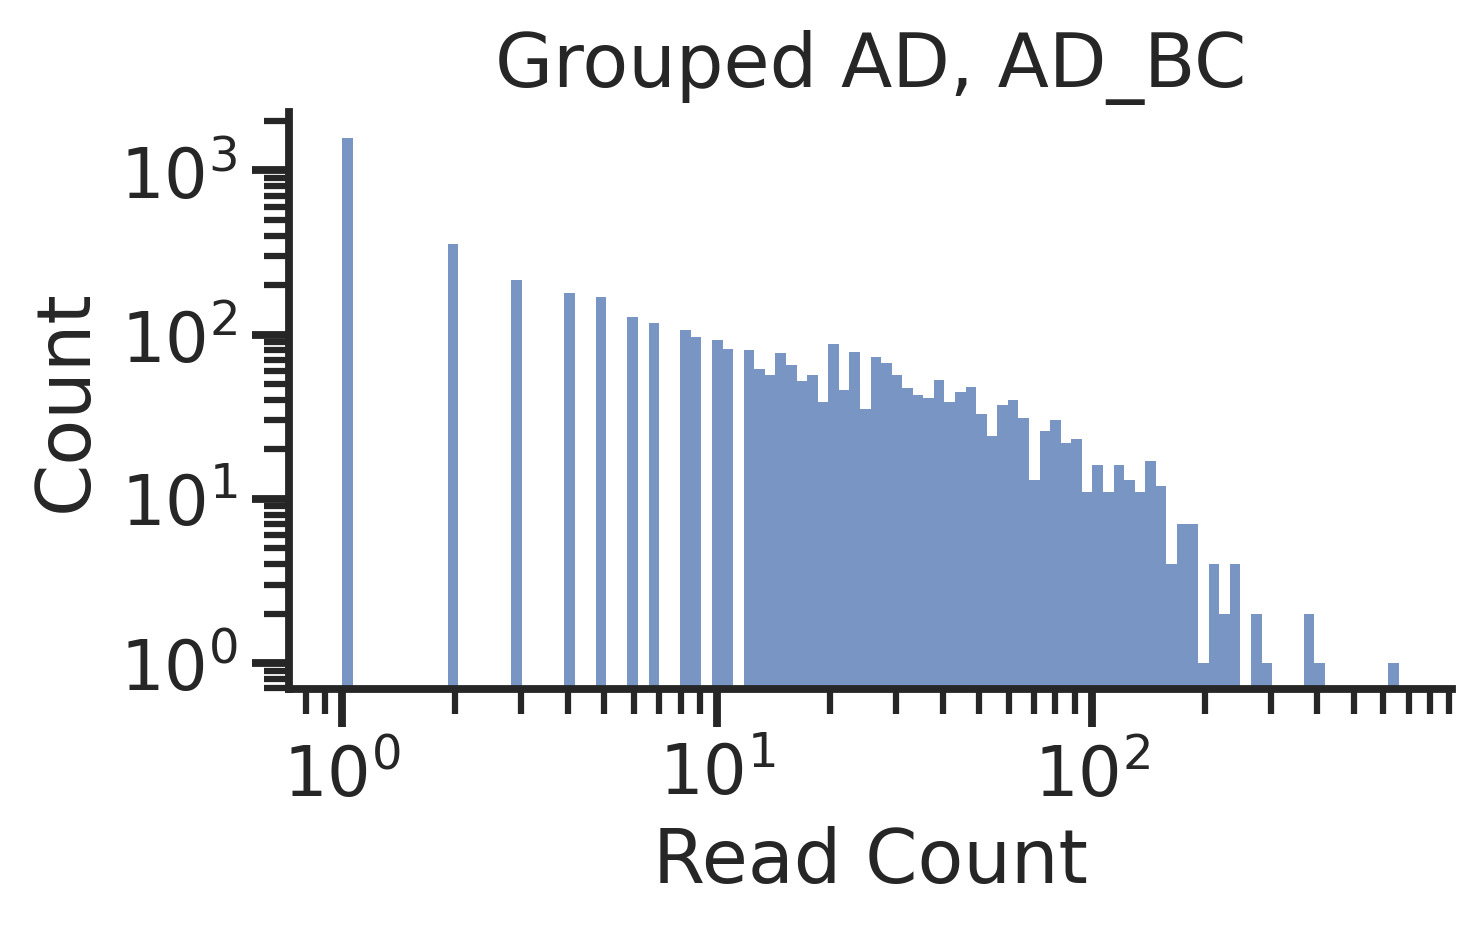

Done in 0.83 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  20


Using reads threshold of 20.


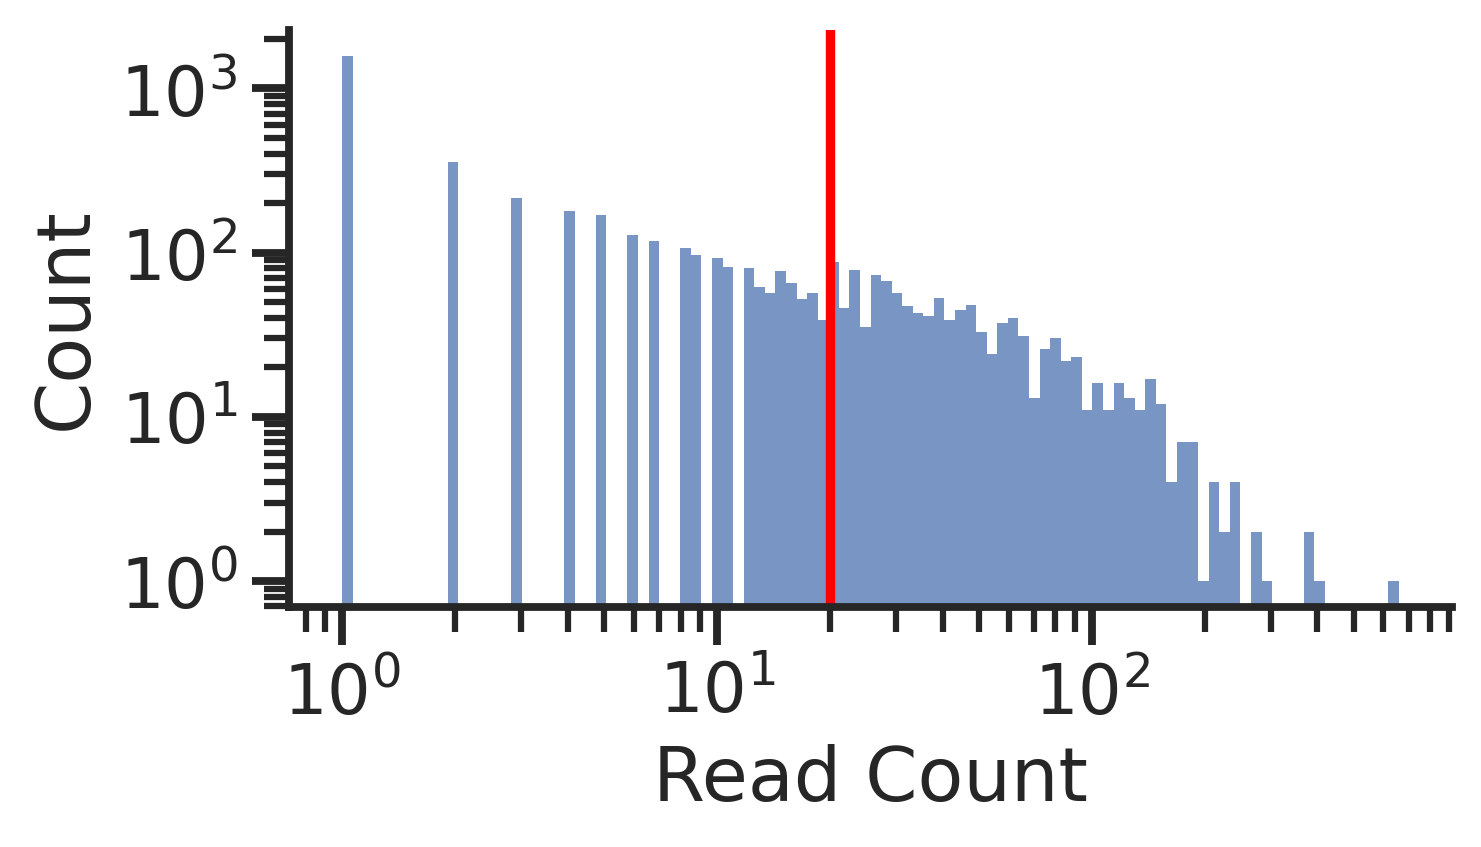

Done in 9.74 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19
Reading 1 FASTQ/TXT file(s)...
Done in 0.86 seconds.

Reverse complement of sequences...
Done in 1.57 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 1.27 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 1.59 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_initial
Total rows: 254996


AD  AD_qual        AD_BC  \
0  CAAGATATGGATTTGTTTGATGAATTTACTGCATTTGAAGGTGGTG...     True  TATATGTGTAT   
1  TCTATGTGTGGTGTTAGGAAGAGATCTCAACCATTGCCACCAATTG...     True  GCTGAATCGTG   
2  GCTAAATTGGAATCTGTCTTTGCTGACTTTCCATCTGTTACTGCTA...     True  AACTATCACGT   
3  TCTGCTTTGACTAATAGATTTACTCCACAACAATCTTCTATTCAAC...     True  ACACACTCGGT   
4  GAATTGTTGCAACAACCACATCAAGAAGCTTCTGCTTTGCACTTCT...     True  TTTCTGCAATC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.35 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.18 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_designed...


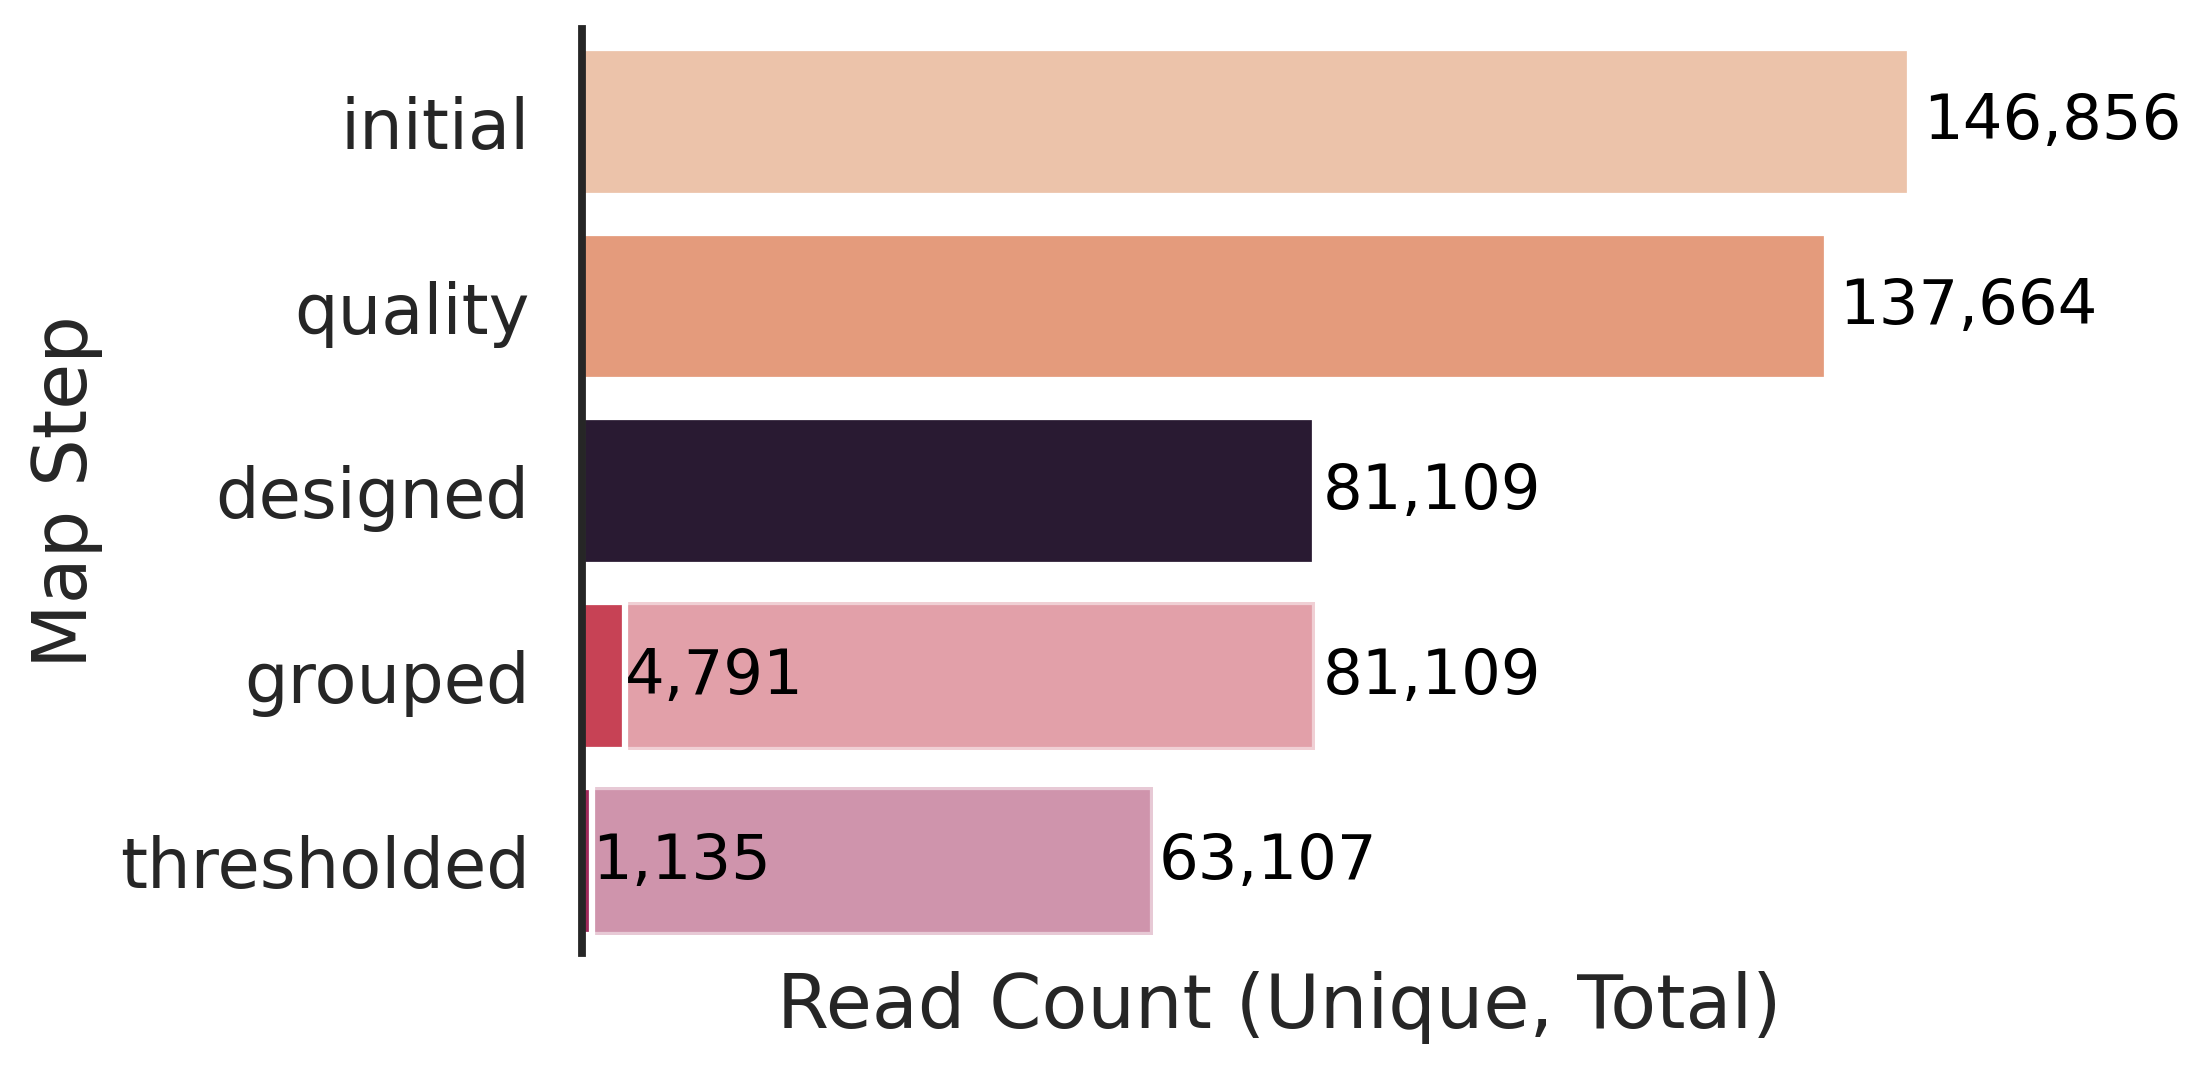

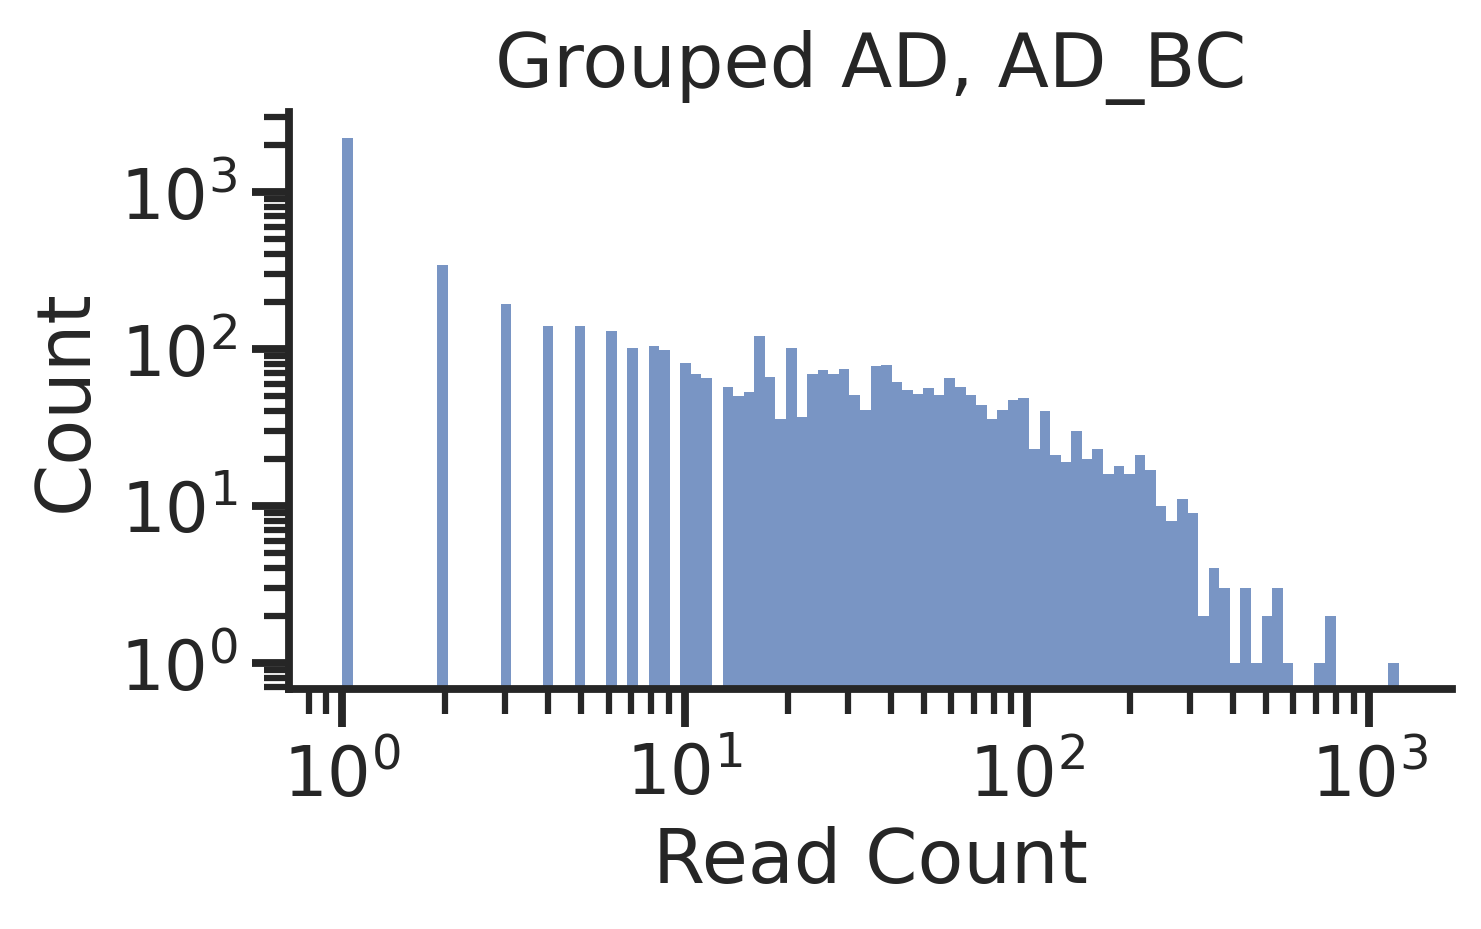

Done in 0.89 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  20


Using reads threshold of 20.


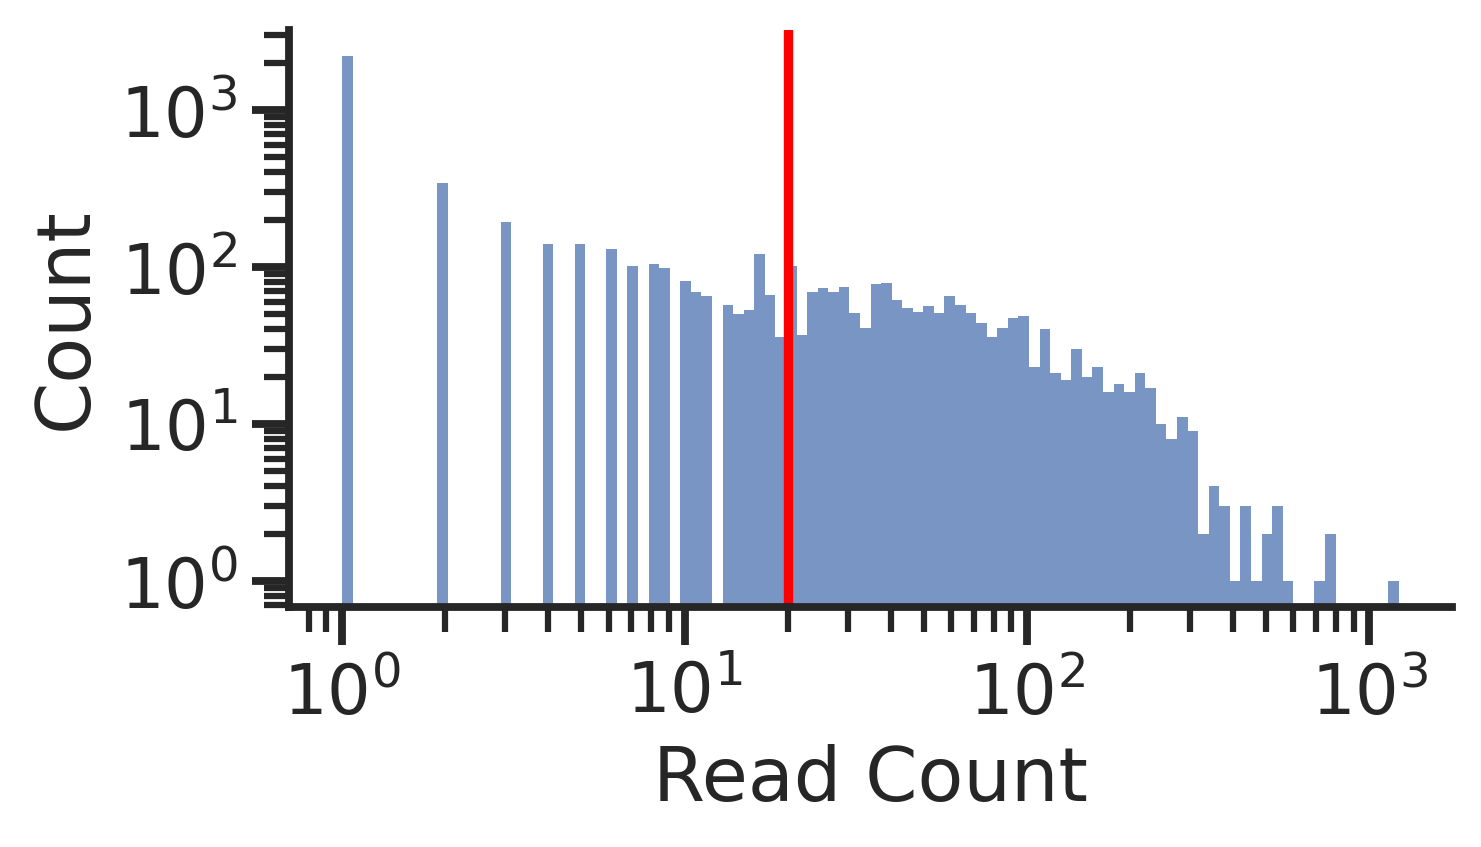

Done in 4.08 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_loss_summary'
Done in 0.08 seconds.



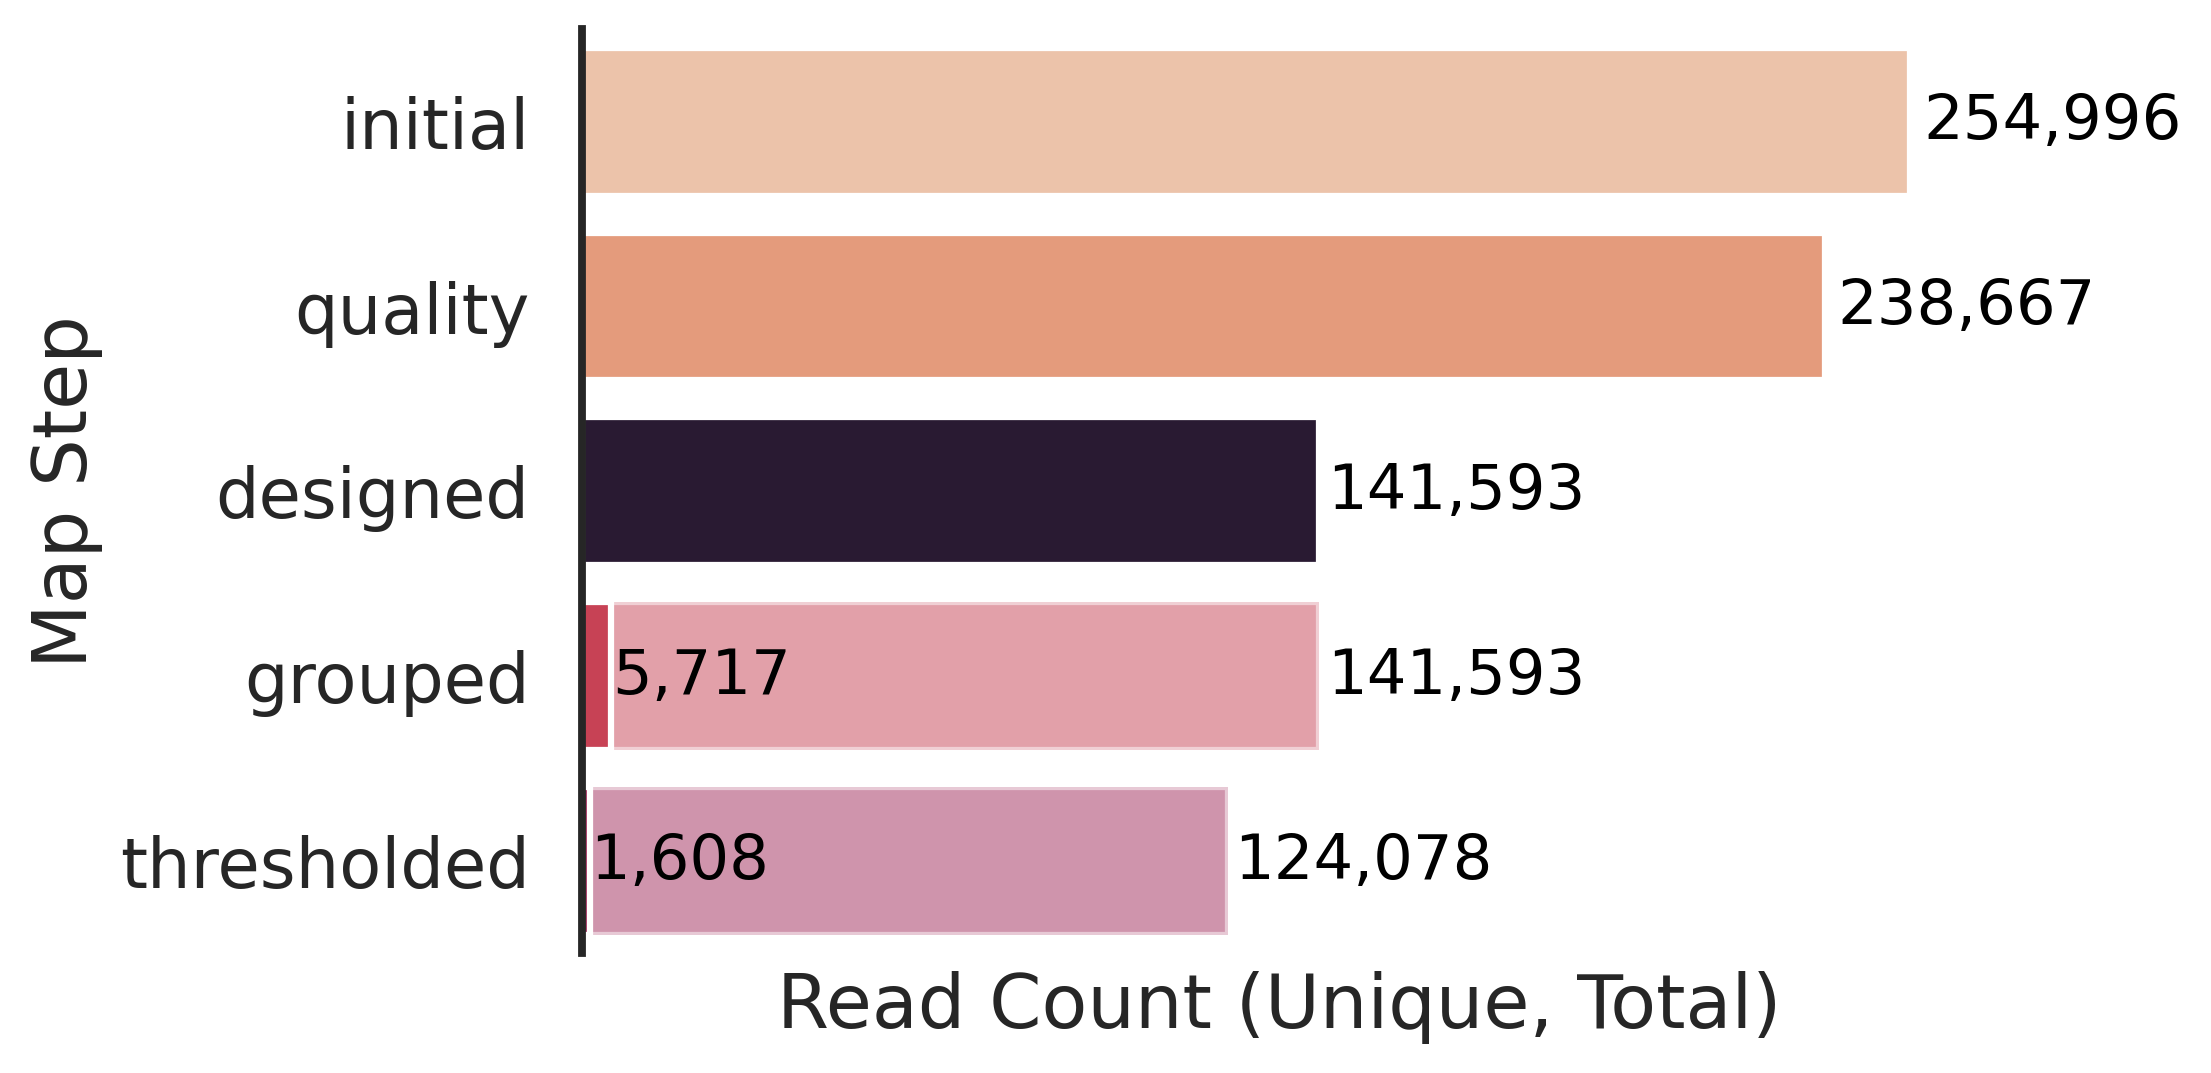

In [155]:
AD_objects = [EC_AD, EC_AD_BC]

complex_AD_results = []
simple_AD_results = []

for file_path in yeast_pool_A_AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # Get the file naeme to use for output
    file_output_path = os.path.join(yeast_pool_A_output_path, f"trebl_experiment_yeast_pool_A_{name_only}")
    print(file_output_path)

    # Extract UMIs and barcodes from reads
    bc_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_A_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                       bc_objects = AD_objects,
                                       reverse_complement = True)
    umi_map = bc_mapper.create_map()
    display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        map_order = ['quality', 'designed', 'grouped', 'thresholded'],
                                        step_name=f"trebl_experiment_yeast_pool_A_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = True)
    refiner.refine_map_from_db()
    refiner.plot_loss()
    

In [24]:
tables = refiner.show_tables()

yeast_pool_A_AD_result_tables = []

for table in tables:
    if "trebl" in table[0] and "thresholded" in table[0]:
        print(table[0])
        df = refiner.get_map_df(table[0])
        df["sample"] = table[0][38:]
        yeast_pool_A_AD_result_tables.append(df)

yeast_pool_A_AD_result_df = pd.concat(yeast_pool_A_AD_result_tables)
yeast_pool_A_AD_result_df

trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_thresholded


AD        AD_BC  count  \
0     GATTCTTTGTTTGAATCTCAAGATTTGTTTGCTTCTCCAGTTAAAC...  CTCCACTGCCC    660   
1     TCTCATACTACTACTGTTACTCAAACTGTTGTTTCTTCTAAACCAG...  CGTCCGATAAG    417   
2     CAACCAAATCCATATTTGAGAGCTTTGGCTTTGTCTCCAACTCCAG...  TAGAATAAGAC    388   
3     GATCAATCTCCAGGTATCTTTGCTGGTGATGCTGTTATGGCTTCTG...  GTTTCTCGCTA    380   
4     GTTCCAATGGATTTGTTGGTTCATCATGATGATCATGATGGTTTGA...  CCTTGATCAGT    290   
...                                                 ...          ...    ...   
1618  GCTTCTCCAACTGCTAGATCTTCTATTTCTGGTAGGAAAGGTTCTA...  ACCTTAAAACT     21   
1619  CAACCACAAACTCAAACTCAAACTGAACAACAAACTCAACCATTGC...  CCCTTCCCGTC     21   
1620  TCTCCACCACAACAAGACTTTGTCTTGTTTGATTCTCCACAACCAC...  TTCCCGTTTGT     21   
1621  ATGGATTTGTTTGATGACTTTACTGCATTTGAAGGTGGTGCTTCTA...  GTTCCACGAGG     21   
1622  AAGACTTCTAGGAAGAGAGCTTCTAGAGATTTGGGTCCAATTAAAT...  GCGTTTCTCGG     21   

      AD_qual  AD_BC_qual  Designed  \
0        True        True         1   
1        True        True         1   
2        True        True         1   
3        True        True         1   
4        True        True         1   
...       ...         ...       ...   
1618     True        True         1   
1619     True        True         1   
1620     True        True         1   
1621     True        True         1   
1622     True        True         1   

                                                 sample  
0     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
1     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
2     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
3     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
4     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
...                                                 ...  
1618  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  
1619  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  
1620  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  
1621  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  
1622  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  

[7899 rows x 7 columns]

In [25]:
yeast_pool_A_AD_result_df["sample"].value_counts()

sample
AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_thresholded    1792
AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_thresholded         1741
AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_thresholded          1623
AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_thresholded    1608
AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_thresholded          1135
Name: count, dtype: int64

### 2. RPTR BC

Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25
Reading 1 FASTQ/TXT file(s)...
Done in 0.68 seconds.

Reverse complement of sequences...
Done in 1.51 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.45 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 0.80 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_initial
Total rows: 277049


RPTR_BC  RPTR_BC_qual  Designed
0  TTTTCTGTNTATCA          True         1
1  ATATGGAAGTANAT          True         1
2  GAGACTCATATANA          True         1
3  TTTGTATCNTTTAG          True         1
4                         False         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.08 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_quality...


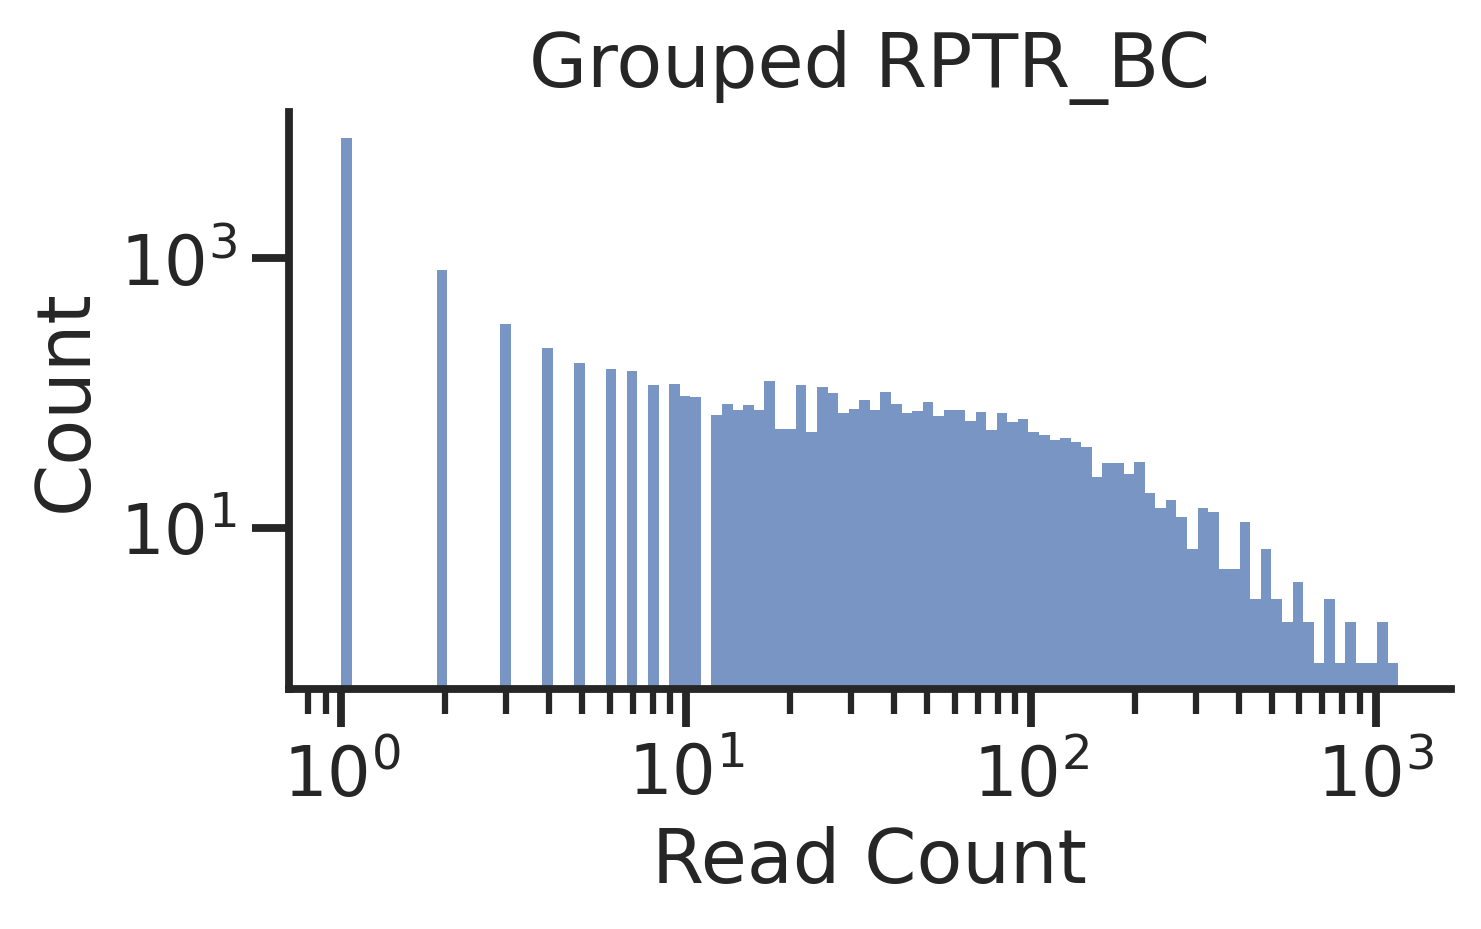

Done in 0.49 seconds.

Thresholding...
Using reads threshold of 20.


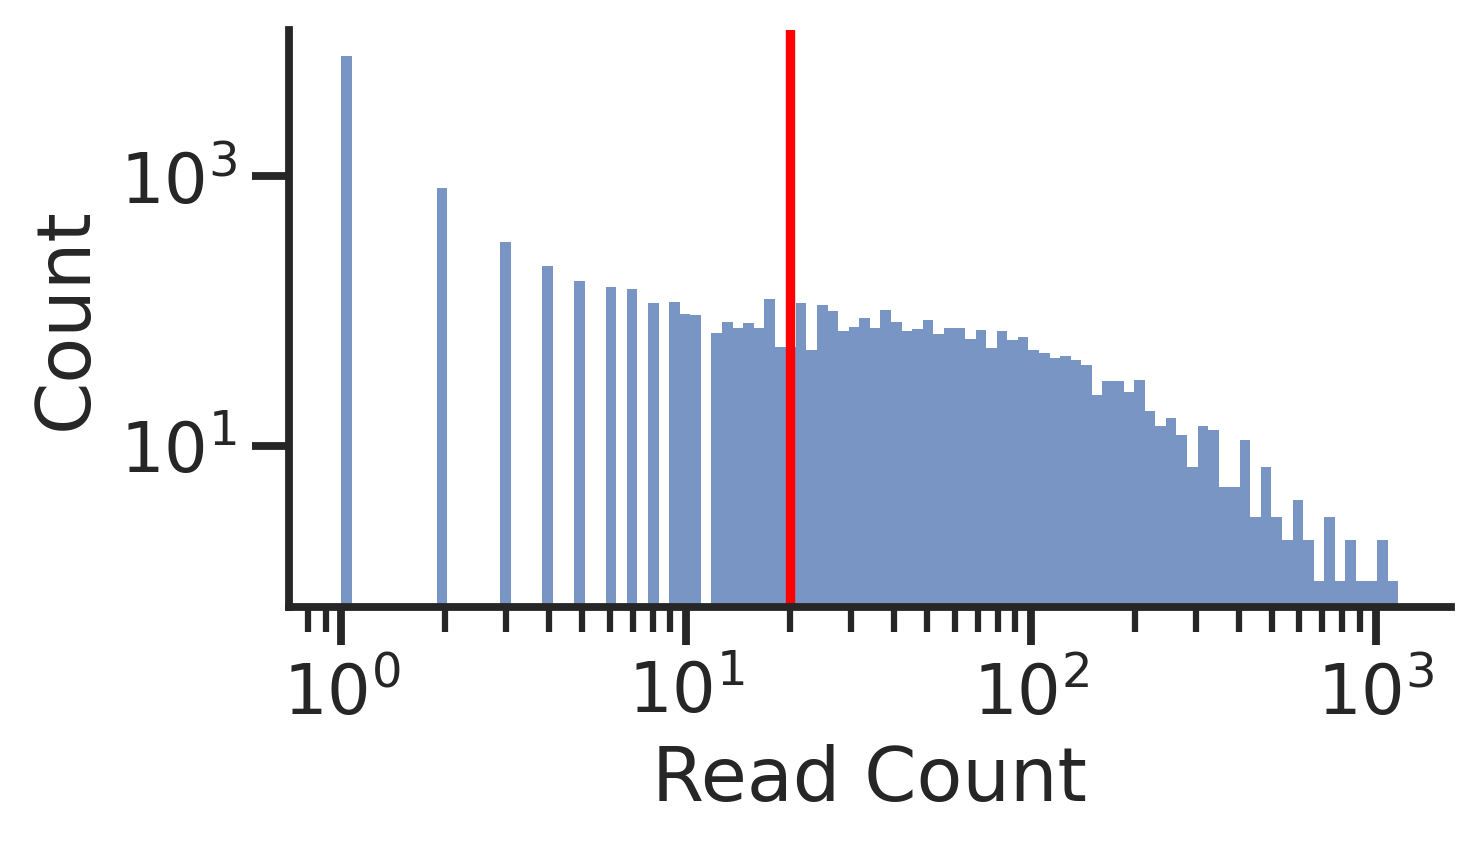

Done in 0.45 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_loss_summary'
Done in 0.02 seconds.

Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24
Reading 1 FASTQ/TXT file(s)...
Done in 0.86 seconds.

Reverse complement of sequences...
Done in 1.70 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.26 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 0.51 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_initial
Total rows: 368875


RPTR_BC  RPTR_BC_qual  Designed
0  GGACCGGANGTGAG          True         1
1  TGCGTGGGTTACNT          True         1
2  TCAGCATCCAANAC          True         1
3  AATGCGTTAGGNGG          True         1
4                         False         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.11 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_quality...


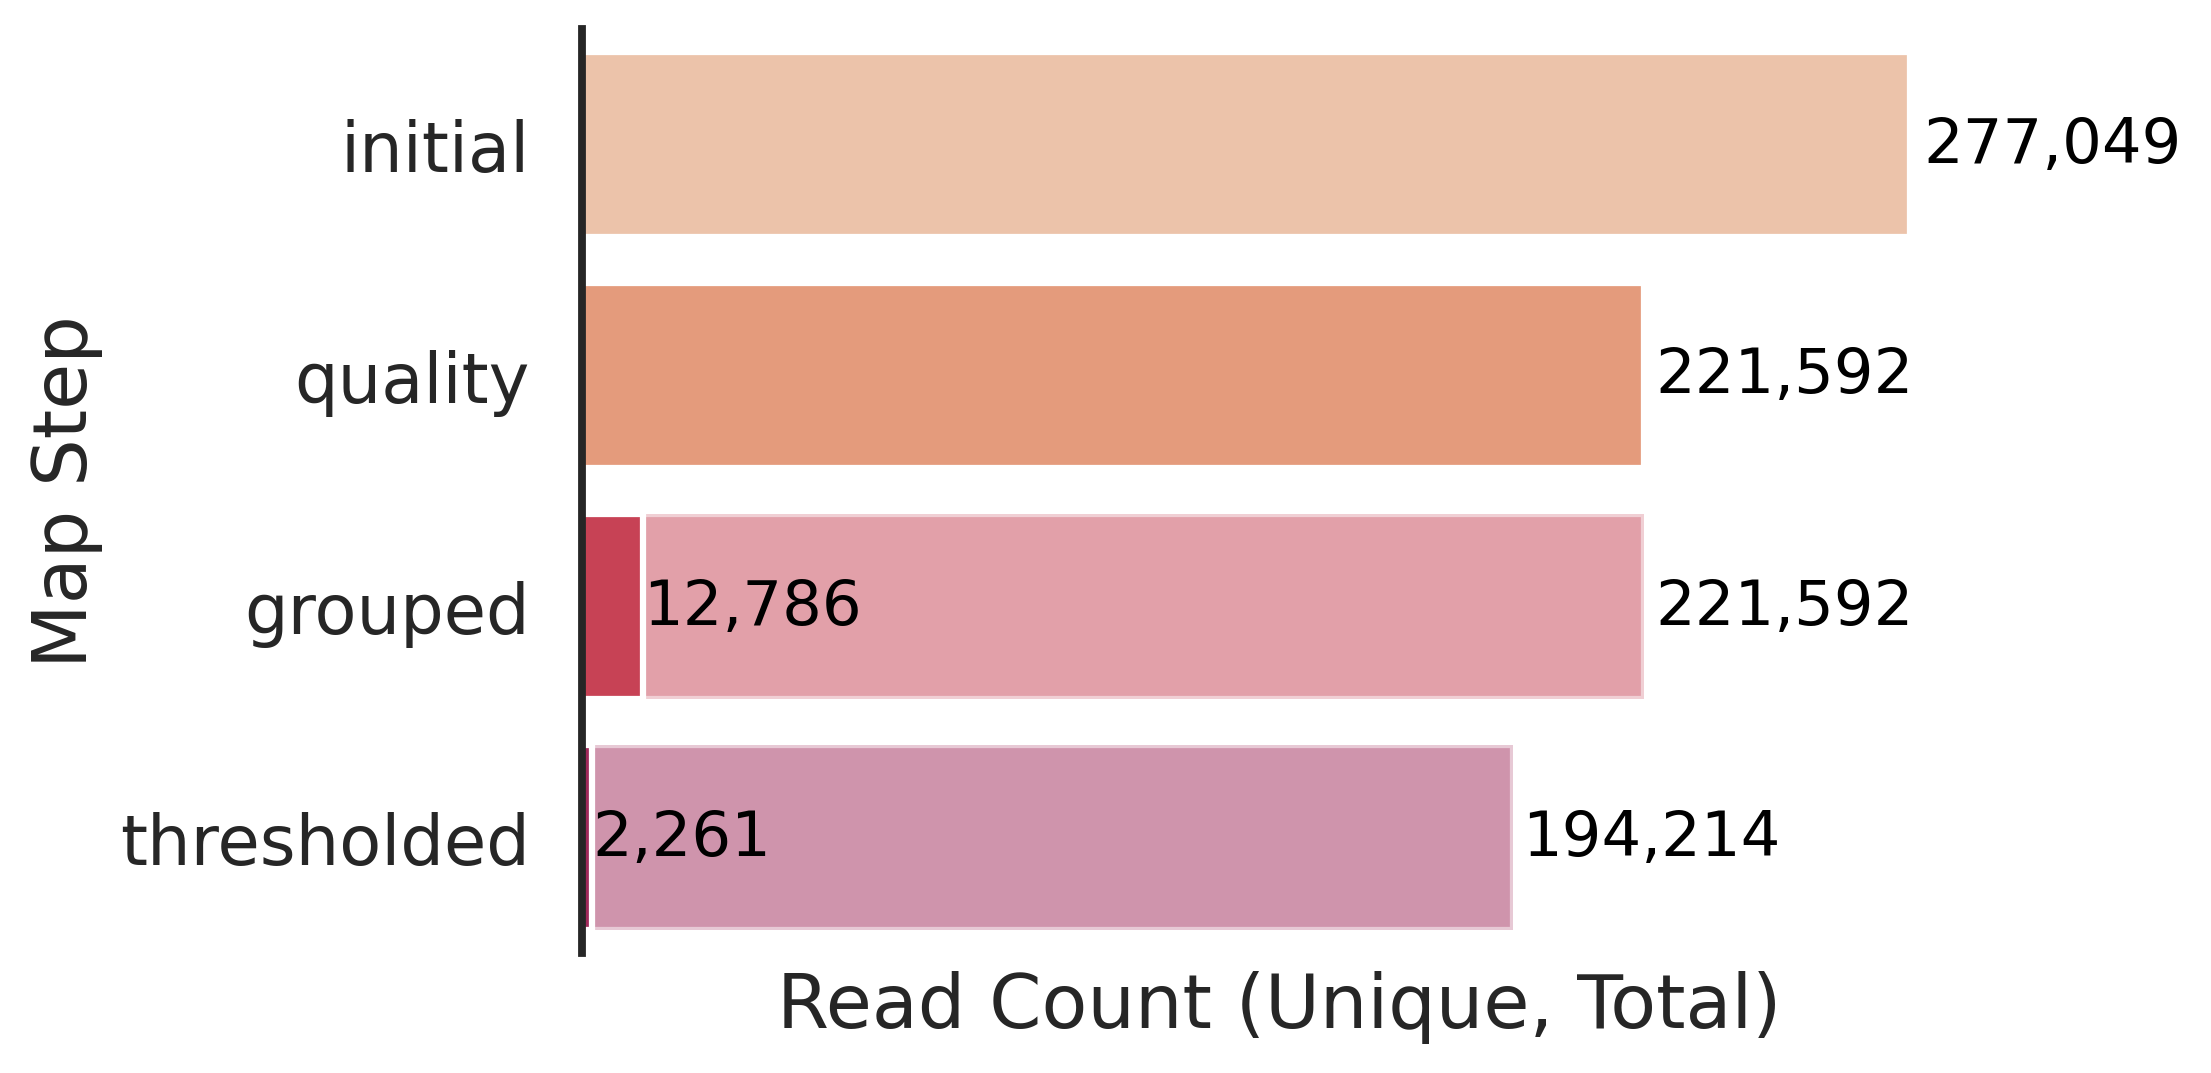

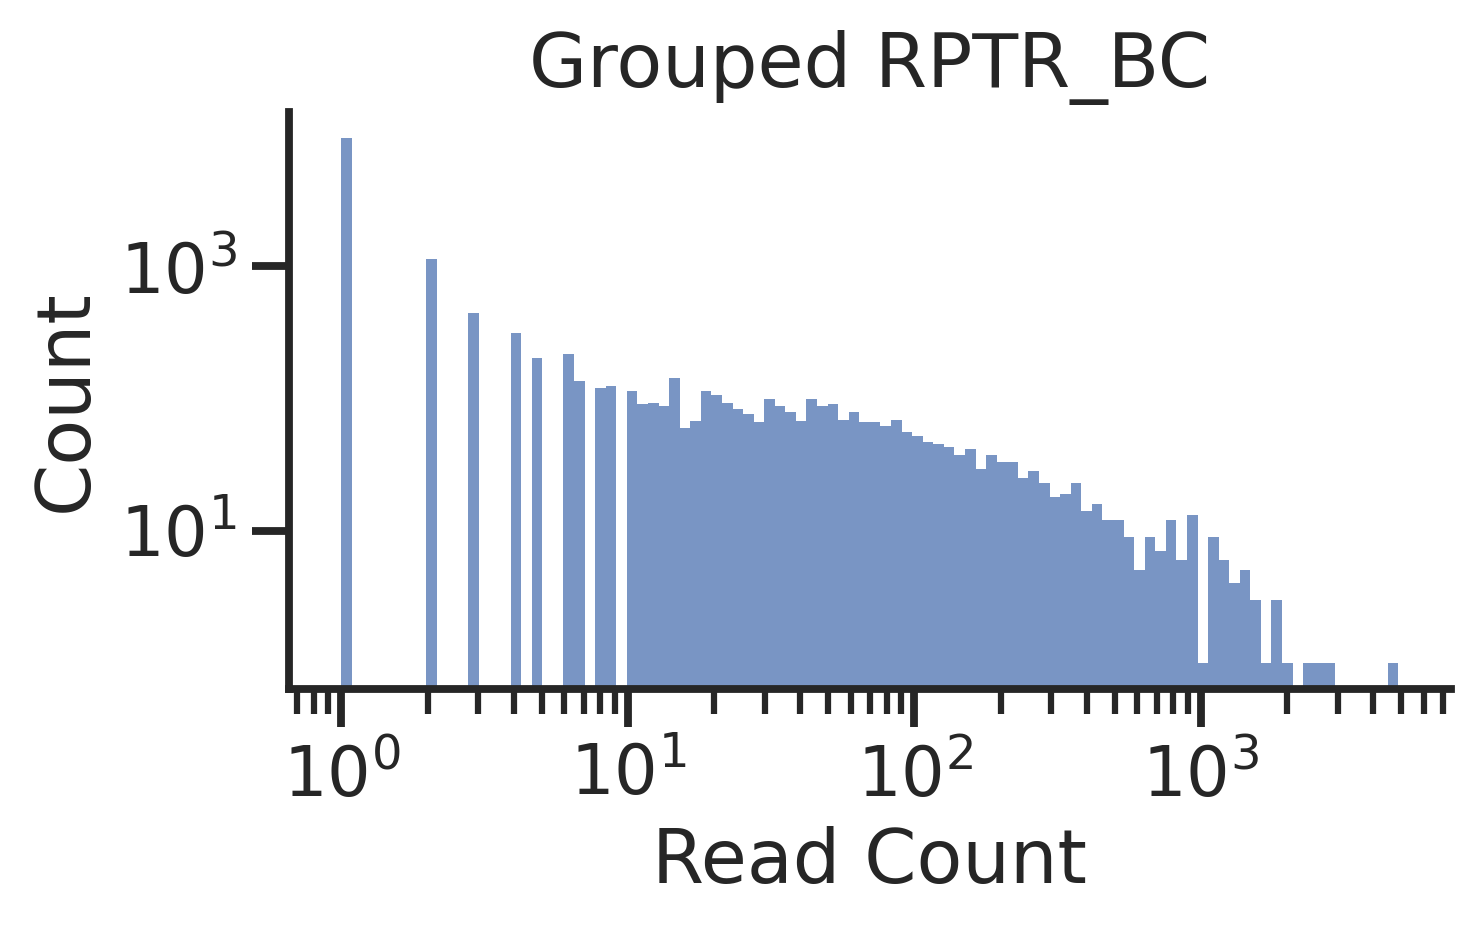

Done in 0.98 seconds.

Thresholding...
Using reads threshold of 20.


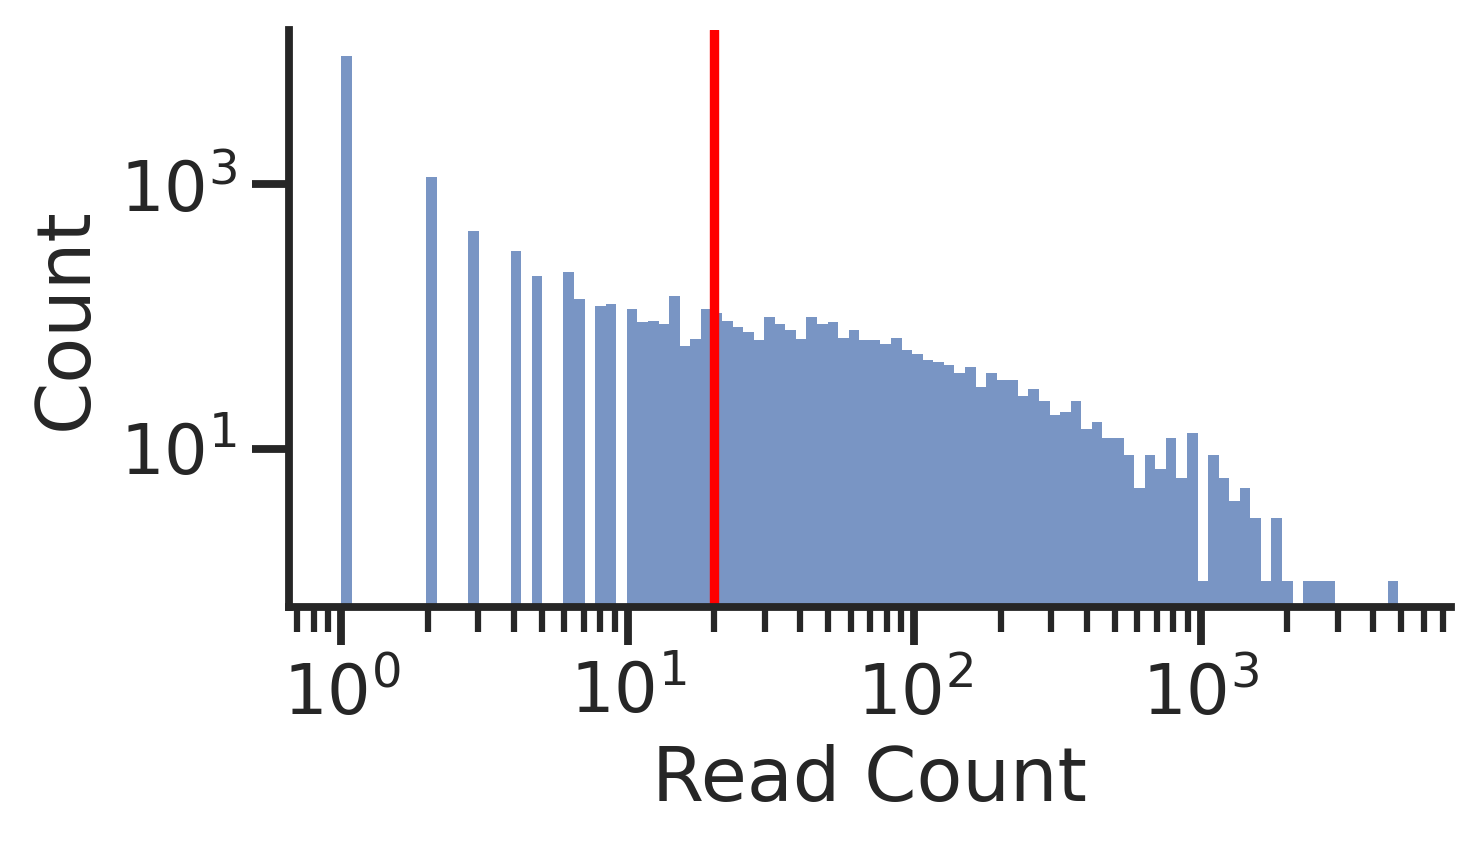

Done in 0.45 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_loss_summary'
Done in 0.01 seconds.

Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26
Reading 1 FASTQ/TXT file(s)...
Done in 0.96 seconds.

Reverse complement of sequences...
Done in 1.48 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.22 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 0.51 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_initial
Total rows: 253560


RPTR_BC  RPTR_BC_qual  Designed
0  AGGCCTACNACCTG          True         1
1                         False         1
2                         False         1
3  GCCACAGCNACACA          True         1
4  TGGGCCGGAATNGC          True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.08 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_quality...


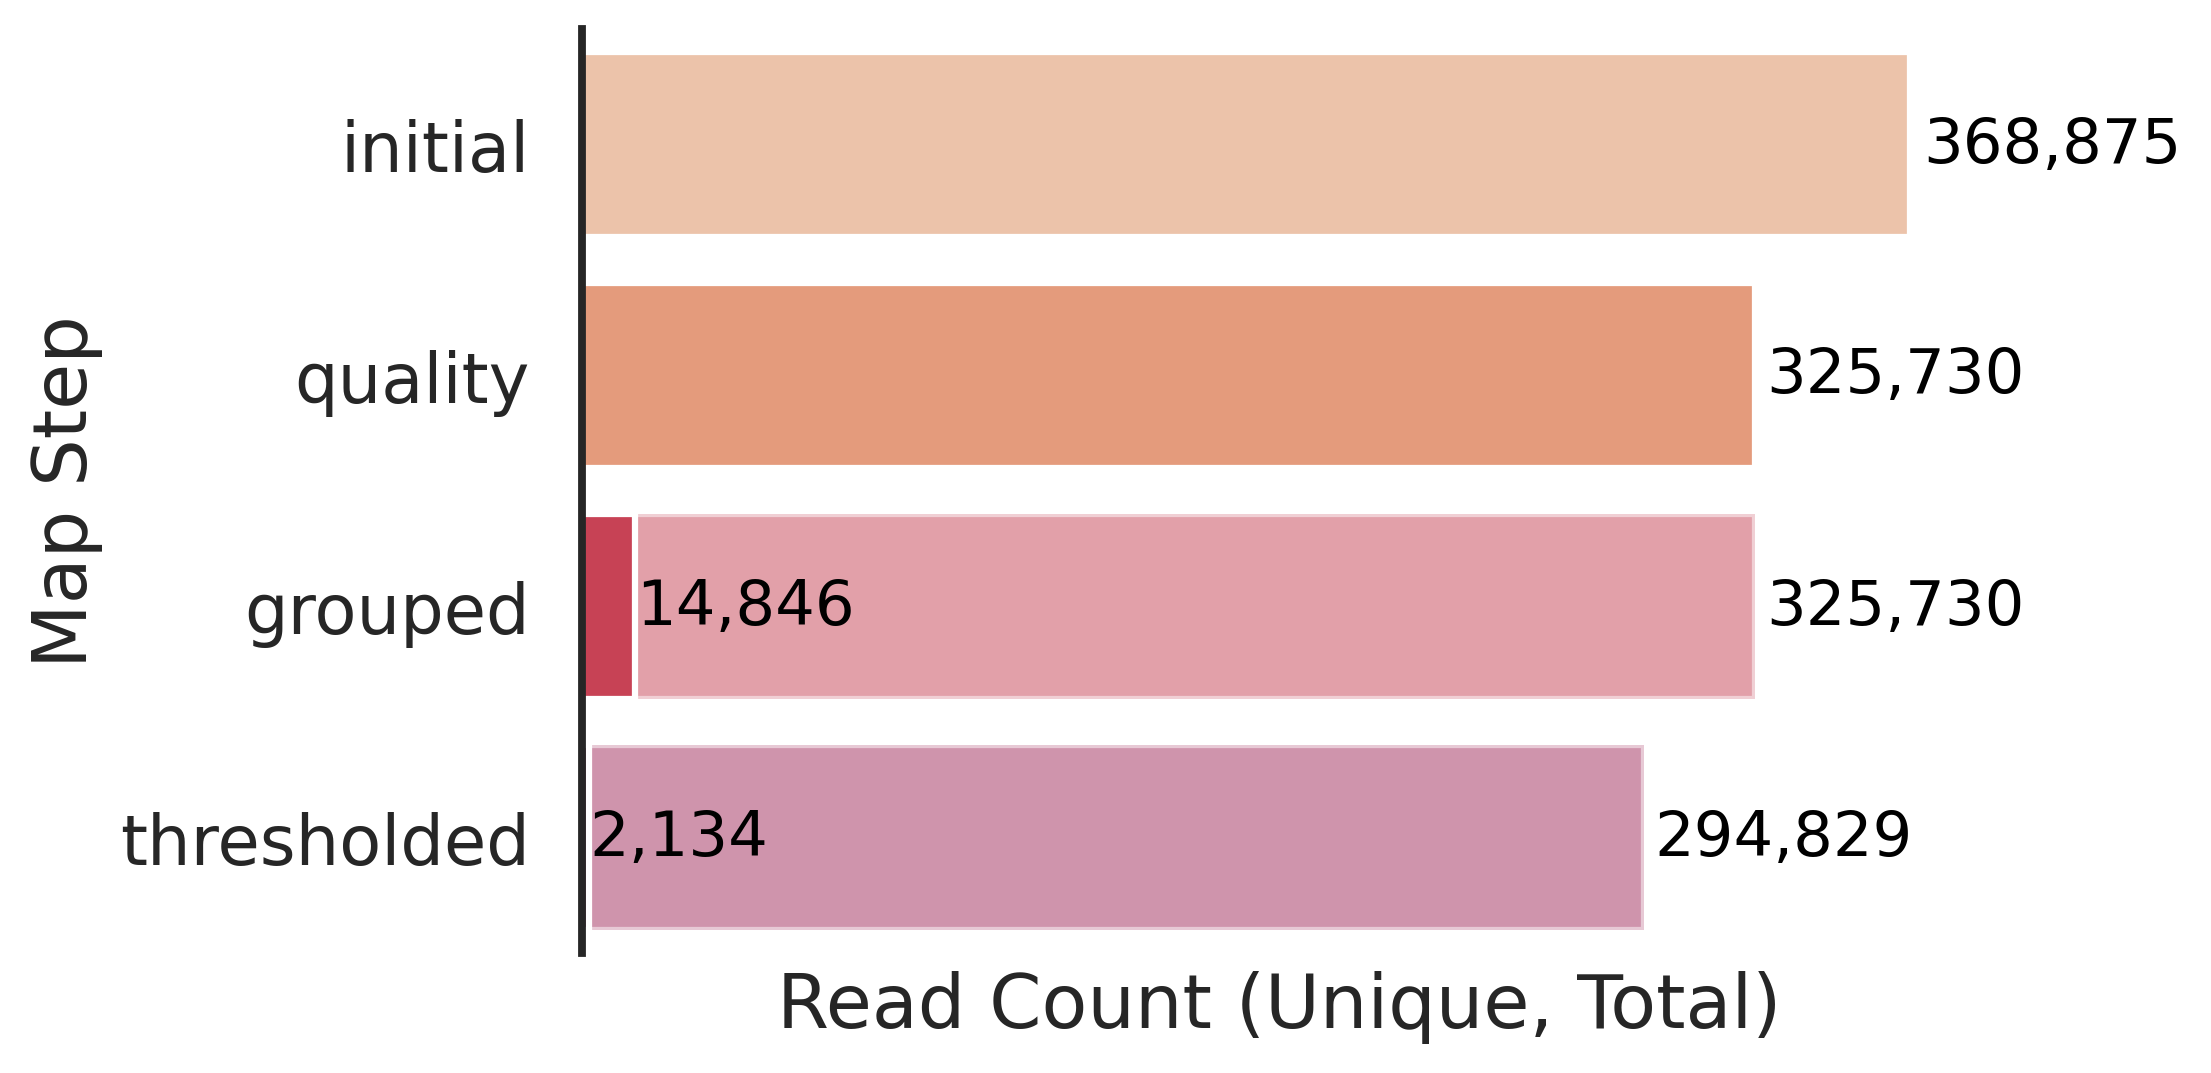

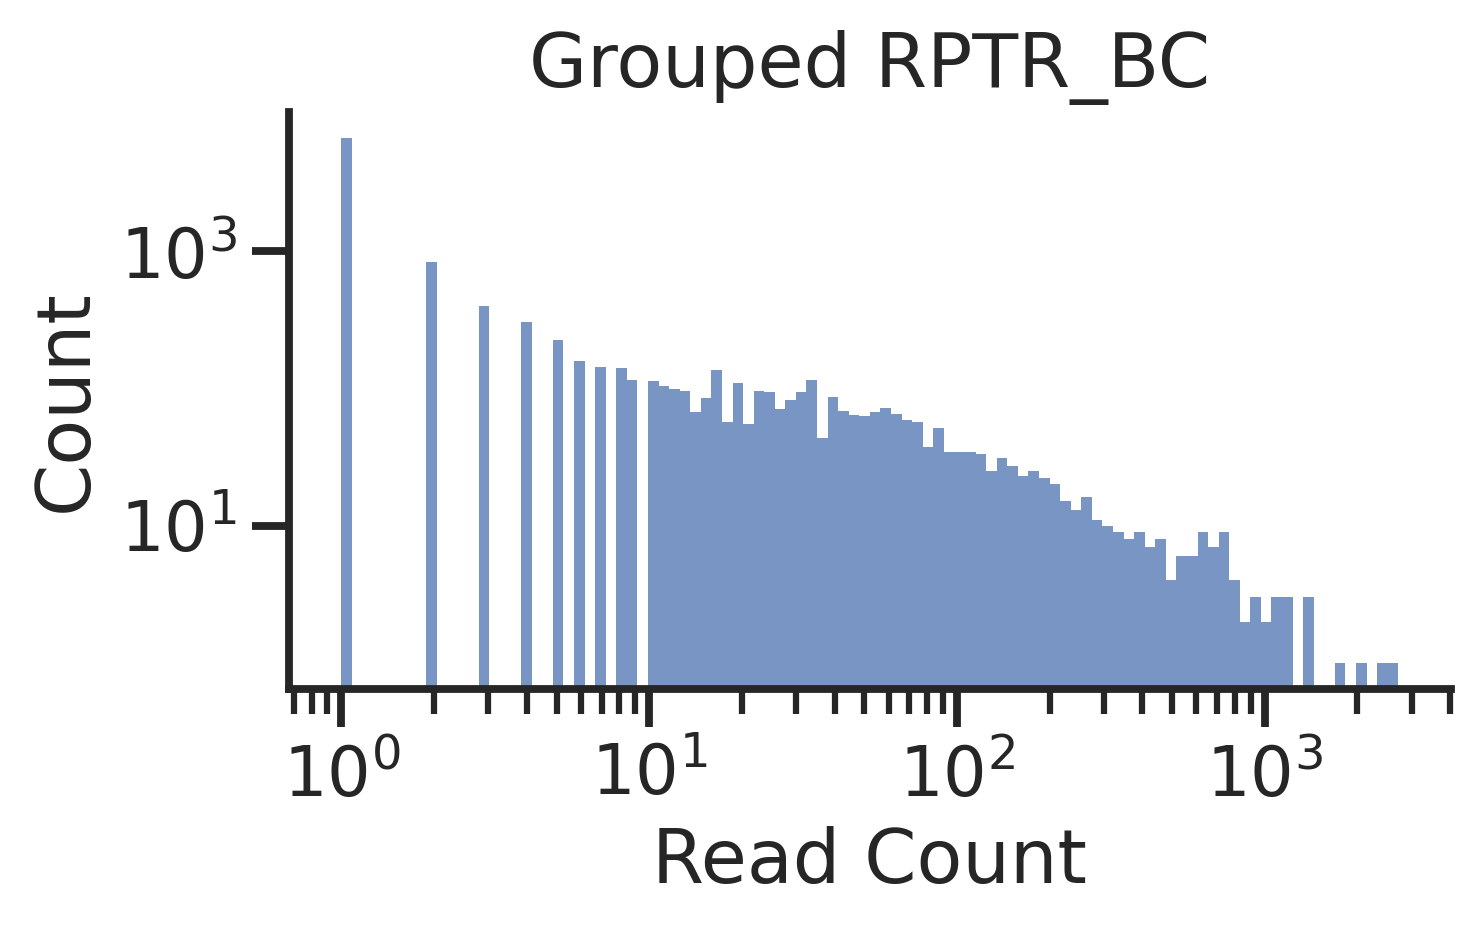

Done in 0.68 seconds.

Thresholding...
Using reads threshold of 20.


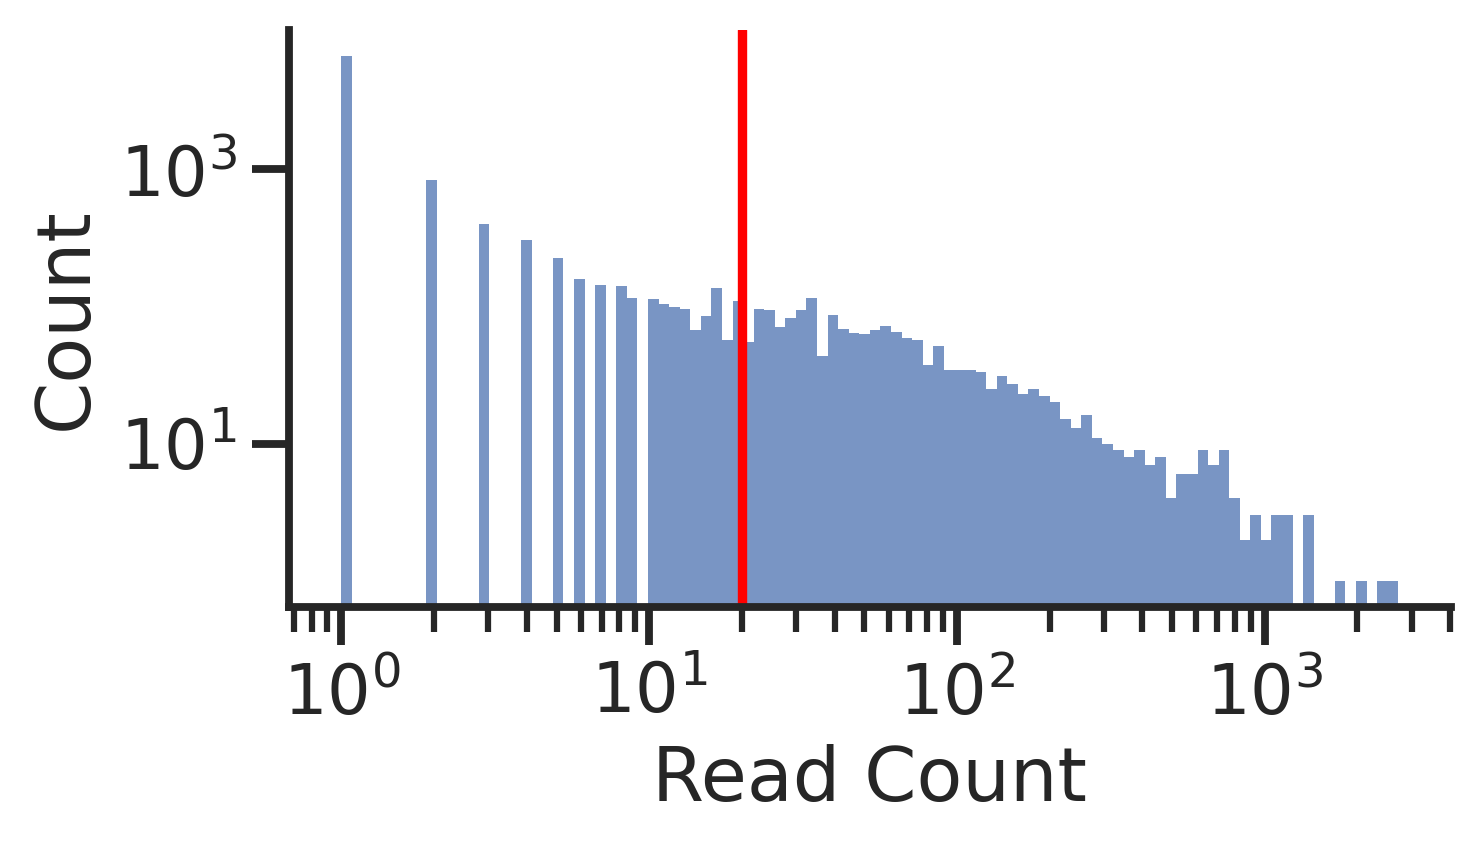

Done in 0.47 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_loss_summary'
Done in 0.01 seconds.

Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27
Reading 1 FASTQ/TXT file(s)...
Done in 1.31 seconds.

Reverse complement of sequences...
Done in 1.72 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.27 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 0.55 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_initial
Total rows: 389472


RPTR_BC  RPTR_BC_qual  Designed
0  CGATTAAATNATGT          True         1
1  CCGTTTCCAGCANG          True         1
2                         False         1
3  TTGAATCATACCNG          True         1
4  TTCTAGGGAACNCG          True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.12 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_quality...


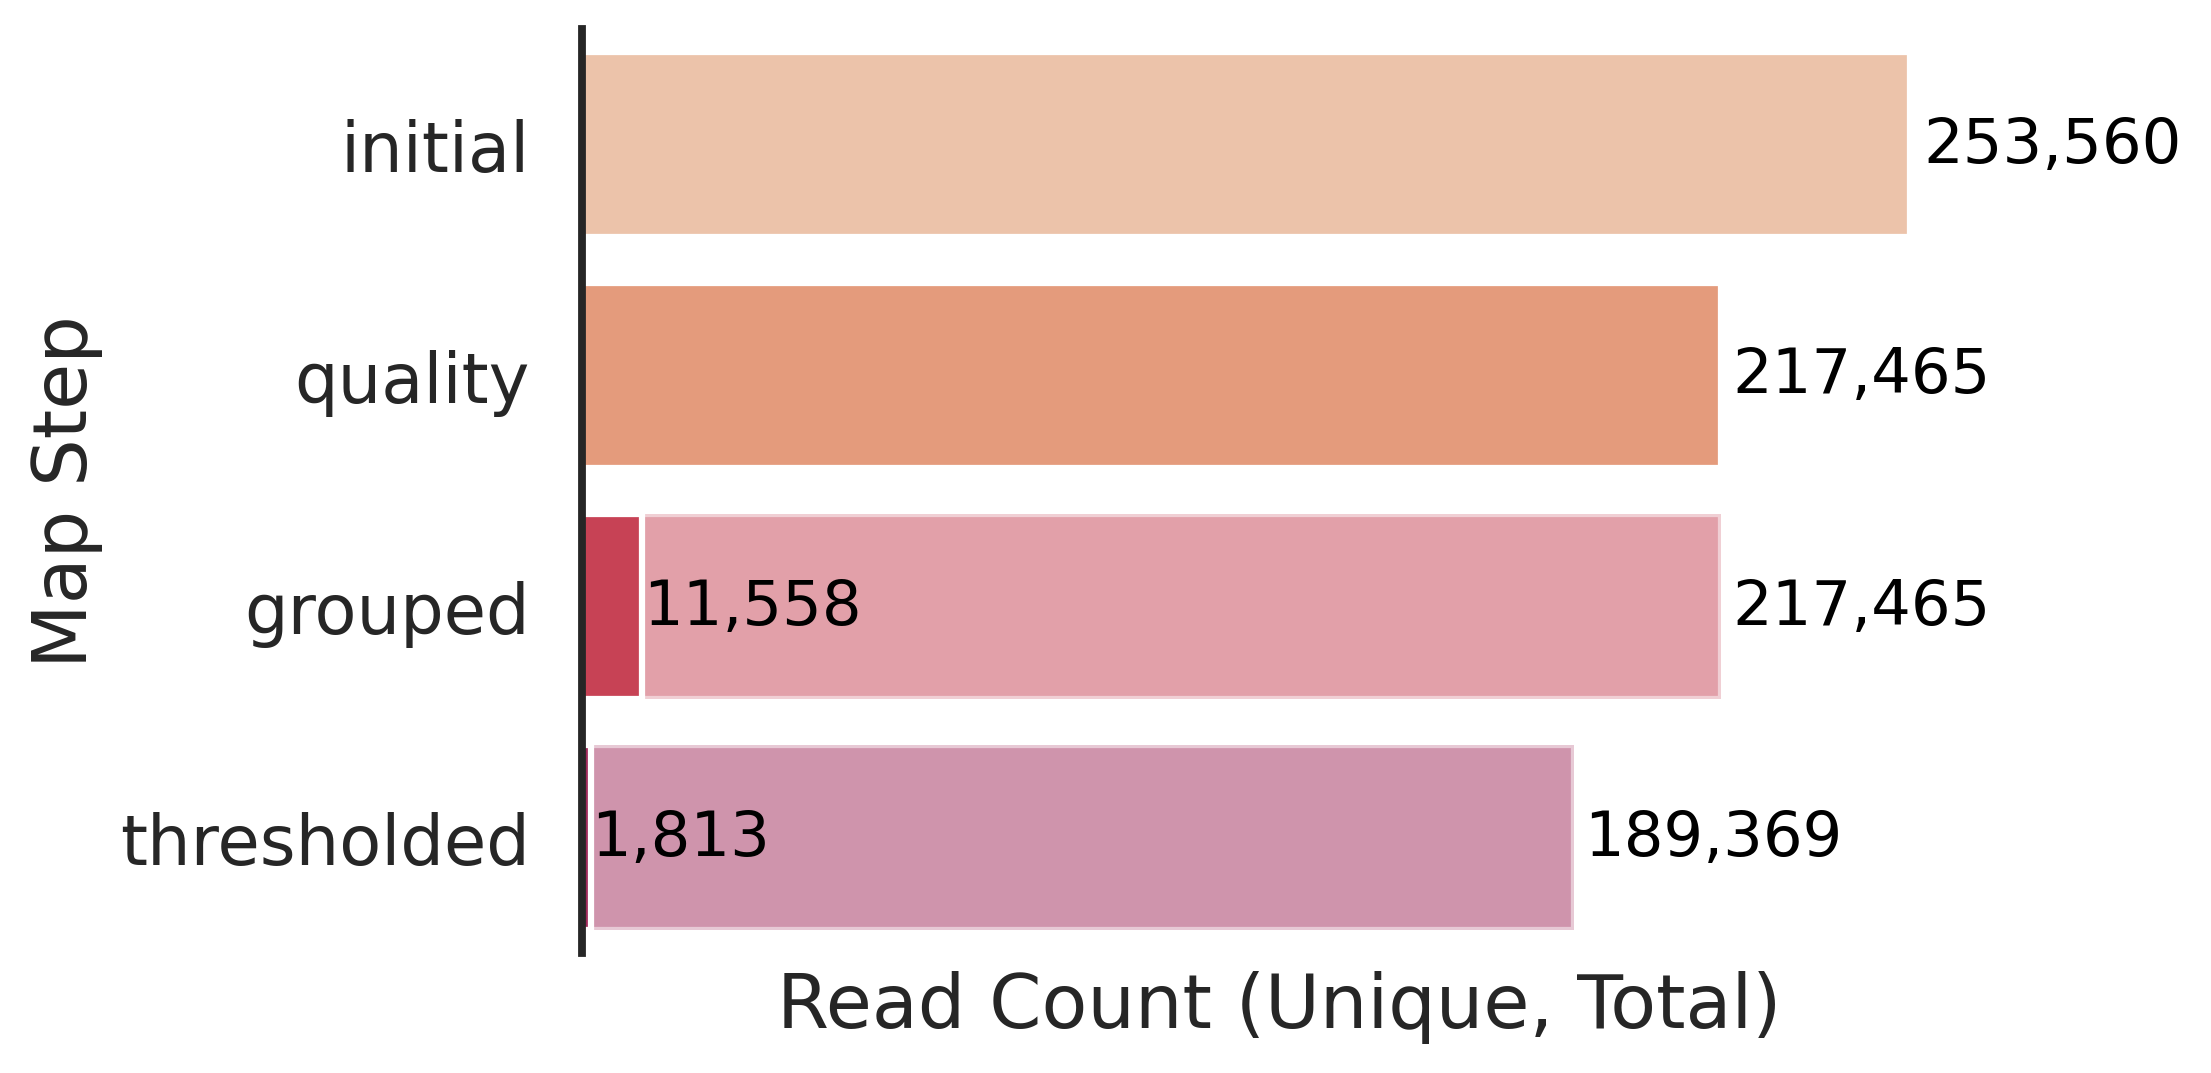

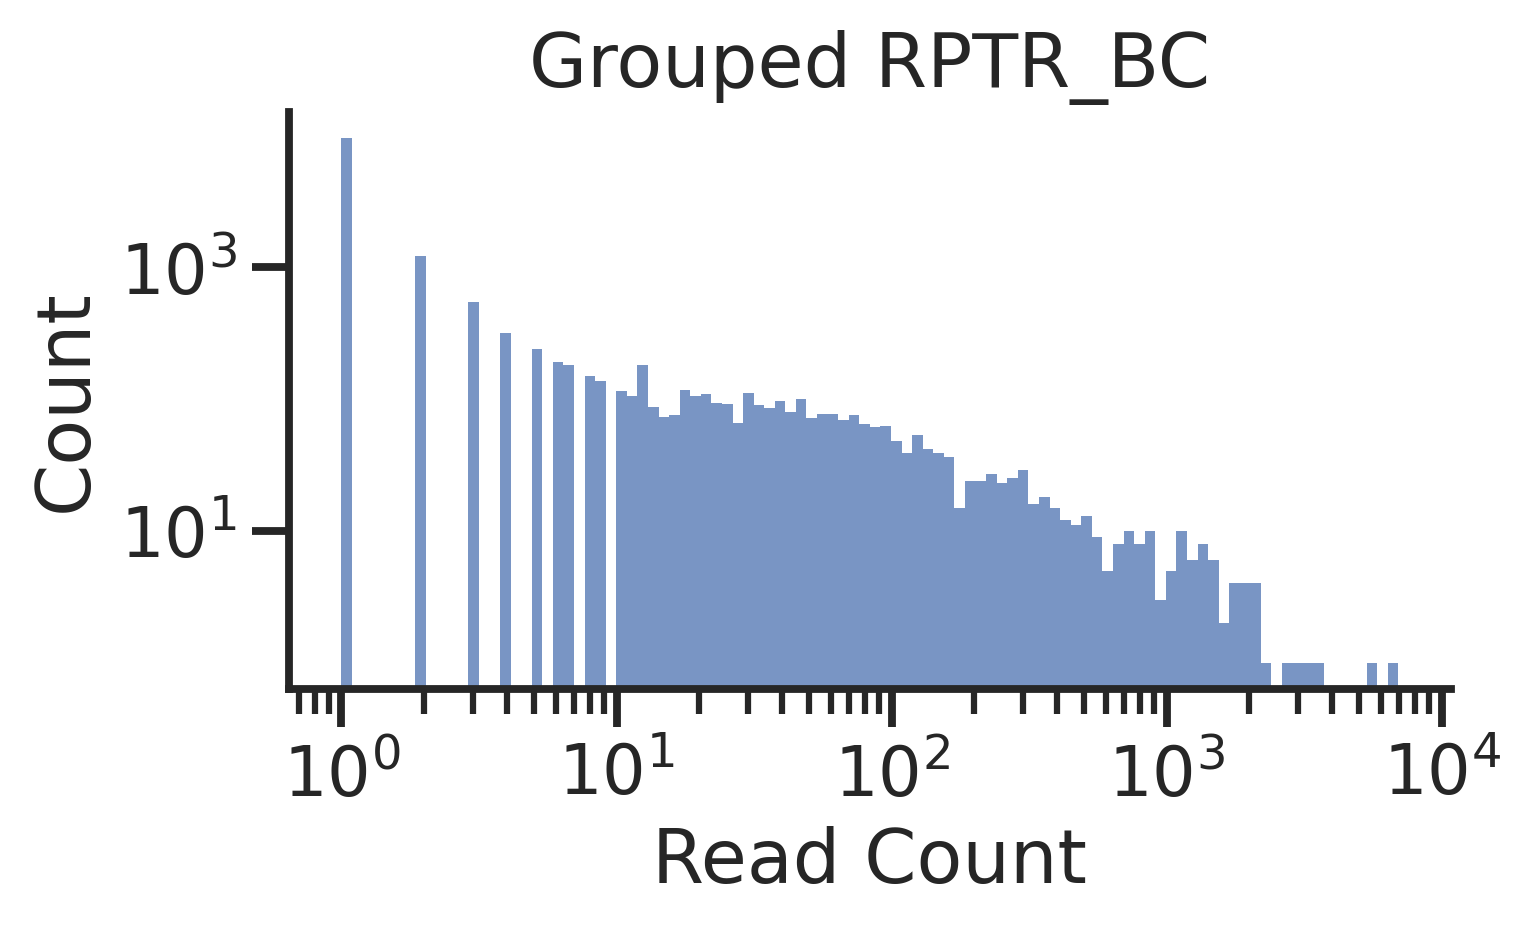

Done in 0.72 seconds.

Thresholding...
Using reads threshold of 20.


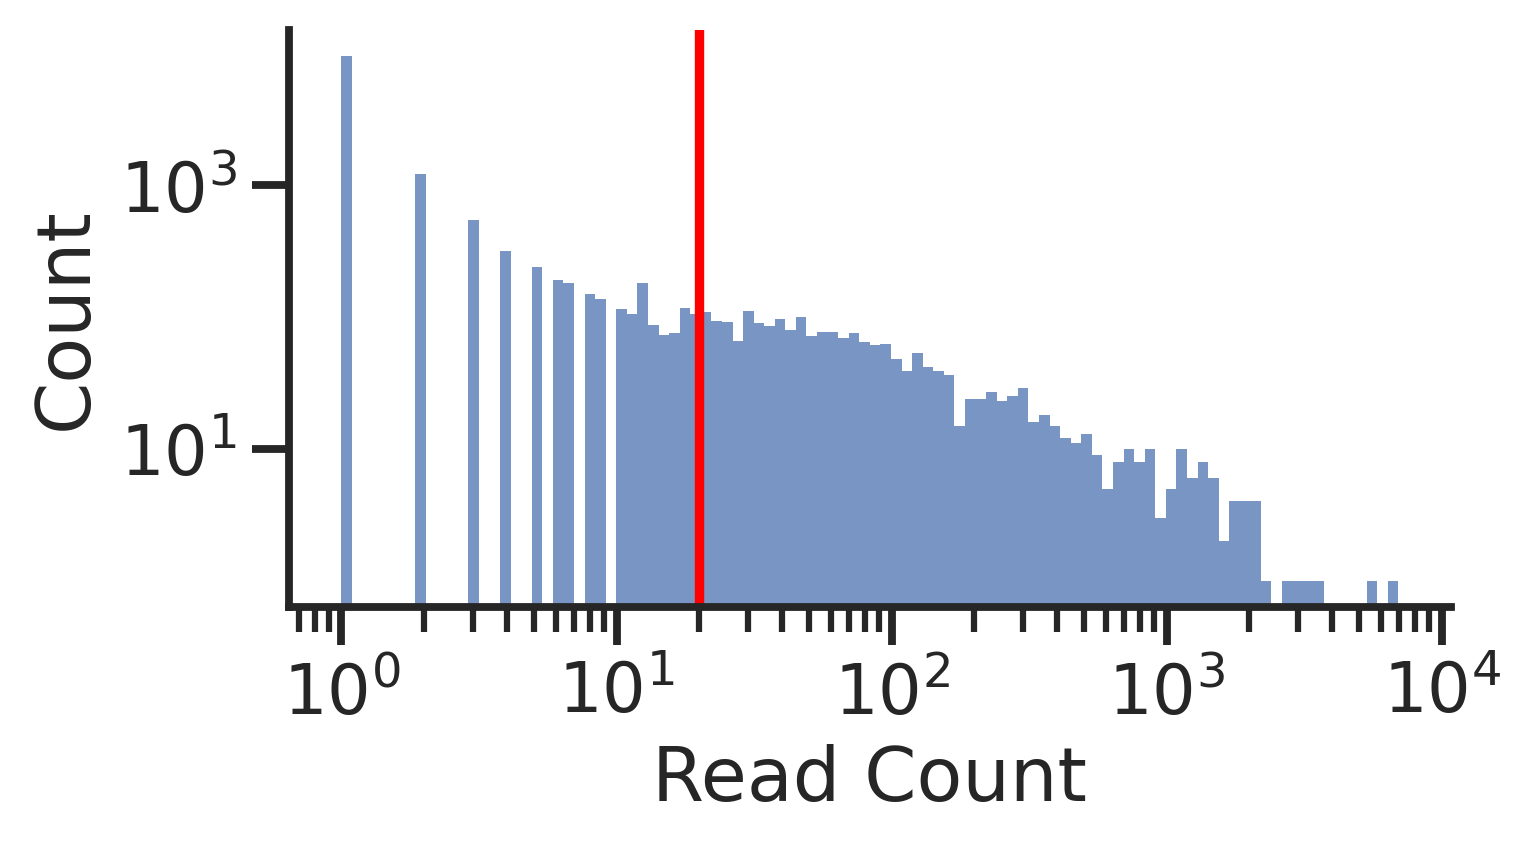

Done in 0.52 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_loss_summary'
Done in 0.02 seconds.

Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23
Reading 1 FASTQ/TXT file(s)...
Done in 1.15 seconds.

Reverse complement of sequences...
Done in 1.70 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.28 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 1.81 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_initial
Total rows: 368519


RPTR_BC  RPTR_BC_qual  Designed
0  GAGGTAAATNAGAT          True         1
1  TATCCCATNTCAGG          True         1
2  TTTGTATCCTTNAG          True         1
3  CCCGAAGTCCNATA          True         1
4  GGACAGTCNGCCAT          True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.11 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_quality...


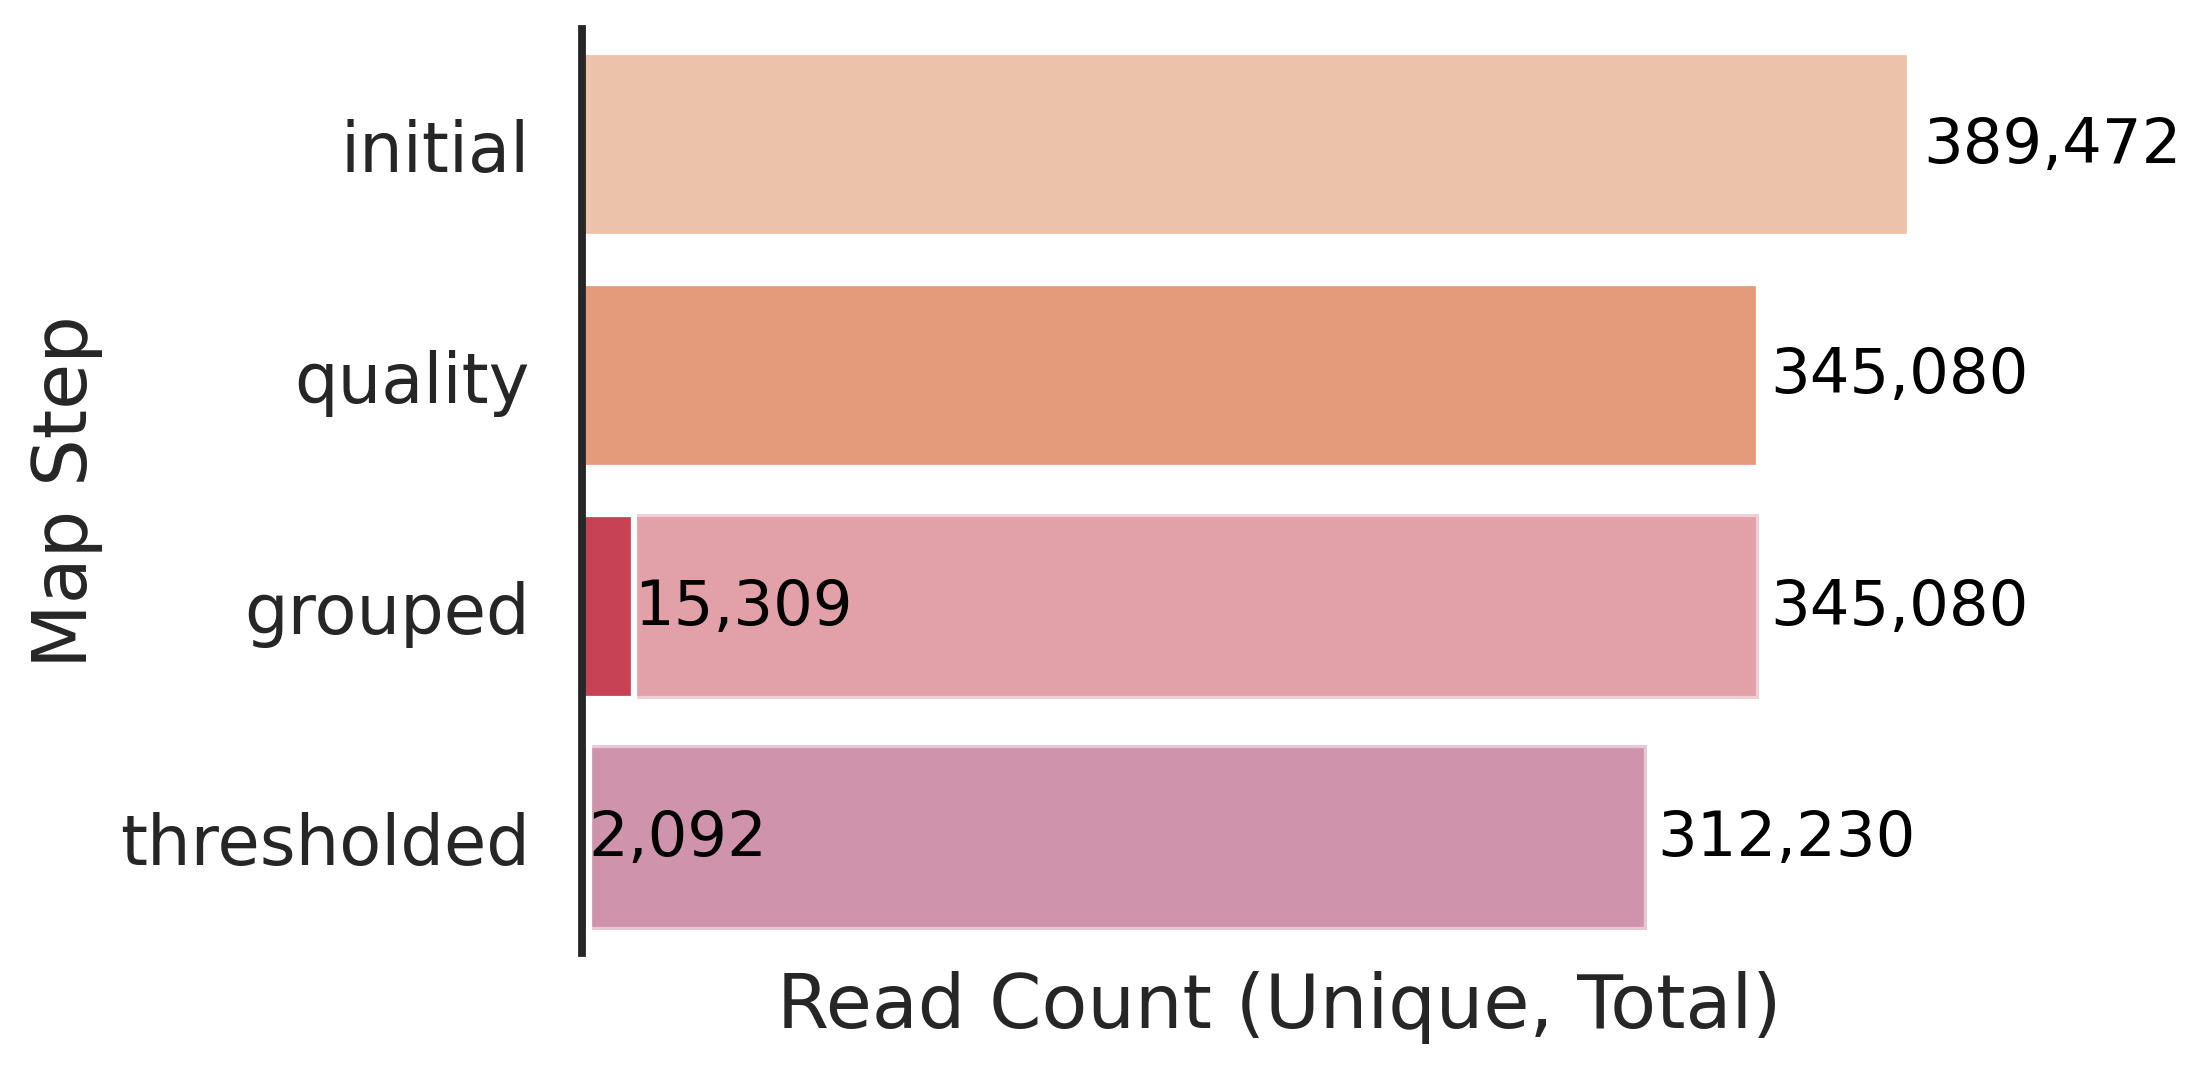

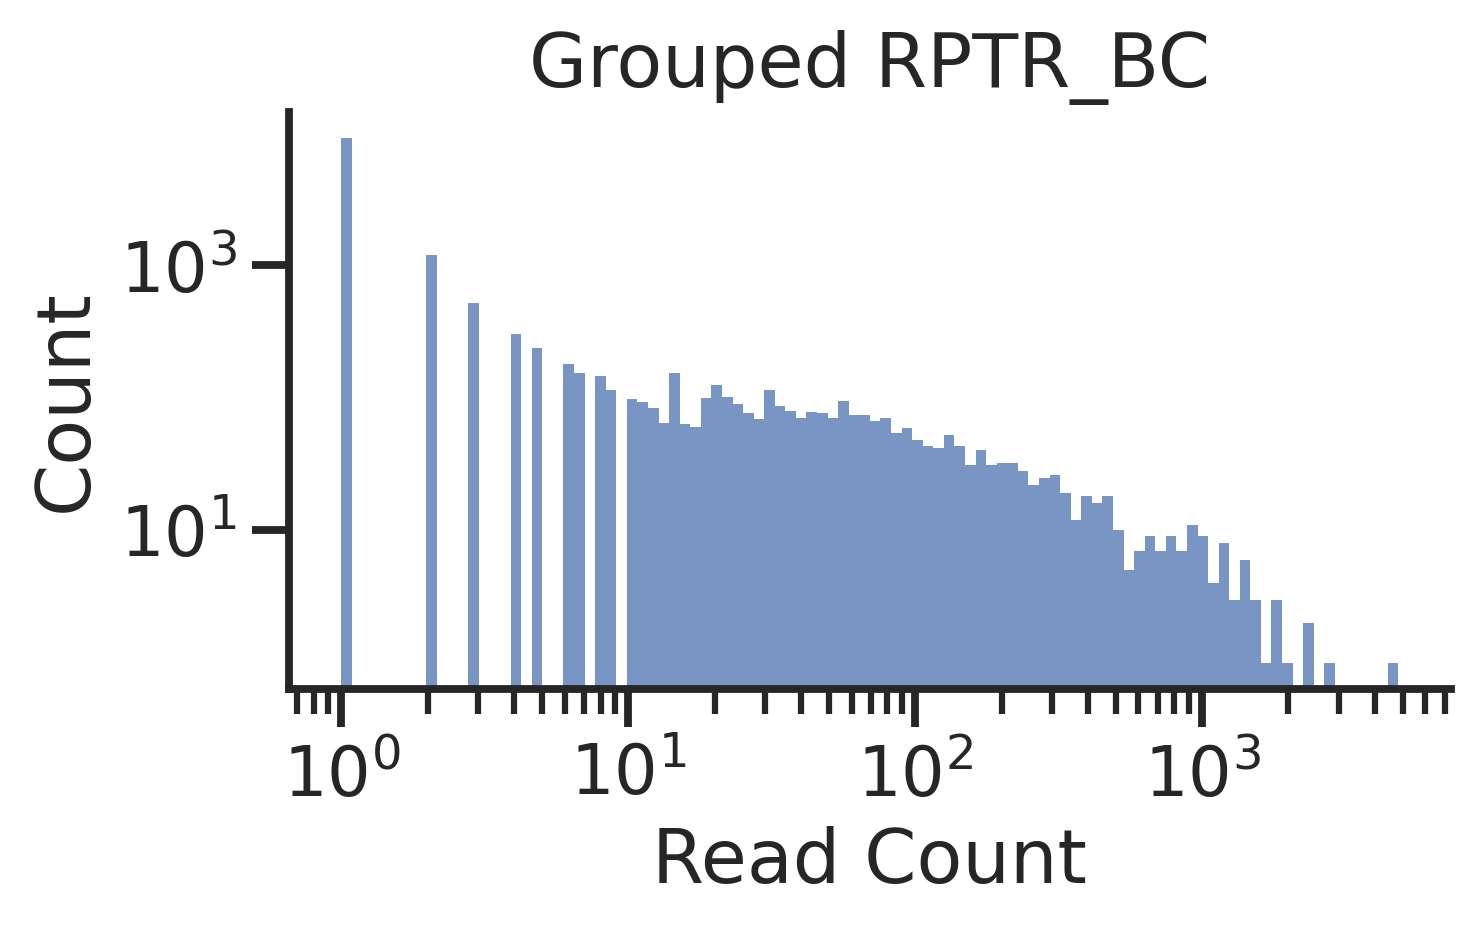

Done in 1.08 seconds.

Thresholding...
Using reads threshold of 20.


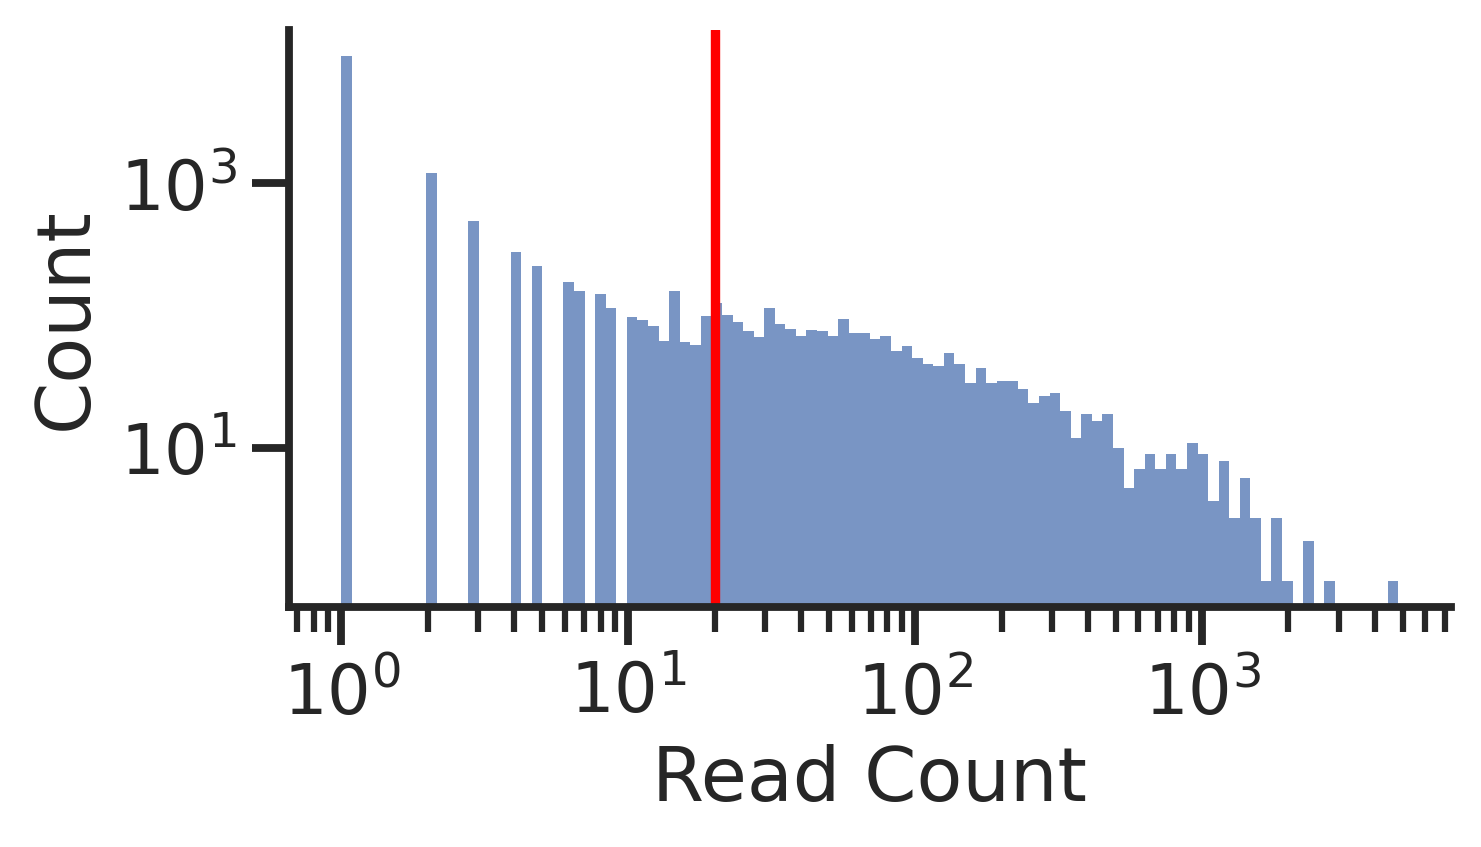

Done in 0.45 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_loss_summary'
Done in 0.01 seconds.



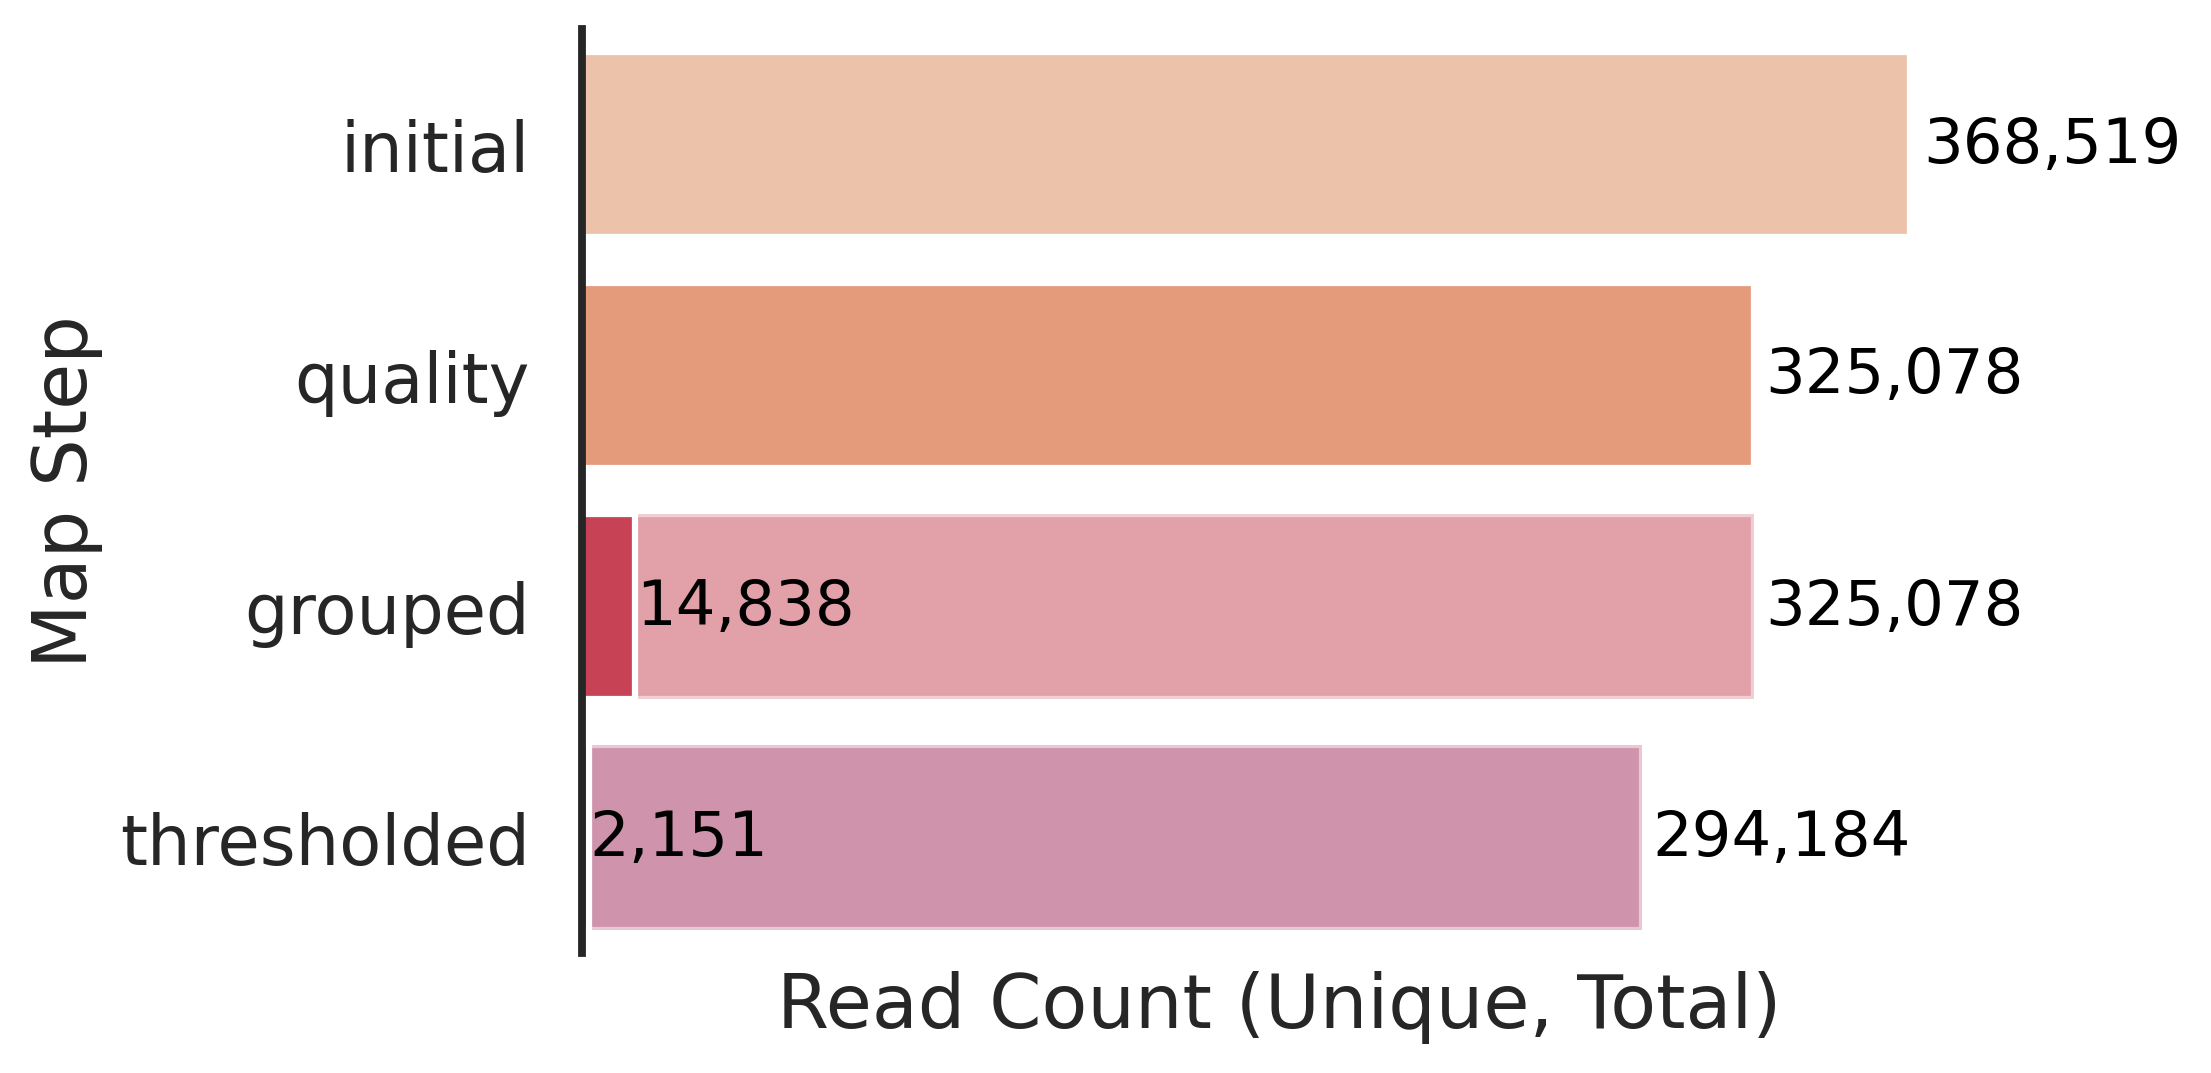

In [27]:
RPTR_objects = [EC_RPTR_BC]

for file_path in yeast_pool_A_RT_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # Get the file naeme to use for output
    file_output_path = os.path.join(yeast_pool_A_output_path, f"trebl_experiment_yeast_pool_A_{name_only}")
    print(file_output_path)

    # Extract UMIs and barcodes from reads
    bc_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_A_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = RPTR_objects,
                                       reverse_complement = True)
    umi_map = bc_mapper.create_map()
    display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=RPTR_objects,
                                        column_pairs = [],
                                        map_order = ['quality', 'grouped', 'thresholded'],
                                        step_name=f"trebl_experiment_yeast_pool_A_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = False,
                                        reads_threshold = 20)
    refiner.refine_map_from_db()
    refiner.plot_loss()
    

In [29]:
tables = refiner.show_tables()

yeast_pool_A_RPTR_result_tables = []

for table in tables:
    if "trebl" in table[0] and "thresholded" in table[0] and "RPTR" in table[0]:
        print(table[0])
        df = refiner.get_map_df(table[0])
        df["sample"] = table[0][38:]
        yeast_pool_A_RPTR_result_tables.append(df)

yeast_pool_A_RPTR_result_df = pd.concat(yeast_pool_A_RPTR_result_tables)
yeast_pool_A_RPTR_result_df

trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_thresholded


RPTR_BC  count  RPTR_BC_qual  Designed  \
0     CCTGGGATATGAGT   1162          True         1   
1     TGGGCCGGAATTGC   1054          True         1   
2     GCTTCTCCGCACAT   1032          True         1   
3     GTCCAGTTTAGTGA    980          True         1   
4     TTATTTAGAAGTTT    878          True         1   
...              ...    ...           ...       ...   
1808  TCGTACGTCAAGCT     21          True         1   
1809  AGGGGCCAGCACTA     21          True         1   
1810  GATCATATACACTG     21          True         1   
1811  AGCCTAAATGCTAA     21          True         1   
1812  CTAACGCGAACTAC     21          True         1   

                                                 sample  
0     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
1     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
2     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
3     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
4     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
...                                                 ...  
1808  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  
1809  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  
1810  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  
1811  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  
1812  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  

[10451 rows x 5 columns]

## Yeast Pool B

In [30]:
! mkdir "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B"

In [37]:
yeast_pool_B_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/*fastq")
yeast_pool_B_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/RPTR_reads/*fastq")
yeast_pool_B_output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B" # May need to change to your directory due to writing permissions

In [41]:
print(len(yeast_pool_B_AD_seq_files))
yeast_pool_B_AD_seq_files

19


['/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/AD_2_180_S49.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/AD_4_15_S59.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/AD_4_5_S57.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/AD_3_10_S52.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/AD_3_15_S53.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/AD_2_10_S46.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024

AD_2_180_S49
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B/trebl_experiment_yeast_pool_B_AD_2_180_S49
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.69 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.42 minutes.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 29.42 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 15.64 seconds.

Mapping complete.
trebl_experiment_yeast_pool_B_AD_2_180_S49_AD_AD_BC_initial
Total rows: 37906677


AD  AD_qual        AD_BC  \
0  AATACTCAACAGAATGCTAATGTTGAACATTCTCCAGCTGAGAAAT...     True  CAGATGCGTAT   
1  CCAAATCAACAAGACTTTGTCTTGTTTGATCAACCAATTAAACCAA...     True  GGCCCCCGTCC   
2  TCTACTGTTTCTGAATGTCCAAGAAGGAAATCTTCTGGTTCTCCAG...     True  TCCAAATCGTC   
3  AGAAGGAAACCAGGTAATTCTCCACCATCTACTAGACATTCTTCTG...     True  ACATAGCAGGA   
4  CCATTGTTTGAAGCTCCAACTTCTCAAGCTGAAACTCCAGCTTCTT...     True  TAAGGGCATTA   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_AD_2_180_S49_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_AD_2_180_S49_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_2_180_S49_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 38.60 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_2_180_S49_AD_AD_BC_designed — kept only Designed == 1.
Done in 10.30 seconds.

Grouping trebl_experiment_yeast_pool_B_AD_2_180_S49_AD_AD_BC_designed...


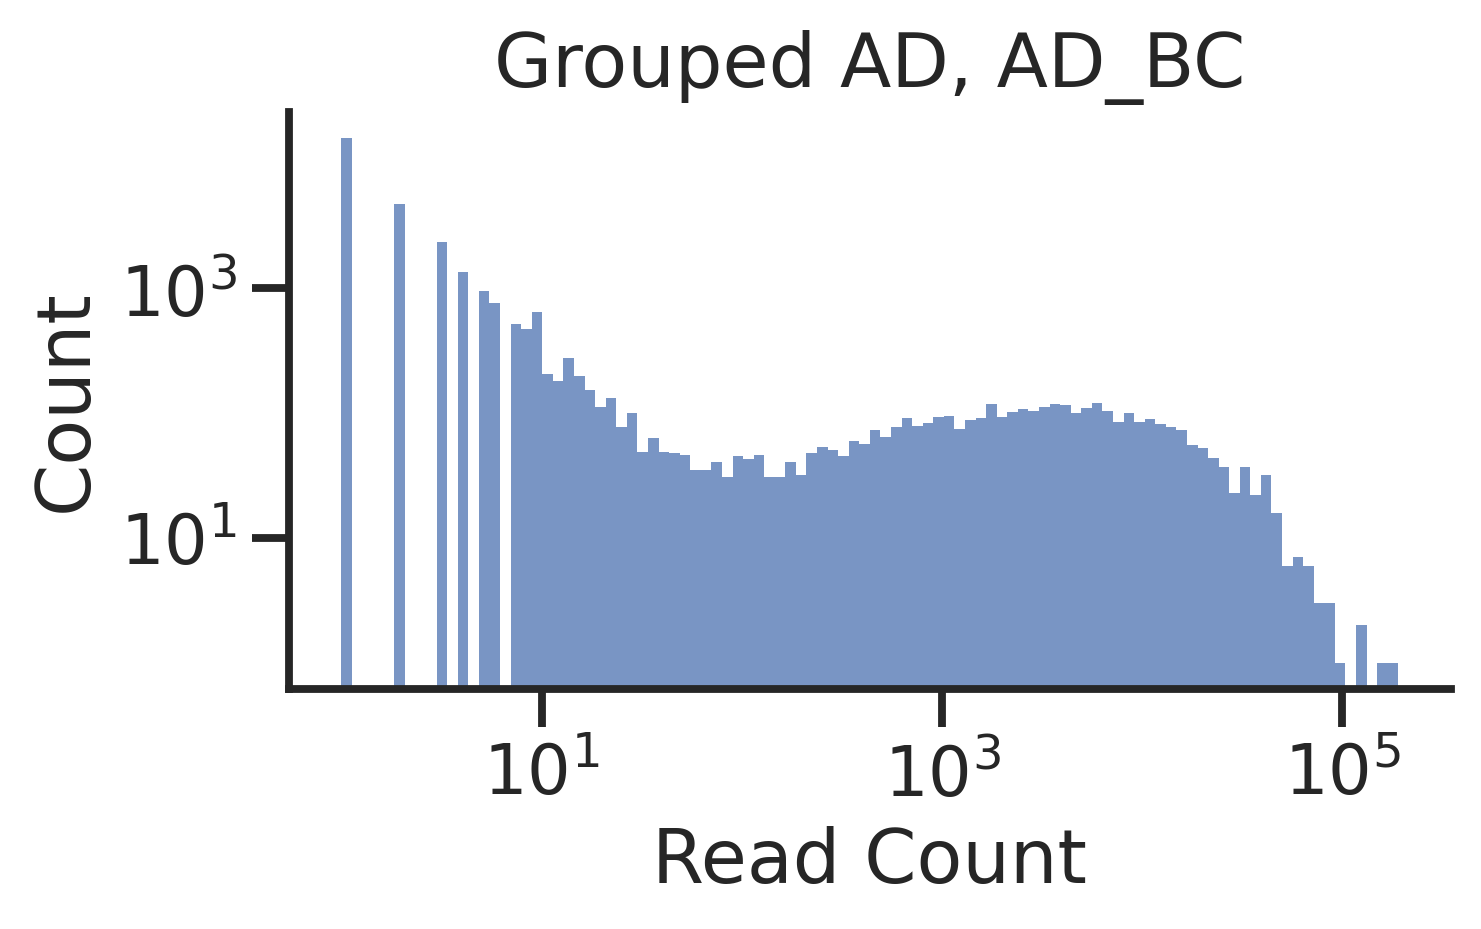

Done in 0.91 seconds.

Thresholding...
Using reads threshold of 100.


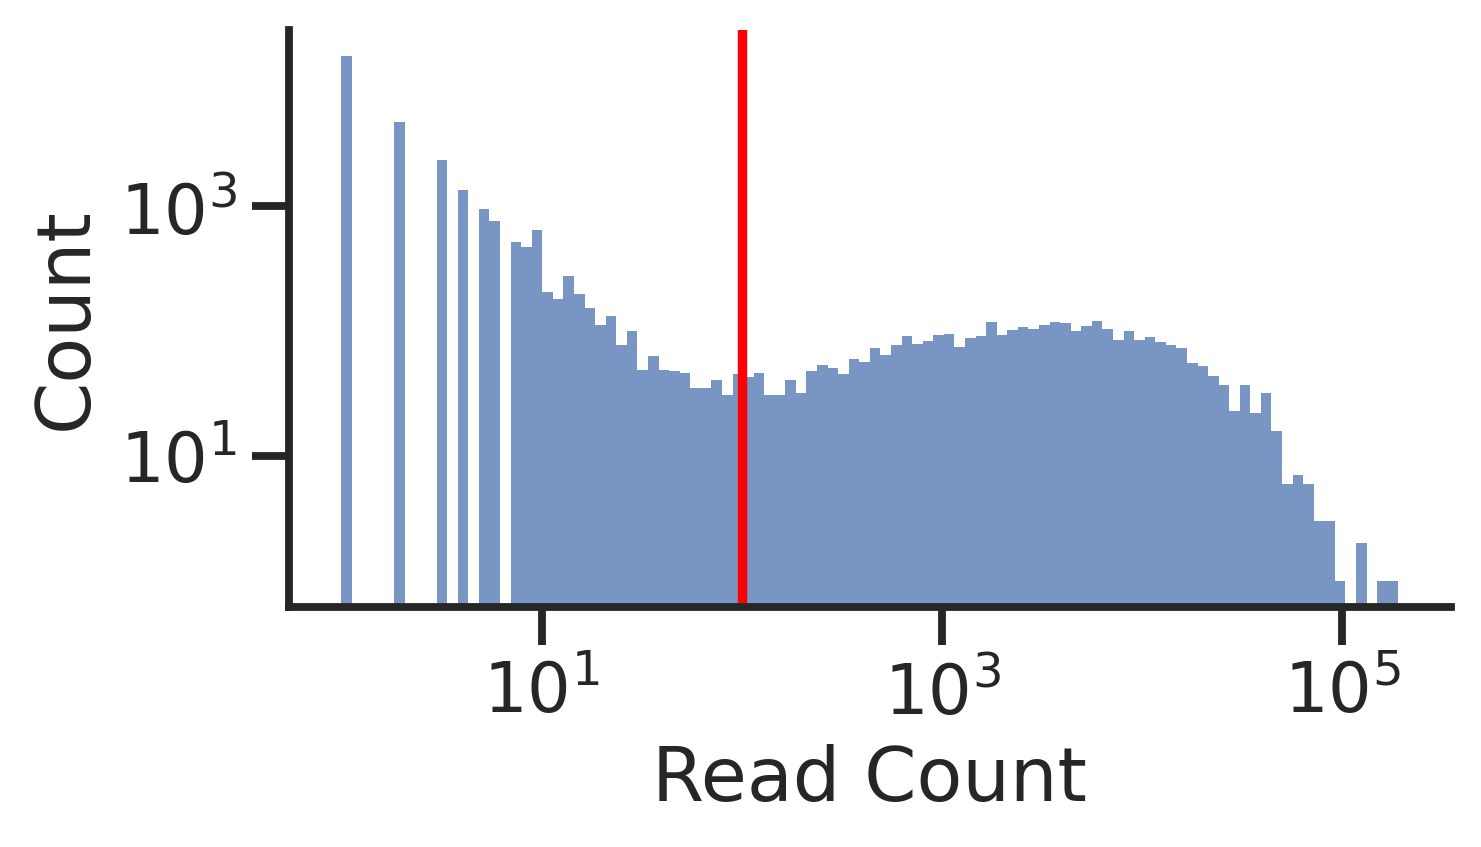

Done in 0.34 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_B_AD_2_180_S49_AD_AD_BC_loss_summary'
Done in 0.75 seconds.

AD_4_15_S59
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B/trebl_experiment_yeast_pool_B_AD_4_15_S59
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.38 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 24.63 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 19.00 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 11.05 seconds.

Mapping complete.
trebl_experiment_yeast_pool_B_AD_4_15_S59_AD_AD_BC_initial
Total rows: 32828123


AD  AD_qual        AD_BC  \
0  CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...     True  ATATACACTTC   
1  ATTGAAGTTGCTTCTTGGGCTCATGAATTTCAAAGATTGGCTCCAA...     True  CTCTACGTTTT   
2  TTGATTGGTAATGGTTATTCTGATGATGATATTGTTGATGTTGTTG...     True  CGCTCCATCAC   
3  GATCAATCTCCAGGTATCTTTGCTGGTGATGCTGTTATGGCTTCTG...     True  GTTTCTCGCTA   
4  GCTAGAATTTCTACTGTTCCACAACCACCACAACCAAGAAGAGTTT...     True  AGCGAGTACGA   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_AD_4_15_S59_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_AD_4_15_S59_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_4_15_S59_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 28.38 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_4_15_S59_AD_AD_BC_designed — kept only Designed == 1.
Done in 16.65 seconds.

Grouping trebl_experiment_yeast_pool_B_AD_4_15_S59_AD_AD_BC_designed...


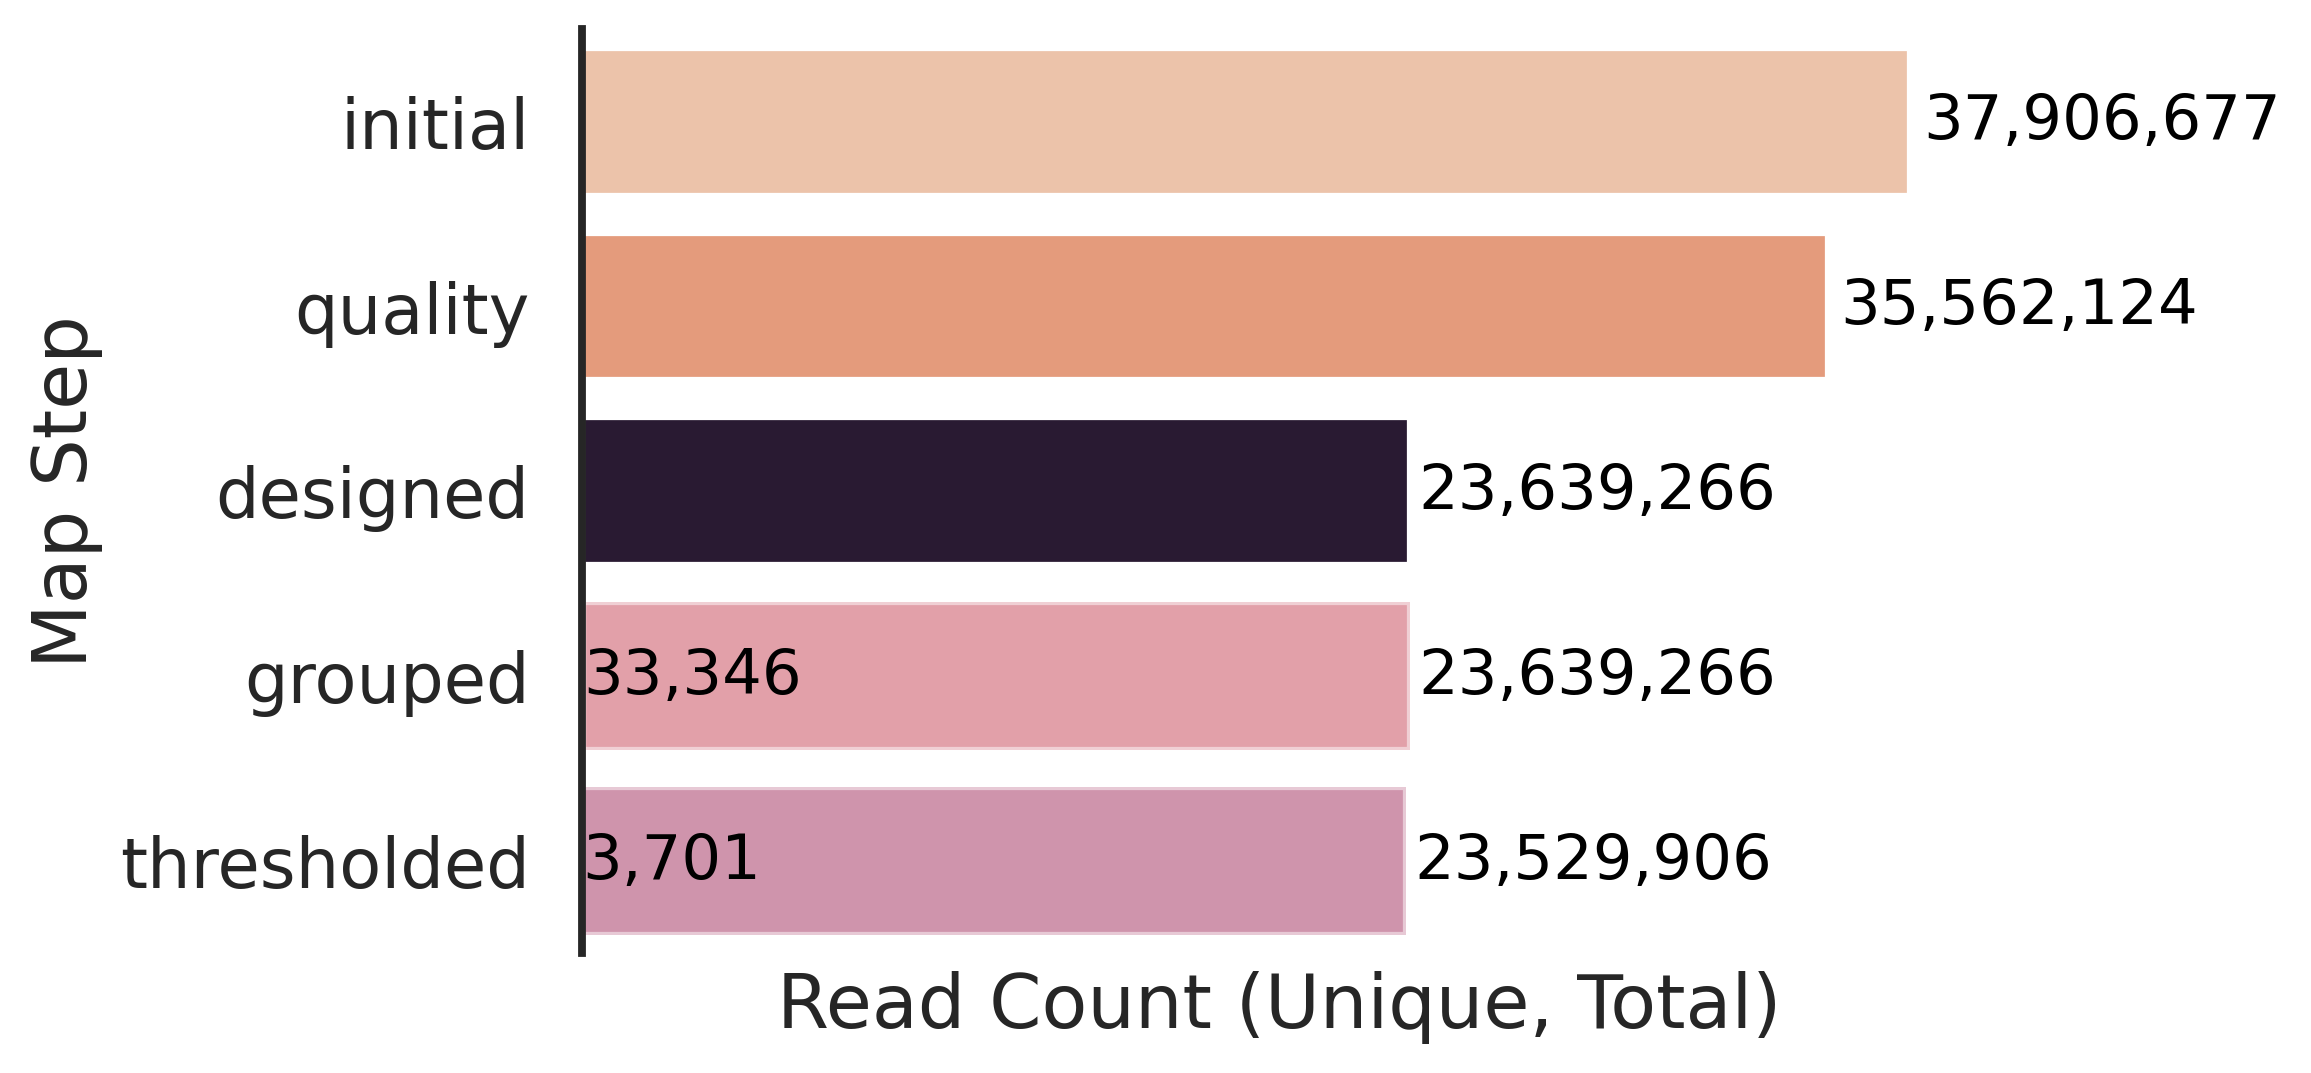

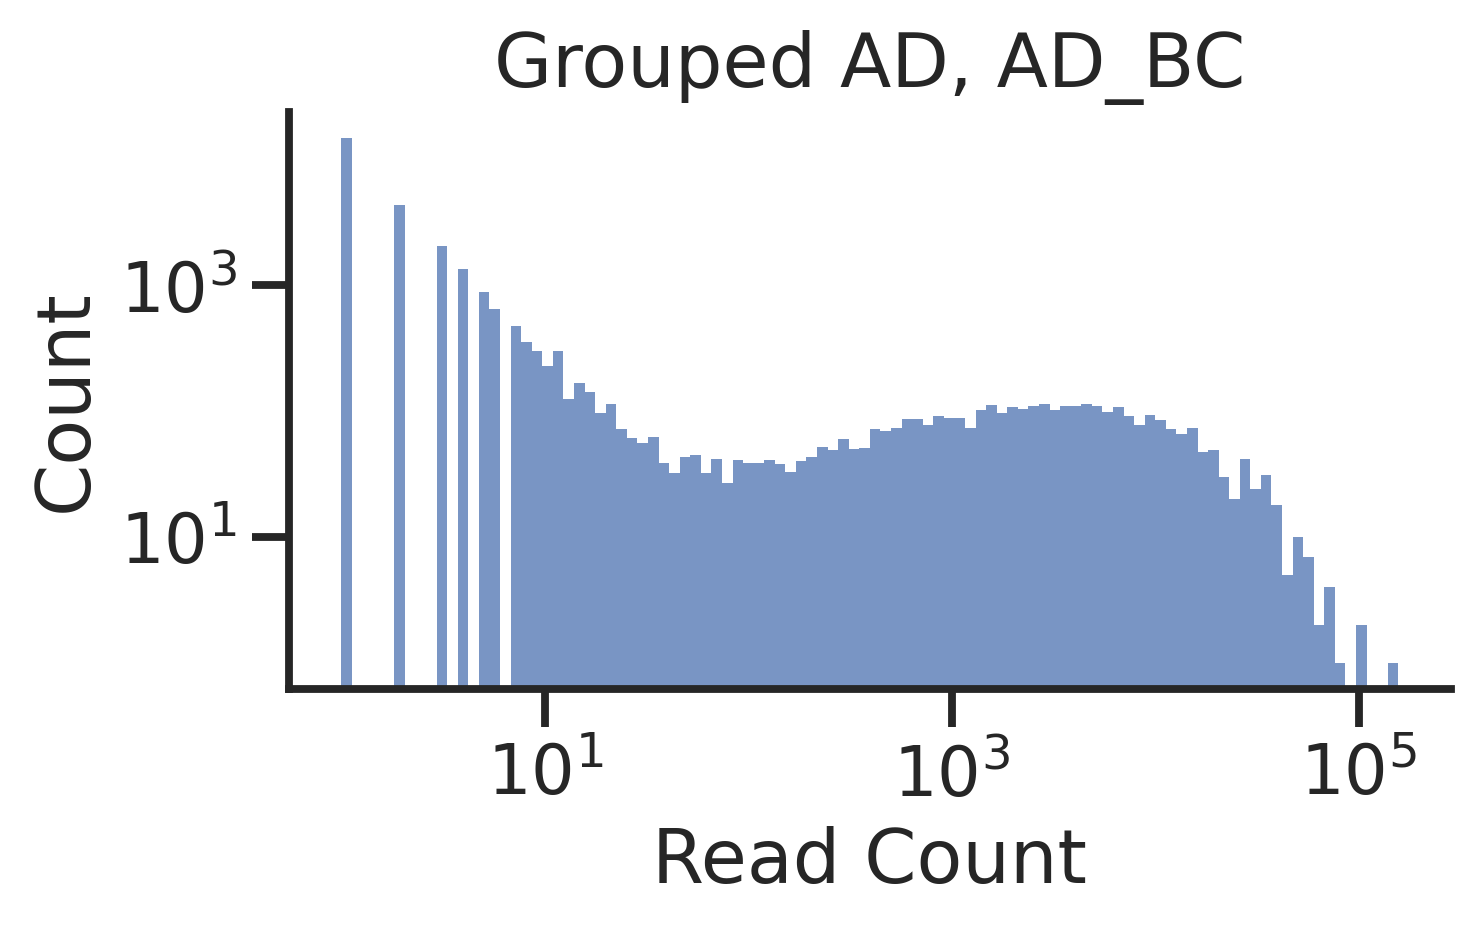

Done in 0.95 seconds.

Thresholding...
Using reads threshold of 100.


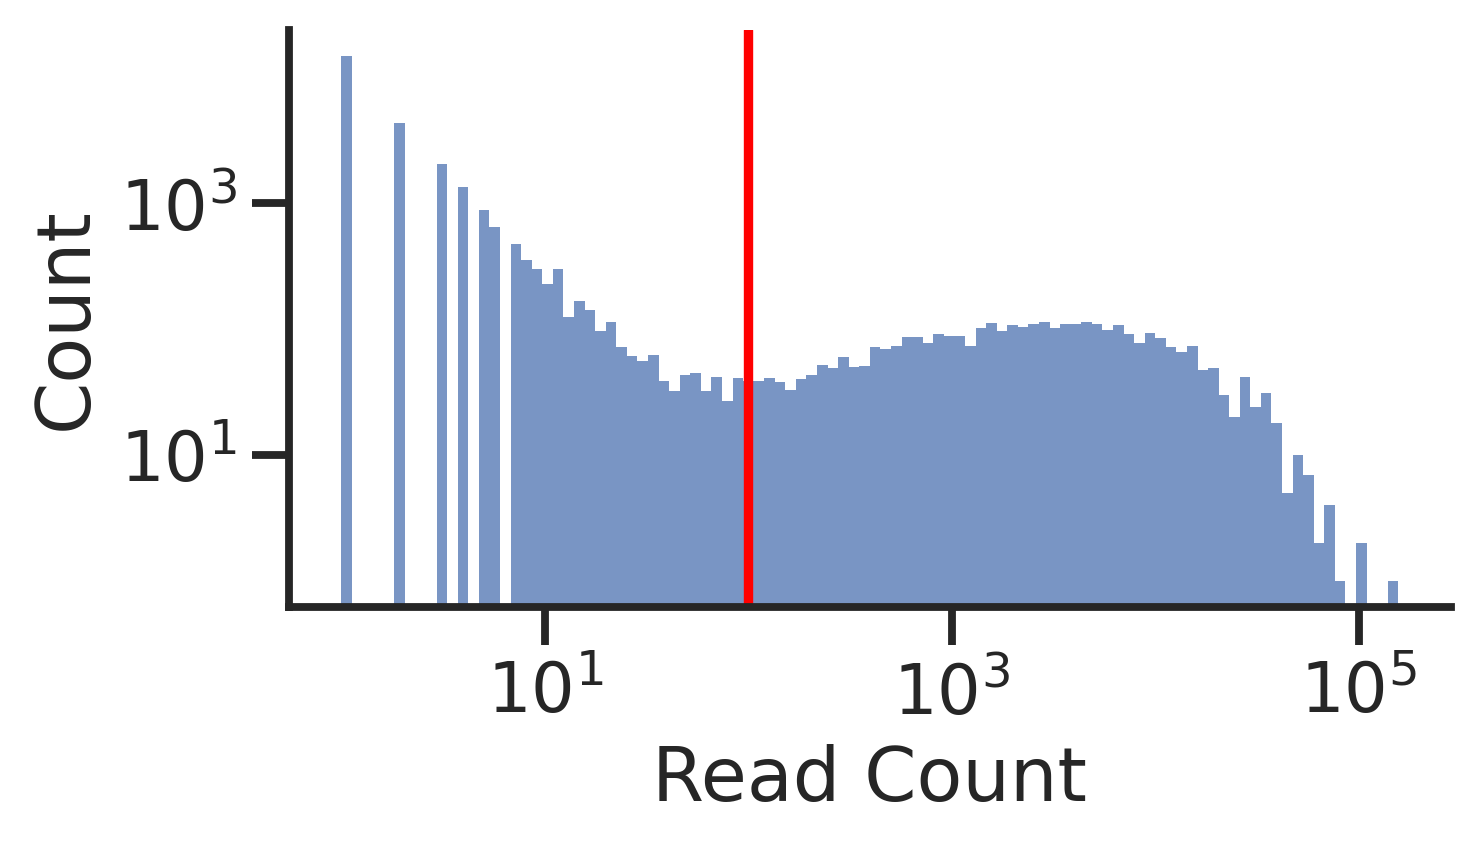

Done in 0.34 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_B_AD_4_15_S59_AD_AD_BC_loss_summary'
Done in 0.67 seconds.

AD_4_5_S57
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B/trebl_experiment_yeast_pool_B_AD_4_5_S57
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.24 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 21.35 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 18.74 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 11.31 seconds.

Mapping complete.
trebl_experiment_yeast_pool_B_AD_4_5_S57_AD_AD_BC_initial
Total rows: 29564584


AD  AD_qual        AD_BC  \
0  ATTGTTGTTGATGATGCTGAAGATTCTGTTGCTGTTAAGAGAGCTA...     True  AGACACCCTTC   
1  GCTATTGAATCTACTGAAGAAGTTTCTTTGGCTCCATCTAATTTGG...     True  CACGATTCGAA   
2  TTTGAACATTCTAATCAACCACATATTTCATTTGAAGATCAACCAT...     True  ATAAGAACCGC   
3  CCAACTCCATCTGCTCCAGCTTCTAGACCAGCTAGAAGAAGAGCTA...     True  CATAGTCTCCC   
4  CCAACTCCATCTGCTCCAGCTTCTAGACCAGCTAGAAGAAGAGCTA...     True  CATAGTCTCCC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_AD_4_5_S57_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_AD_4_5_S57_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_4_5_S57_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 29.15 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_4_5_S57_AD_AD_BC_designed — kept only Designed == 1.
Done in 14.09 seconds.

Grouping trebl_experiment_yeast_pool_B_AD_4_5_S57_AD_AD_BC_designed...


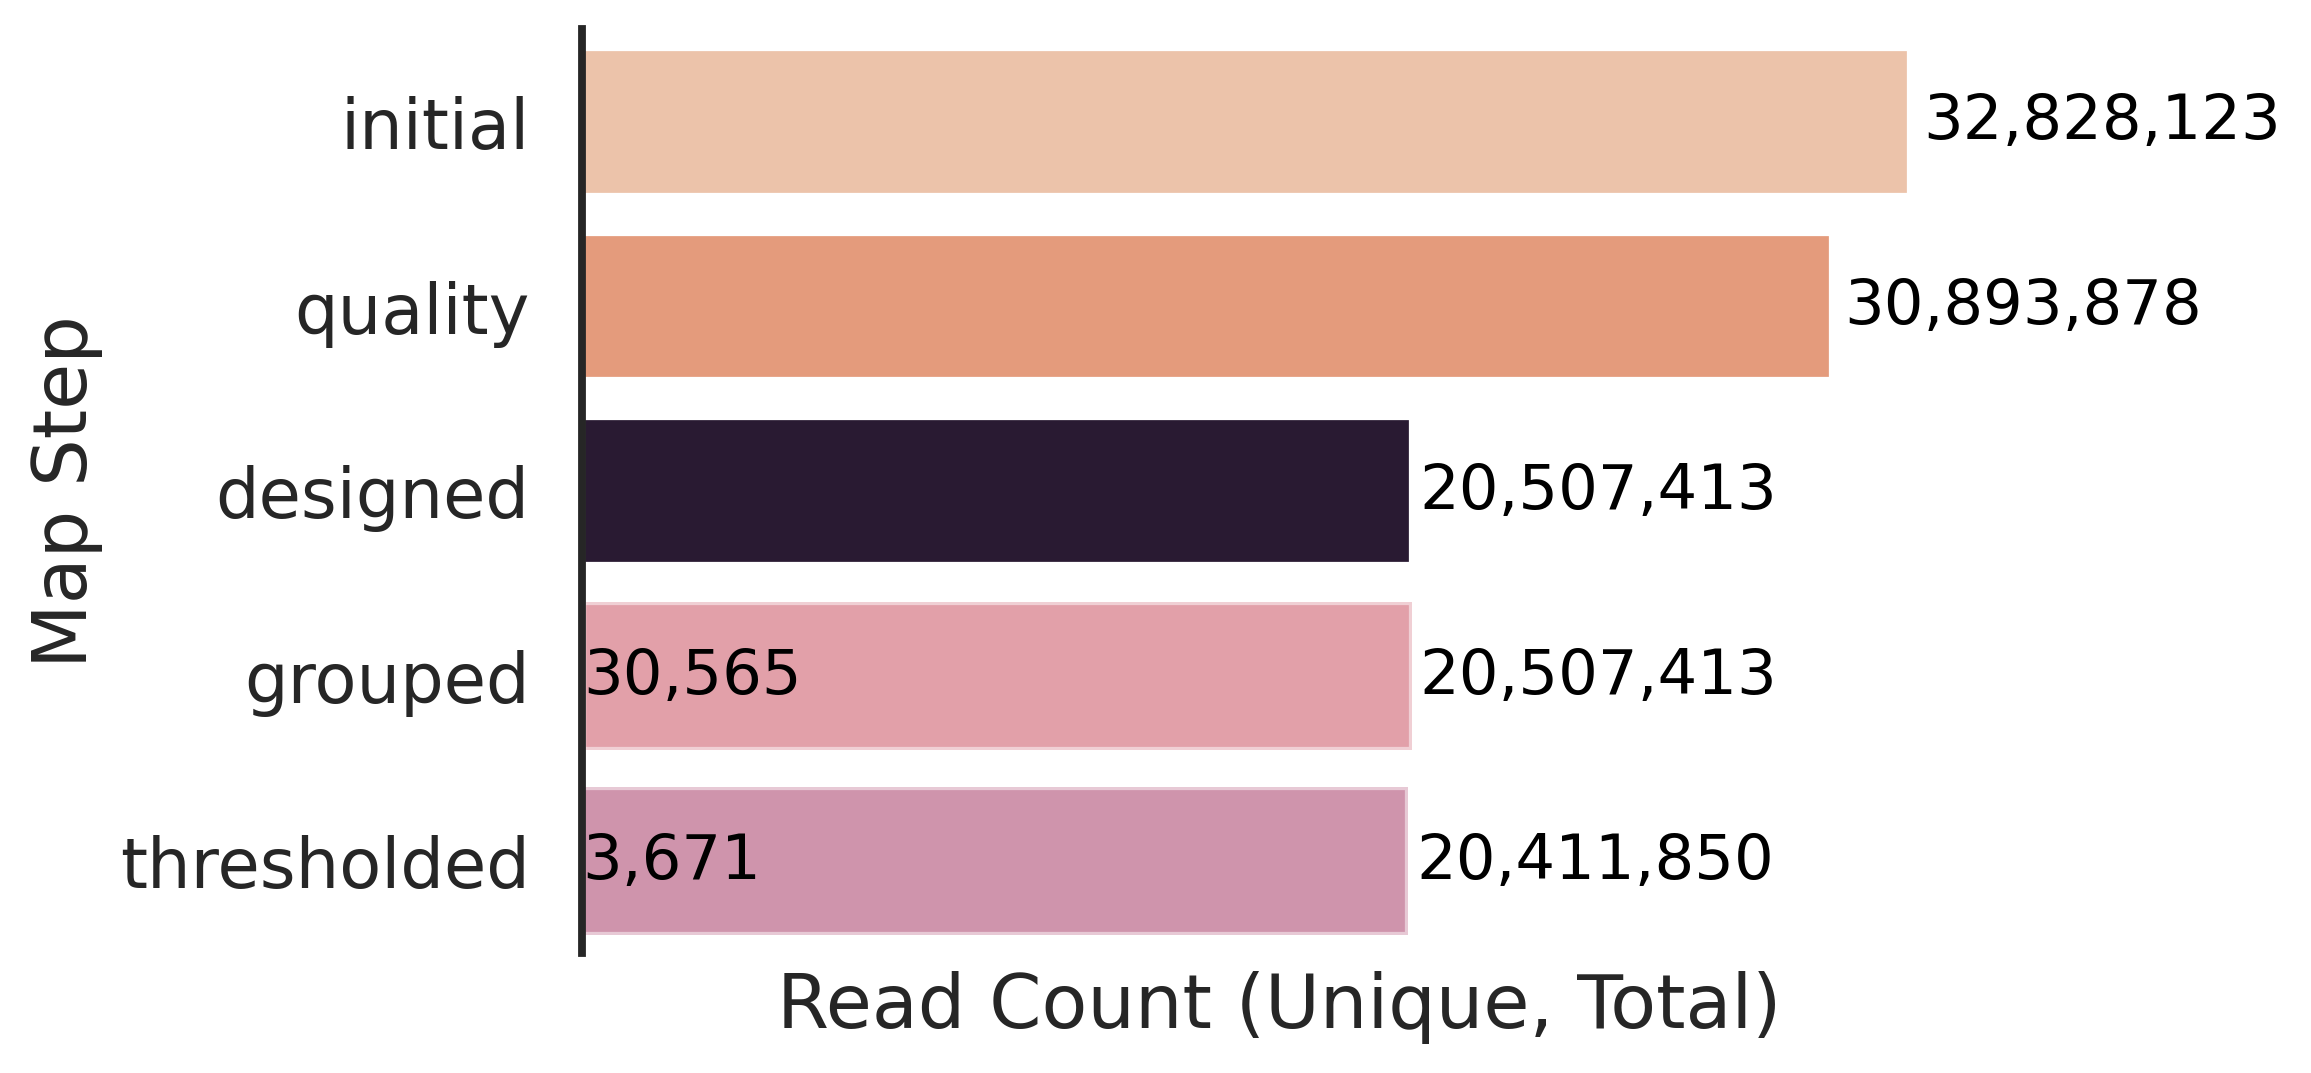

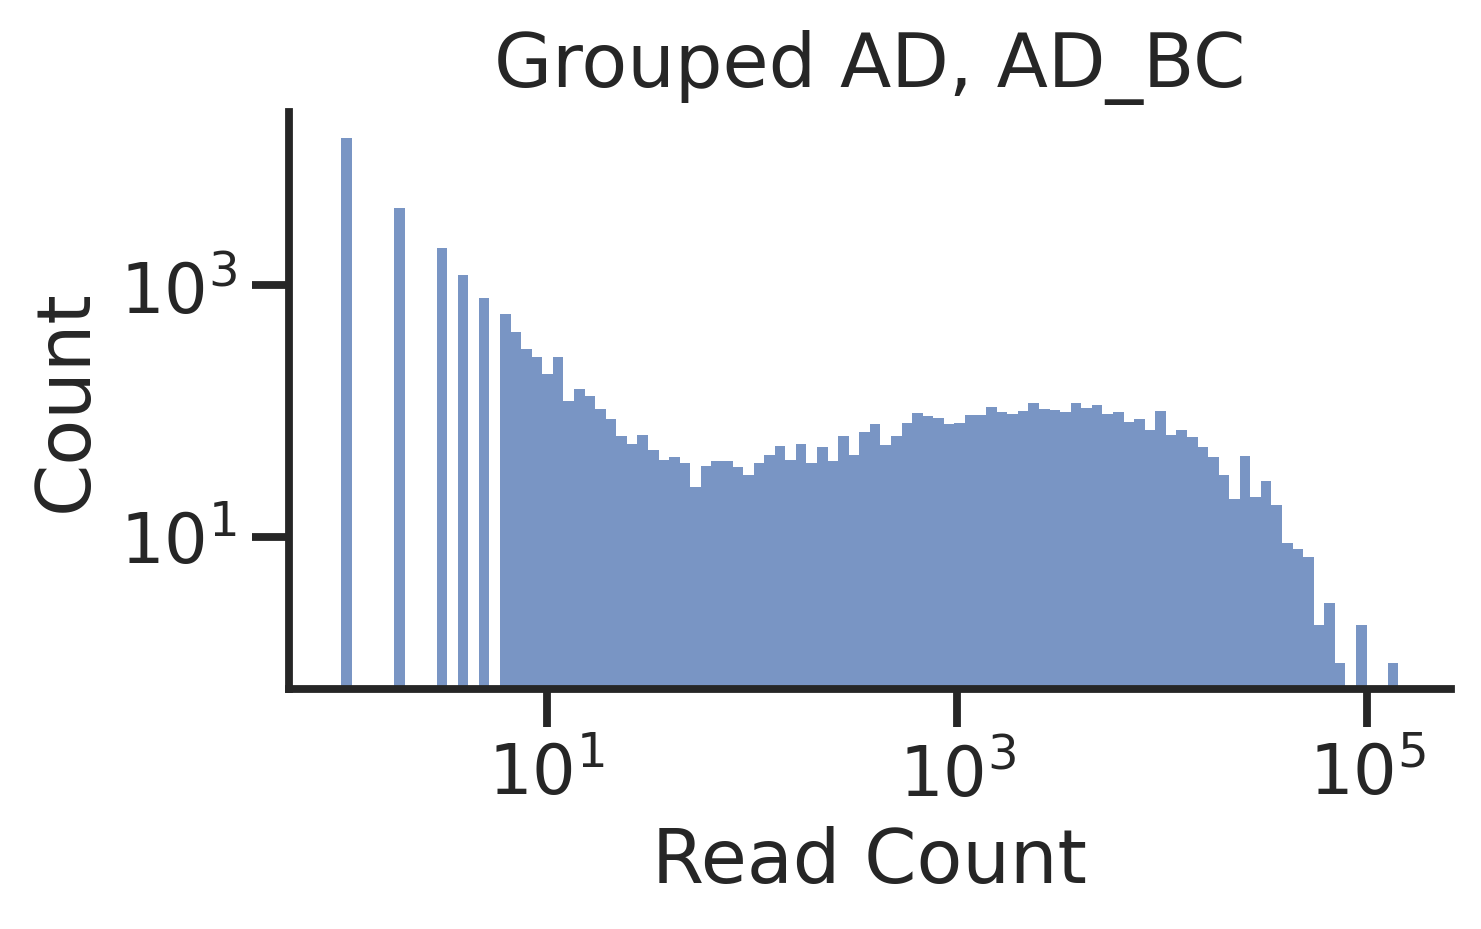

Done in 2.31 seconds.

Thresholding...
Using reads threshold of 100.


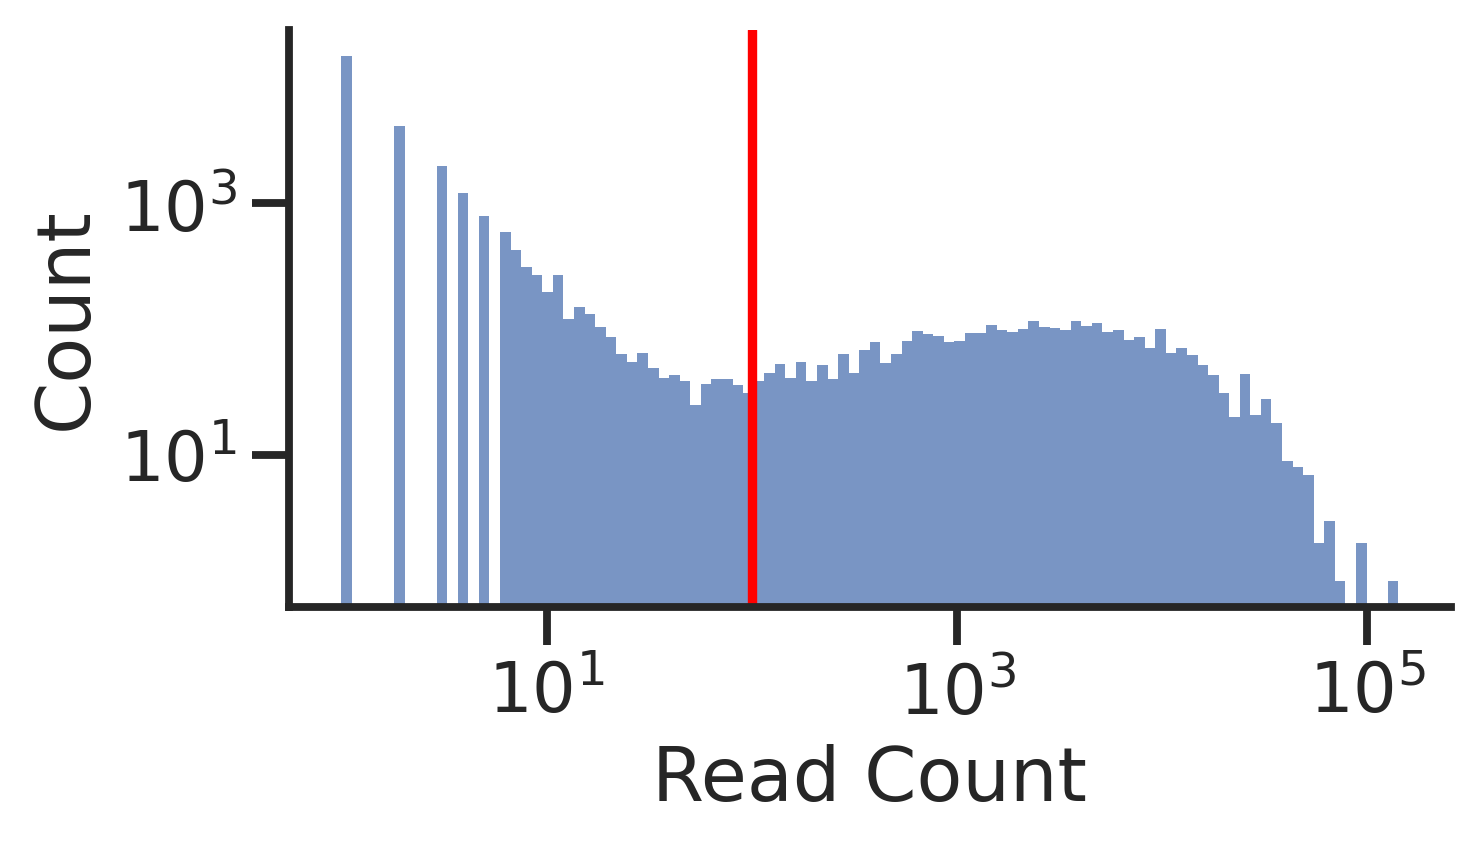

Done in 0.34 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_B_AD_4_5_S57_AD_AD_BC_loss_summary'
Done in 0.68 seconds.

AD_3_10_S52
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B/trebl_experiment_yeast_pool_B_AD_3_10_S52
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.23 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 21.63 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 17.55 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 10.47 seconds.

Mapping complete.
trebl_experiment_yeast_pool_B_AD_3_10_S52_AD_AD_BC_initial
Total rows: 29255991


AD  AD_qual        AD_BC  \
0  TCTGGTTCTGGTTCTGGTTCTGGTAAGAAGAAACCATCTTCTGGTT...     True  TATTAATAATG   
1  TTTATTGGTGATAATCAAGATTTGGATCAAGCTTTGGCTGGTGATC...     True  ATCCACACGCC   
2  ATTAATGGTGCTCCAGCTTCTACTTCTACTCAAACTATTTCTCCTA...     True  GAAGATTTTGC   
3  TCTACTGTTTCTGAATGTCCAAGAAGGAAATCTTCTGGTTCTCCAG...     True  TCCAAATCGTC   
4  TCTGCTATTACTAATTTGACTTCTCCATCTATGTATGGTGAATCTC...     True  ATTTCCCCGAT   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_AD_3_10_S52_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_AD_3_10_S52_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_3_10_S52_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 27.71 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_3_10_S52_AD_AD_BC_designed — kept only Designed == 1.
Done in 16.37 seconds.

Grouping trebl_experiment_yeast_pool_B_AD_3_10_S52_AD_AD_BC_designed...


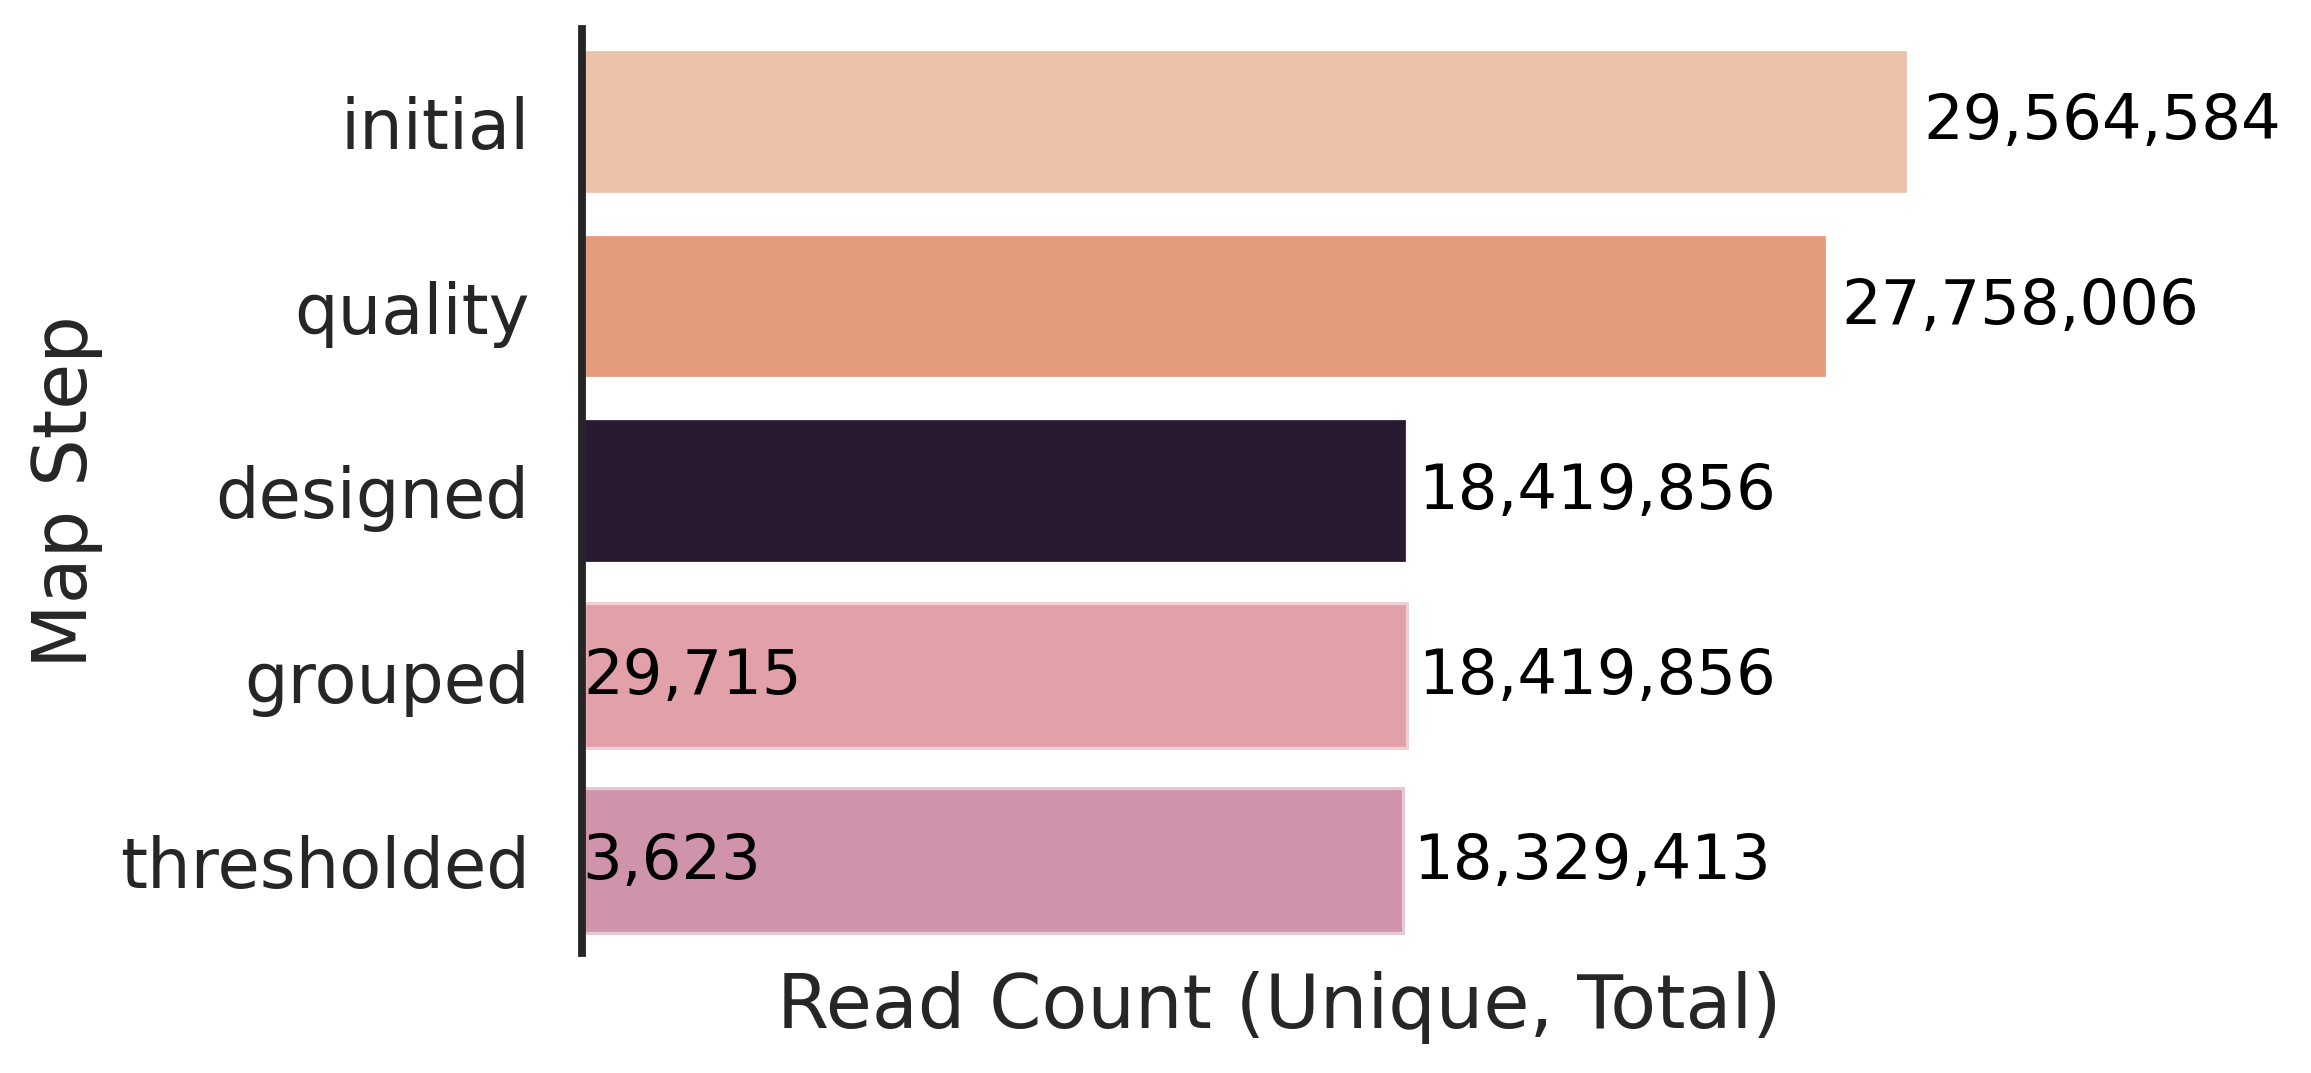

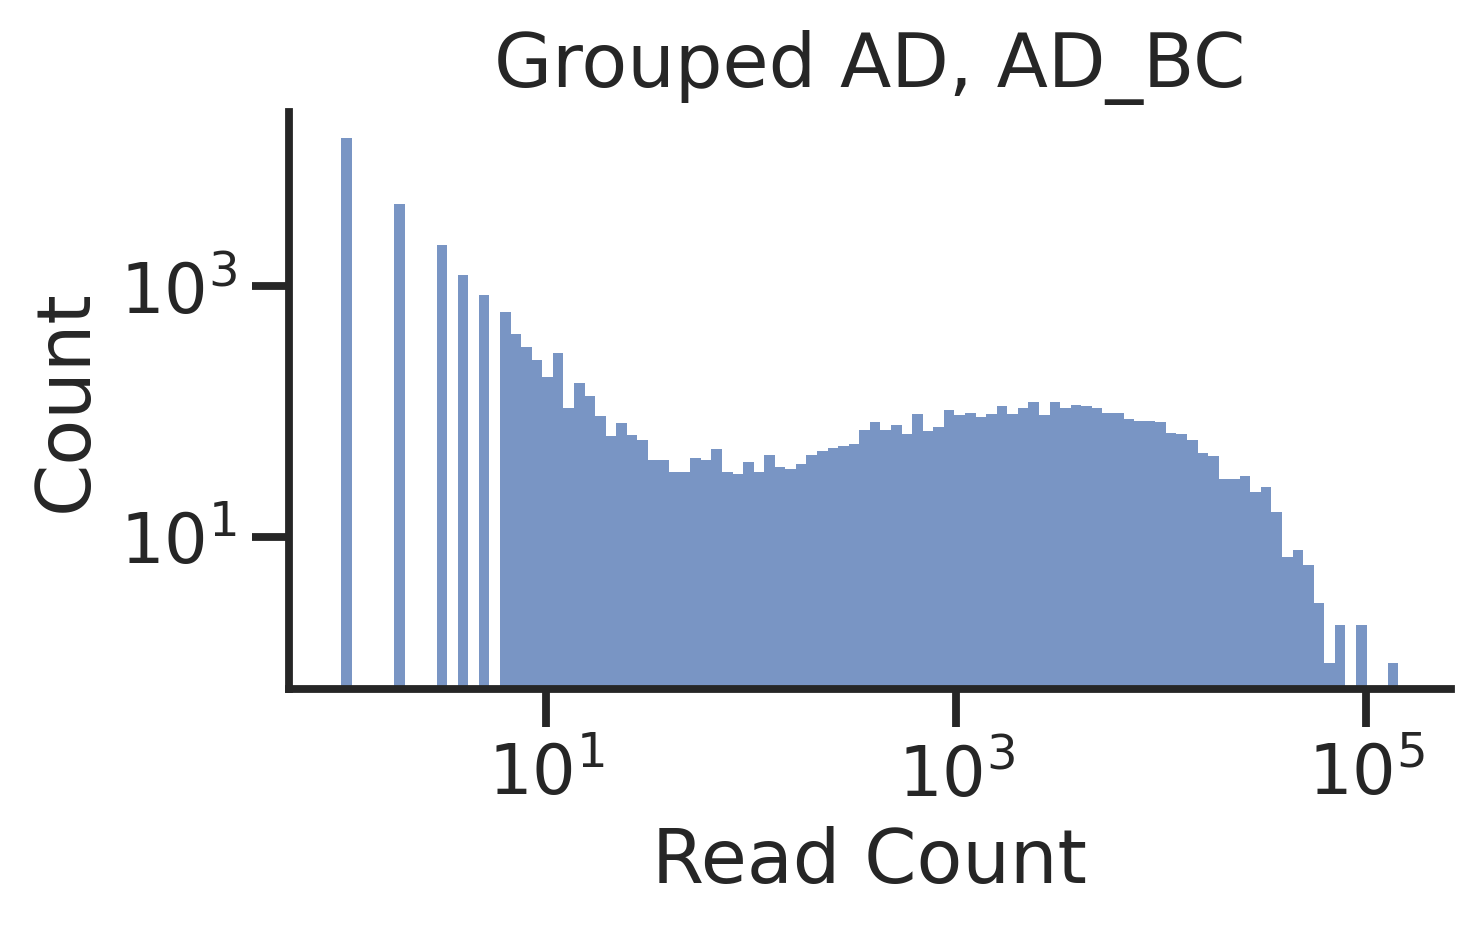

Done in 0.90 seconds.

Thresholding...
Using reads threshold of 100.


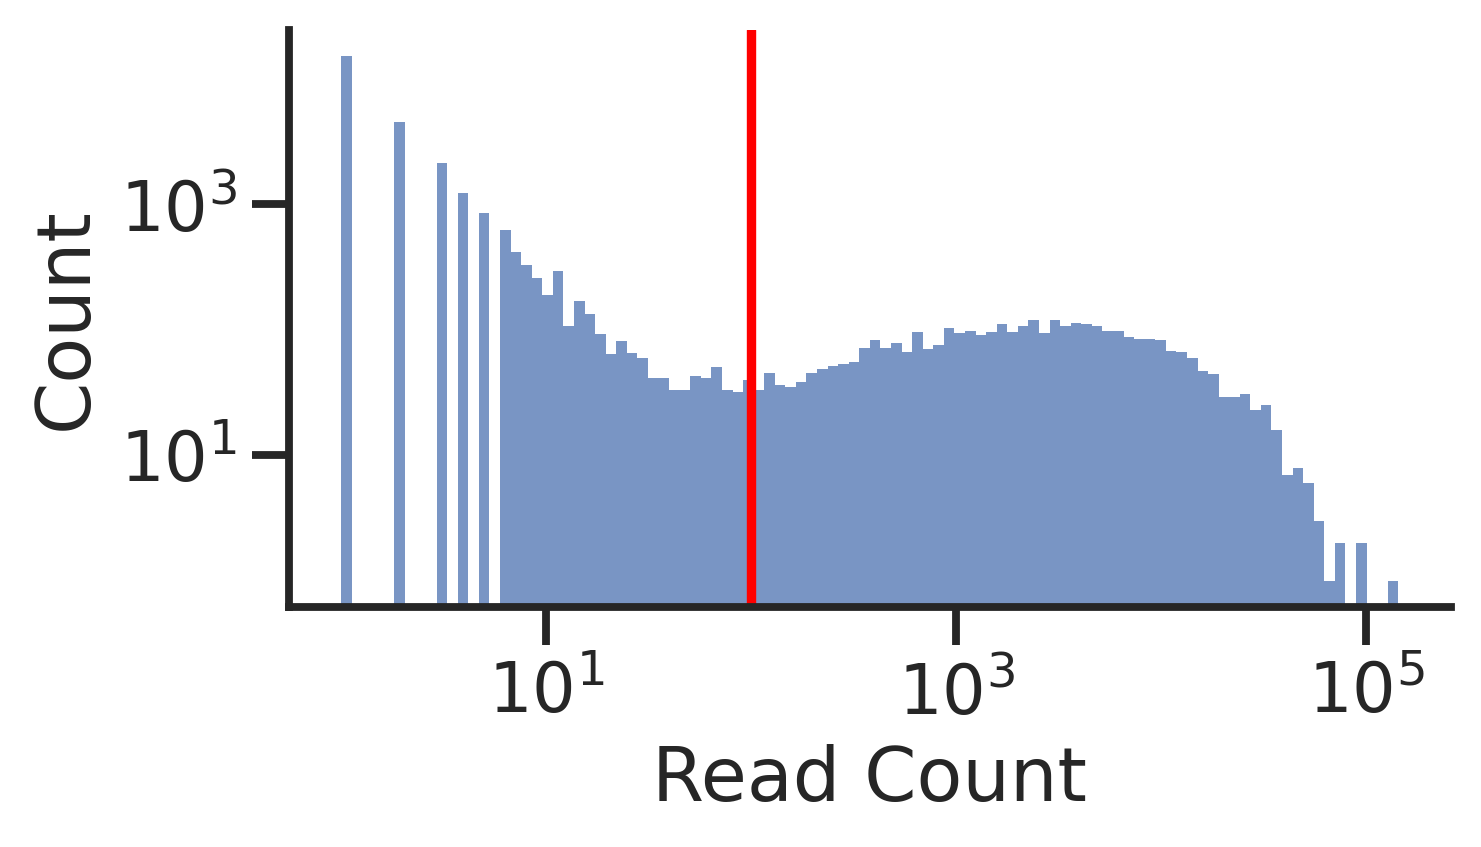

Done in 0.34 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_B_AD_3_10_S52_AD_AD_BC_loss_summary'
Done in 0.50 seconds.

AD_3_15_S53
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B/trebl_experiment_yeast_pool_B_AD_3_15_S53
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.37 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 25.65 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 19.22 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 11.88 seconds.

Mapping complete.
trebl_experiment_yeast_pool_B_AD_3_15_S53_AD_AD_BC_initial
Total rows: 32304698


AD  AD_qual        AD_BC  \
0  CCAGTTACTACTGATGATGTTTCTTTGGCTGATAAAGCTATTGAAT...     True  GGCGTCGAGCT   
1  GCTCCACCATCTGCATTCTTGTTGCCAACTTATACTAGAGGTTCTC...     True  CCTCAACGTAC   
2  TCTCCACAAACTCAATCTTTGGATTCTAGACCACCACCAACTCCAA...     True  GCCACCCATCC   
3  GCTGCTATGTTGCATAATGTCTTGTTTGTTTGGATGTCTGATAGAG...     True  CATGCGATTCG   
4  GCTGCTATGTTGCATAATGTCTTGTTTGTTTGGATGTCTGATAGAG...     True  CATGCGATTCG   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_AD_3_15_S53_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_AD_3_15_S53_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_3_15_S53_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 25.10 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_3_15_S53_AD_AD_BC_designed — kept only Designed == 1.
Done in 17.13 seconds.

Grouping trebl_experiment_yeast_pool_B_AD_3_15_S53_AD_AD_BC_designed...


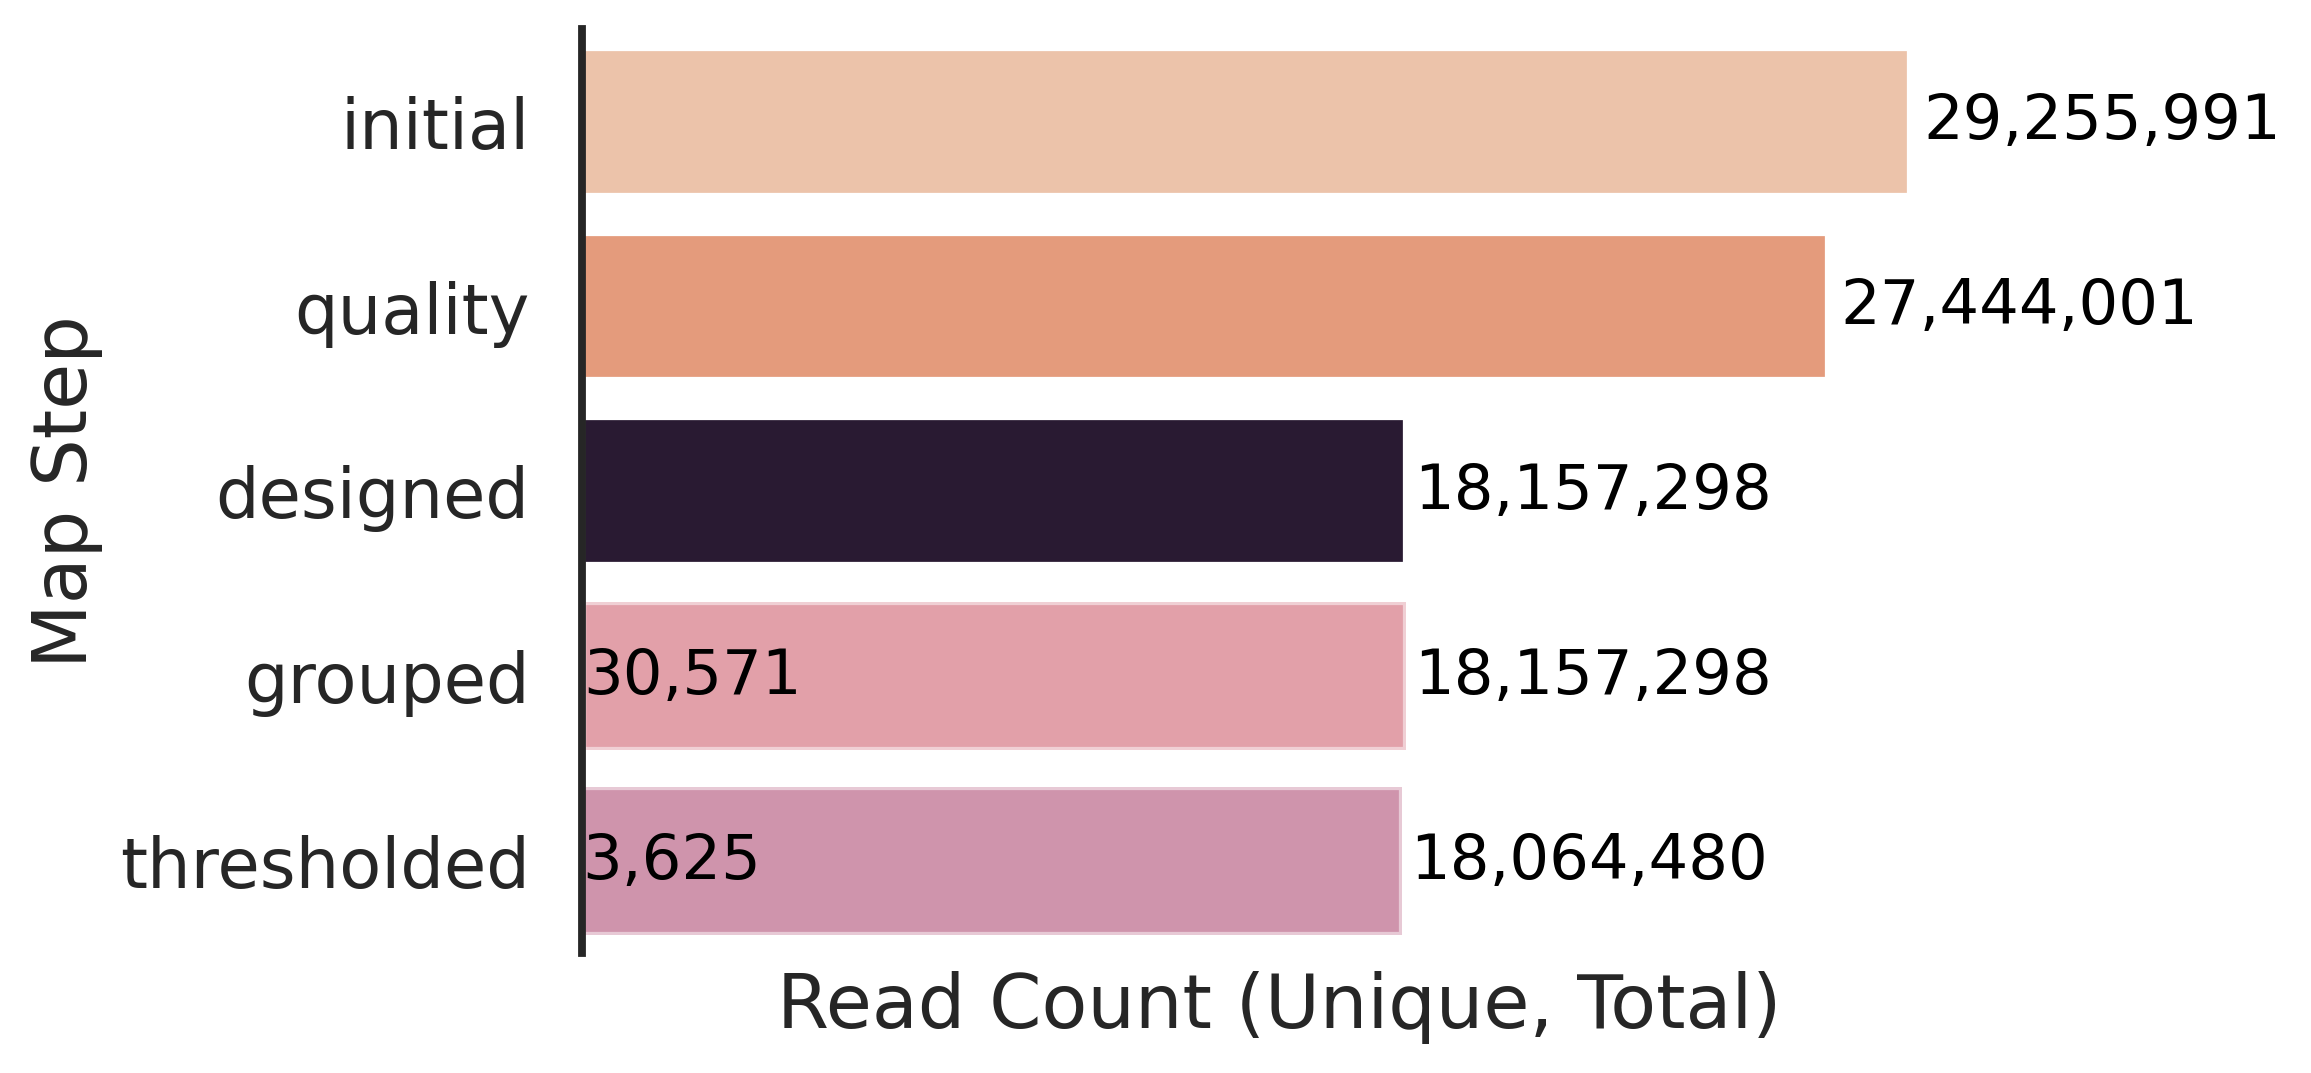

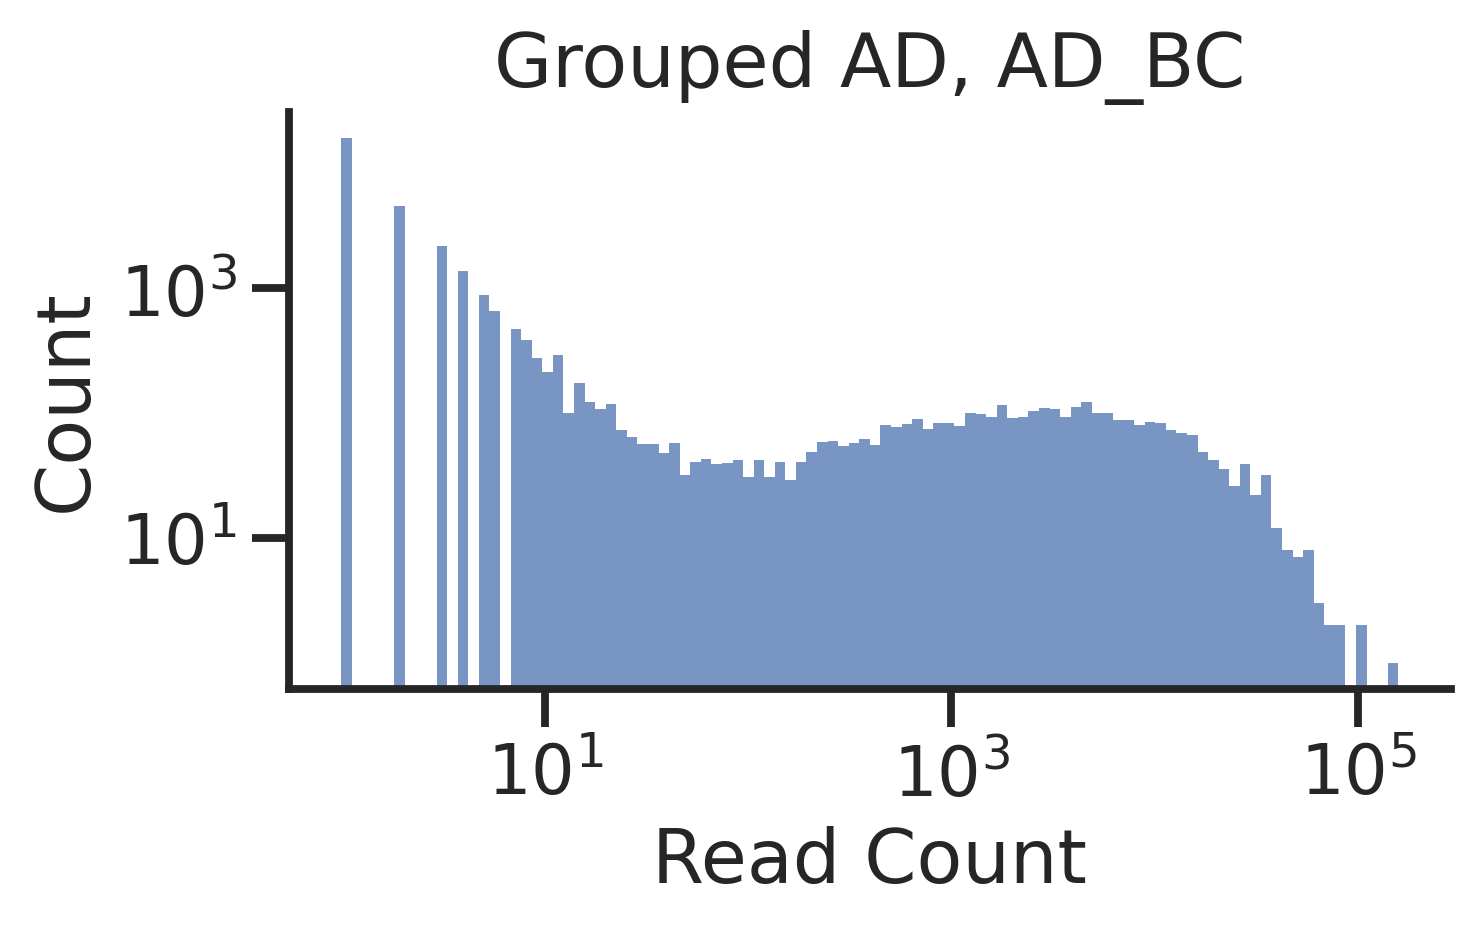

Done in 0.76 seconds.

Thresholding...
Using reads threshold of 100.


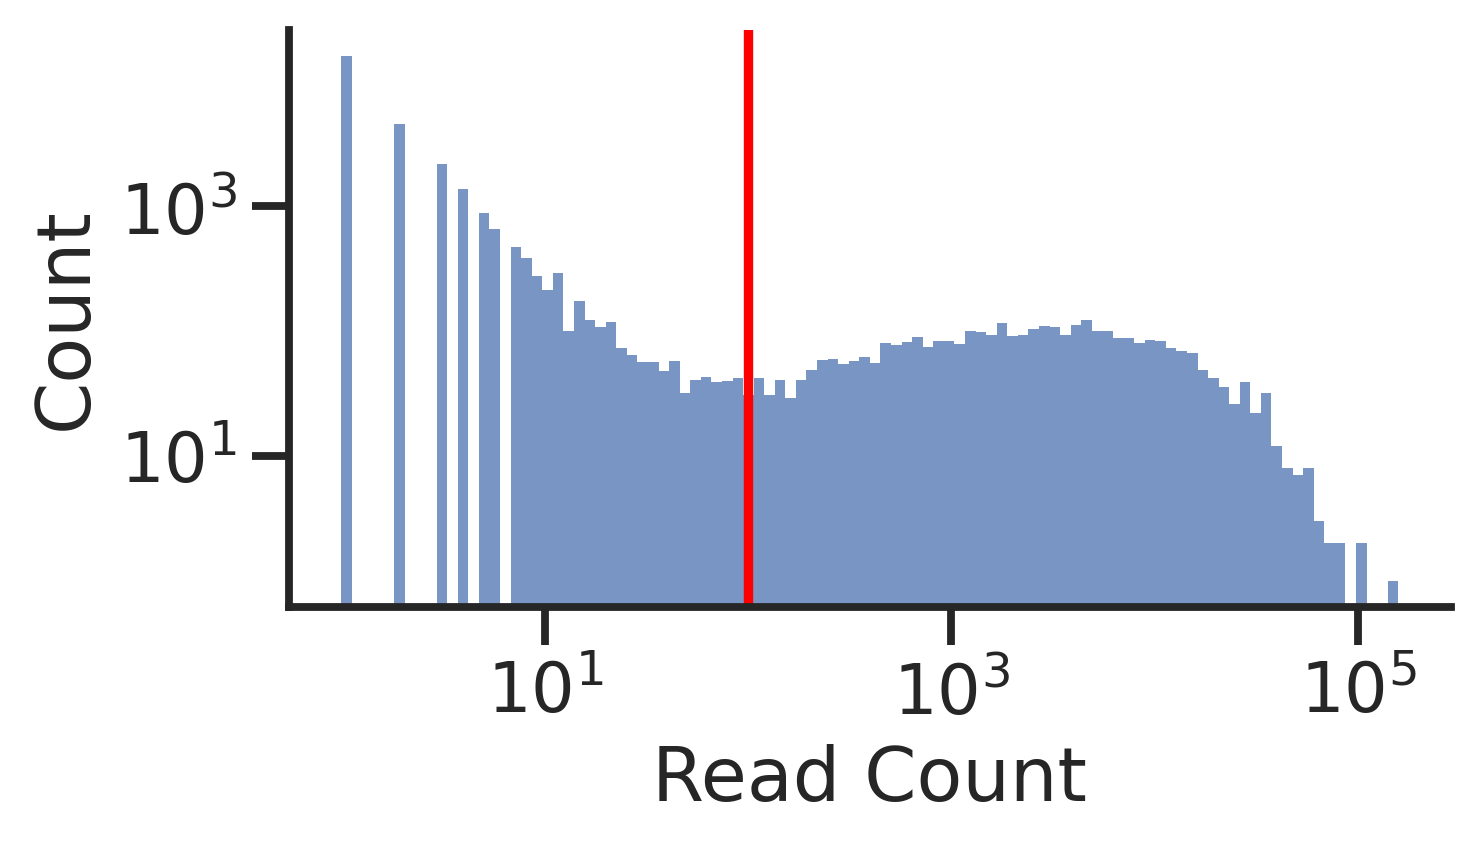

Done in 0.33 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_B_AD_3_15_S53_AD_AD_BC_loss_summary'
Done in 0.60 seconds.

AD_2_10_S46
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B/trebl_experiment_yeast_pool_B_AD_2_10_S46
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.33 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 22.42 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 19.30 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 11.08 seconds.

Mapping complete.
trebl_experiment_yeast_pool_B_AD_2_10_S46_AD_AD_BC_initial
Total rows: 31445219


AD  AD_qual        AD_BC  \
0  TCTACTACTGGATTTCAACAACCAGTTTCTAGACAAAGACCACCAG...     True  GATGGTGCTAC   
1  GAATCTTCTTCTGATTCTACTCCATTGTTGGGTTTGGATGGTGTTG...     True  AACCACCGCAT   
2  GTTTCTAATTTGGGTTGTGATGATTTGTCTGACTTCTGTAATTTGT...     True  AAATCACGTTG   
3  GGTACTTCTTATAGAGCTTGGACTAGAGGTATTGGTGGTACTAGAG...     True  TCAATTTCAAC   
4  TCTACTGCATTTACTAATTTGACTTCTCCATCTACTTATAATGAAT...     True  CTTATTCATCC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_AD_2_10_S46_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_AD_2_10_S46_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_2_10_S46_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 30.50 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_2_10_S46_AD_AD_BC_designed — kept only Designed == 1.
Done in 17.53 seconds.

Grouping trebl_experiment_yeast_pool_B_AD_2_10_S46_AD_AD_BC_designed...


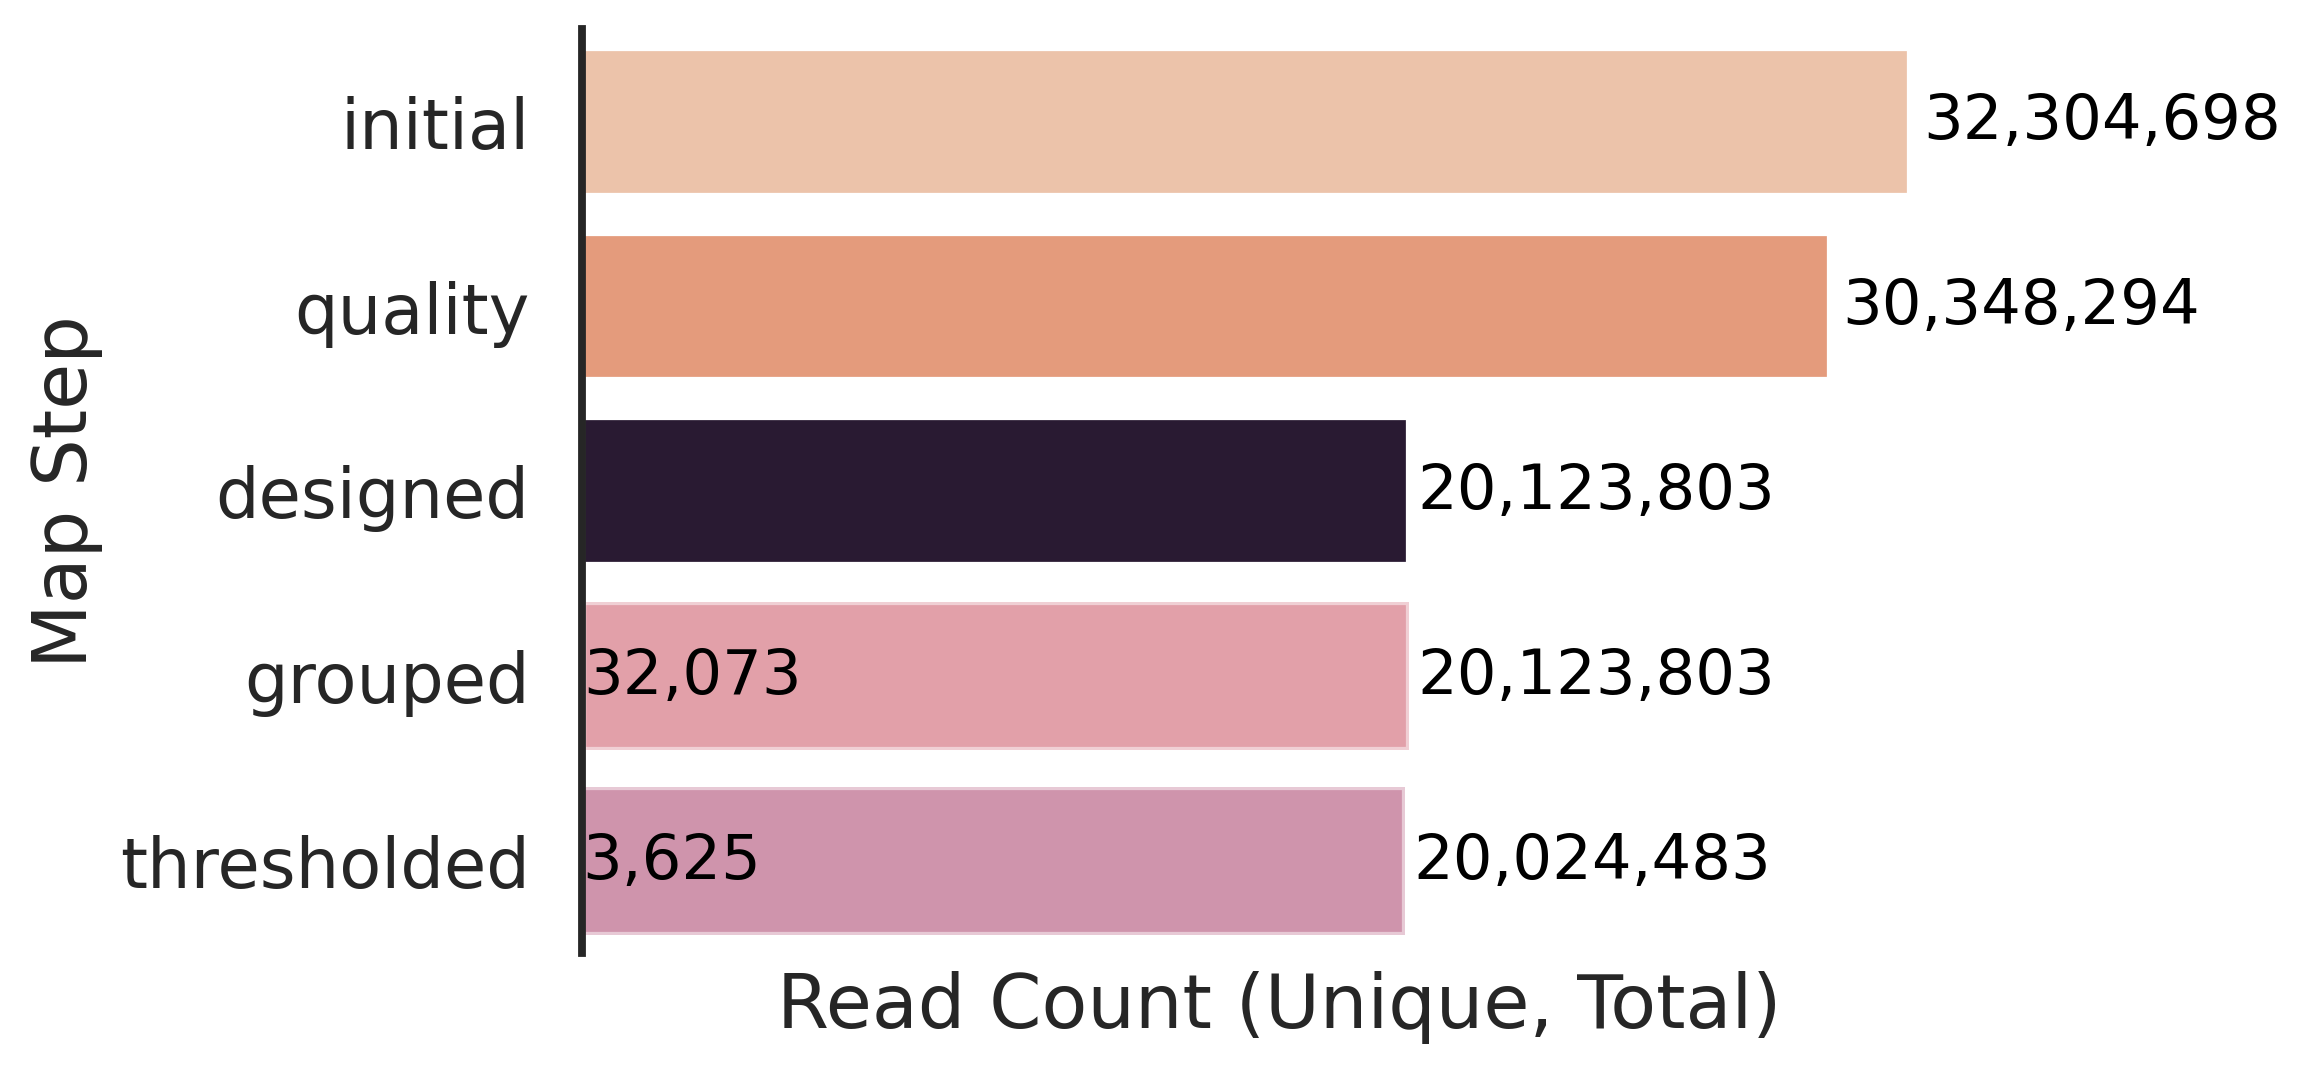

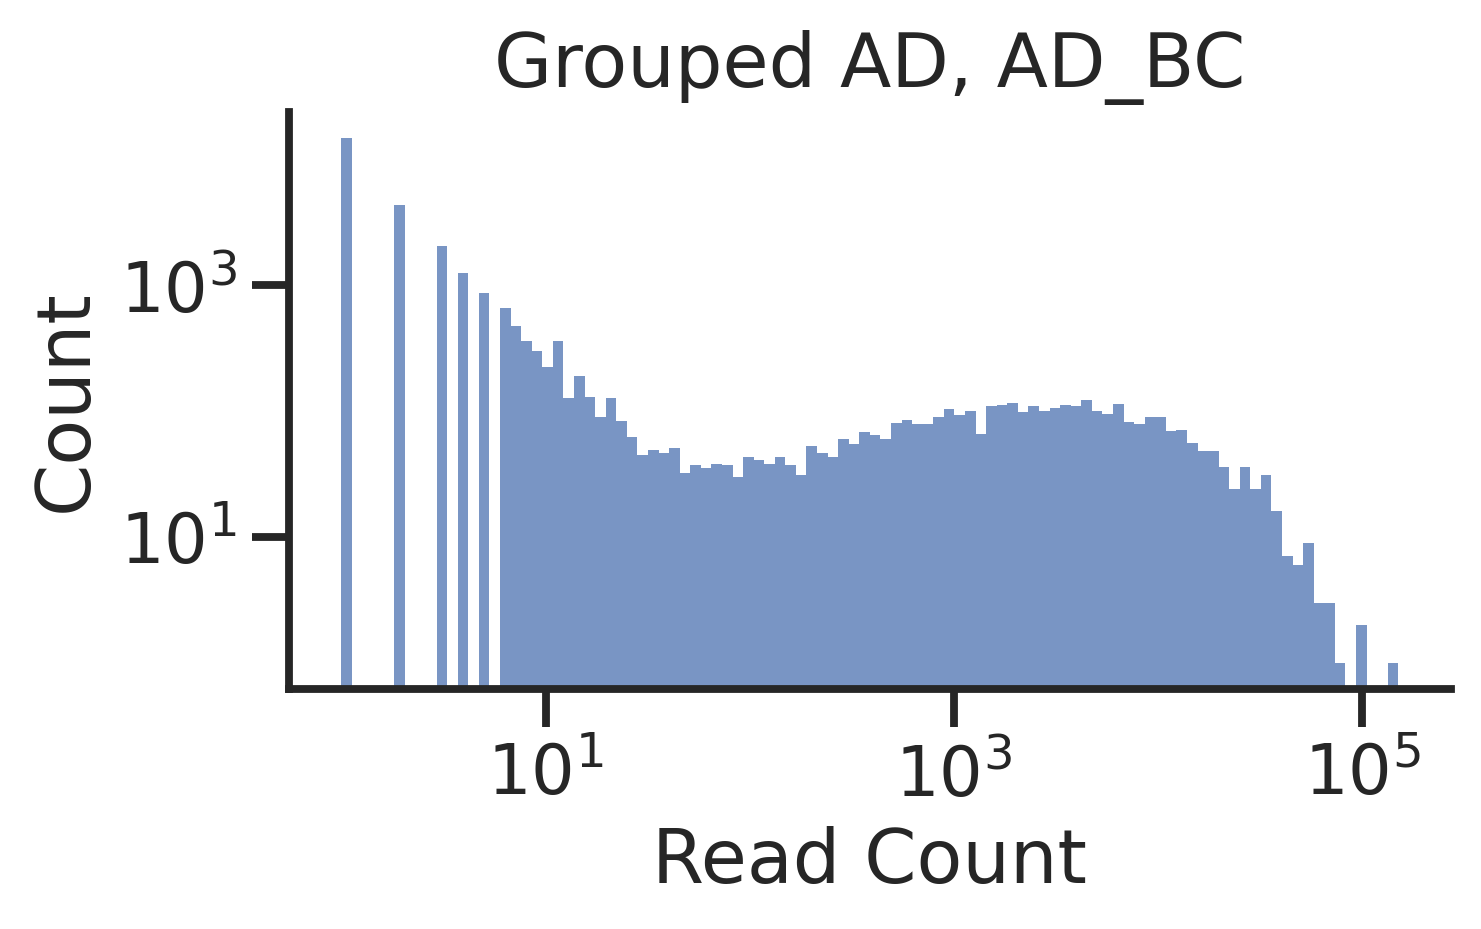

Done in 0.88 seconds.

Thresholding...
Using reads threshold of 100.


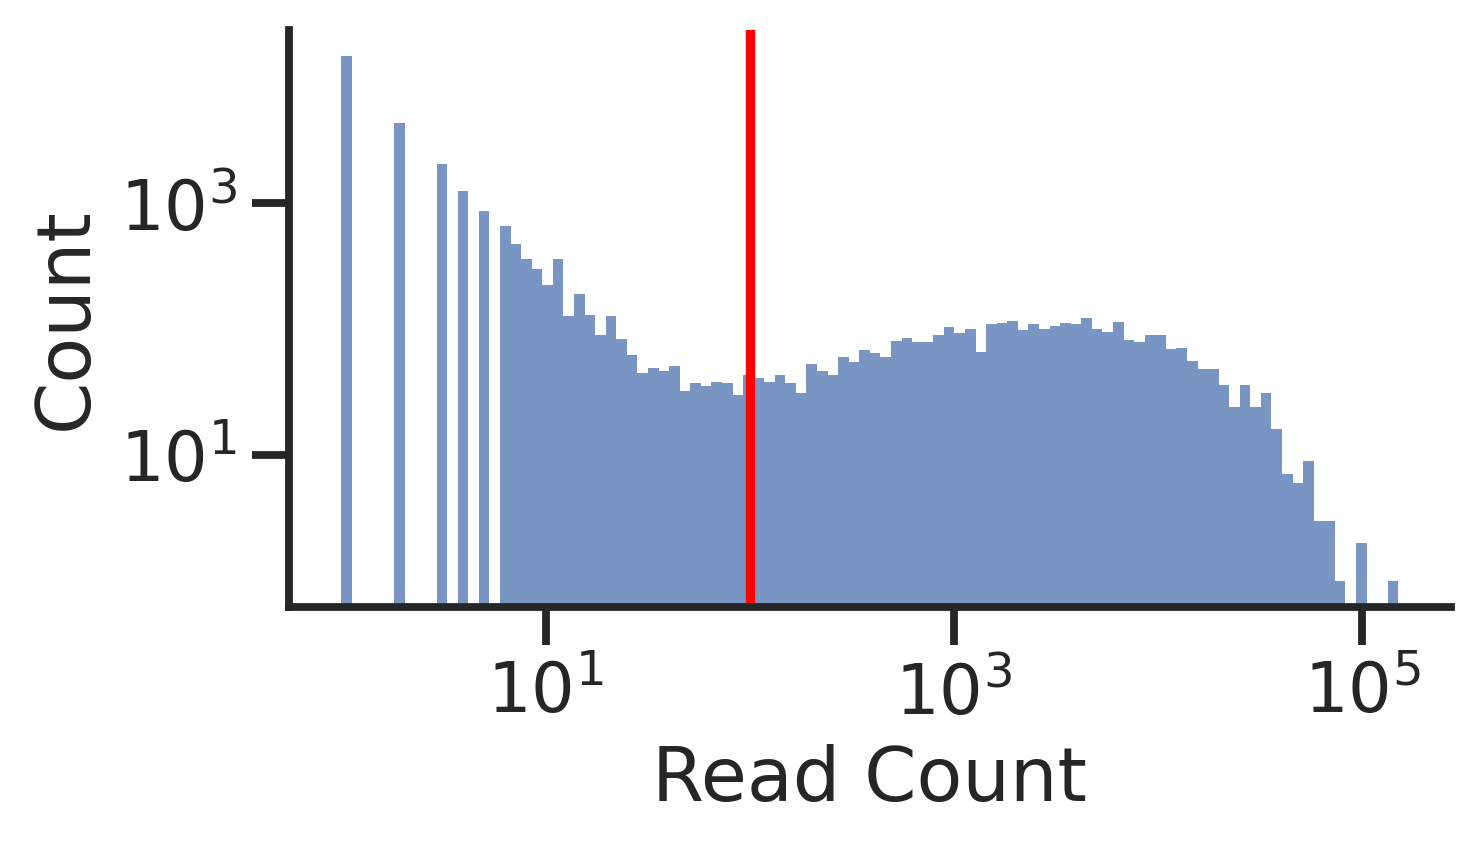

Done in 0.33 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_B_AD_2_10_S46_AD_AD_BC_loss_summary'
Done in 0.63 seconds.

AD_2_15_S47
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B/trebl_experiment_yeast_pool_B_AD_2_15_S47
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.44 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 24.85 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 20.89 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 11.48 seconds.

Mapping complete.
trebl_experiment_yeast_pool_B_AD_2_15_S47_AD_AD_BC_initial
Total rows: 34596190


AD  AD_qual        AD_BC  \
0  GTTAAATCATTTACTACTGATTCTAATCAATCTACTTGGTTGTCTC...     True  AGACGTGTATG   
1  TTTACTACTGATTCTCCACCACCATGGTTGCCATCTTCTTCTTCTT...     True  TGTAGCCGTTA   
2  TTTACTACTGATTCTCCACCACCATGGTTGCCATCTTCTTCTTCTT...     True  TGTAGCCGTTA   
3  TTTGCTCCATCTATGGCTAGAACTACTTCTGCTTCTTCTGCTTCTC...     True  AGCATTTCCCG   
4  TTTAGAGATCCATTGGCTTCTGCTCCACCATCTGCTGCATTTACTA...     True  CCTTACCACTT   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_AD_2_15_S47_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_AD_2_15_S47_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_2_15_S47_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 31.56 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_B_AD_2_15_S47_AD_AD_BC_designed — kept only Designed == 1.
Done in 11.49 seconds.

Grouping trebl_experiment_yeast_pool_B_AD_2_15_S47_AD_AD_BC_designed...


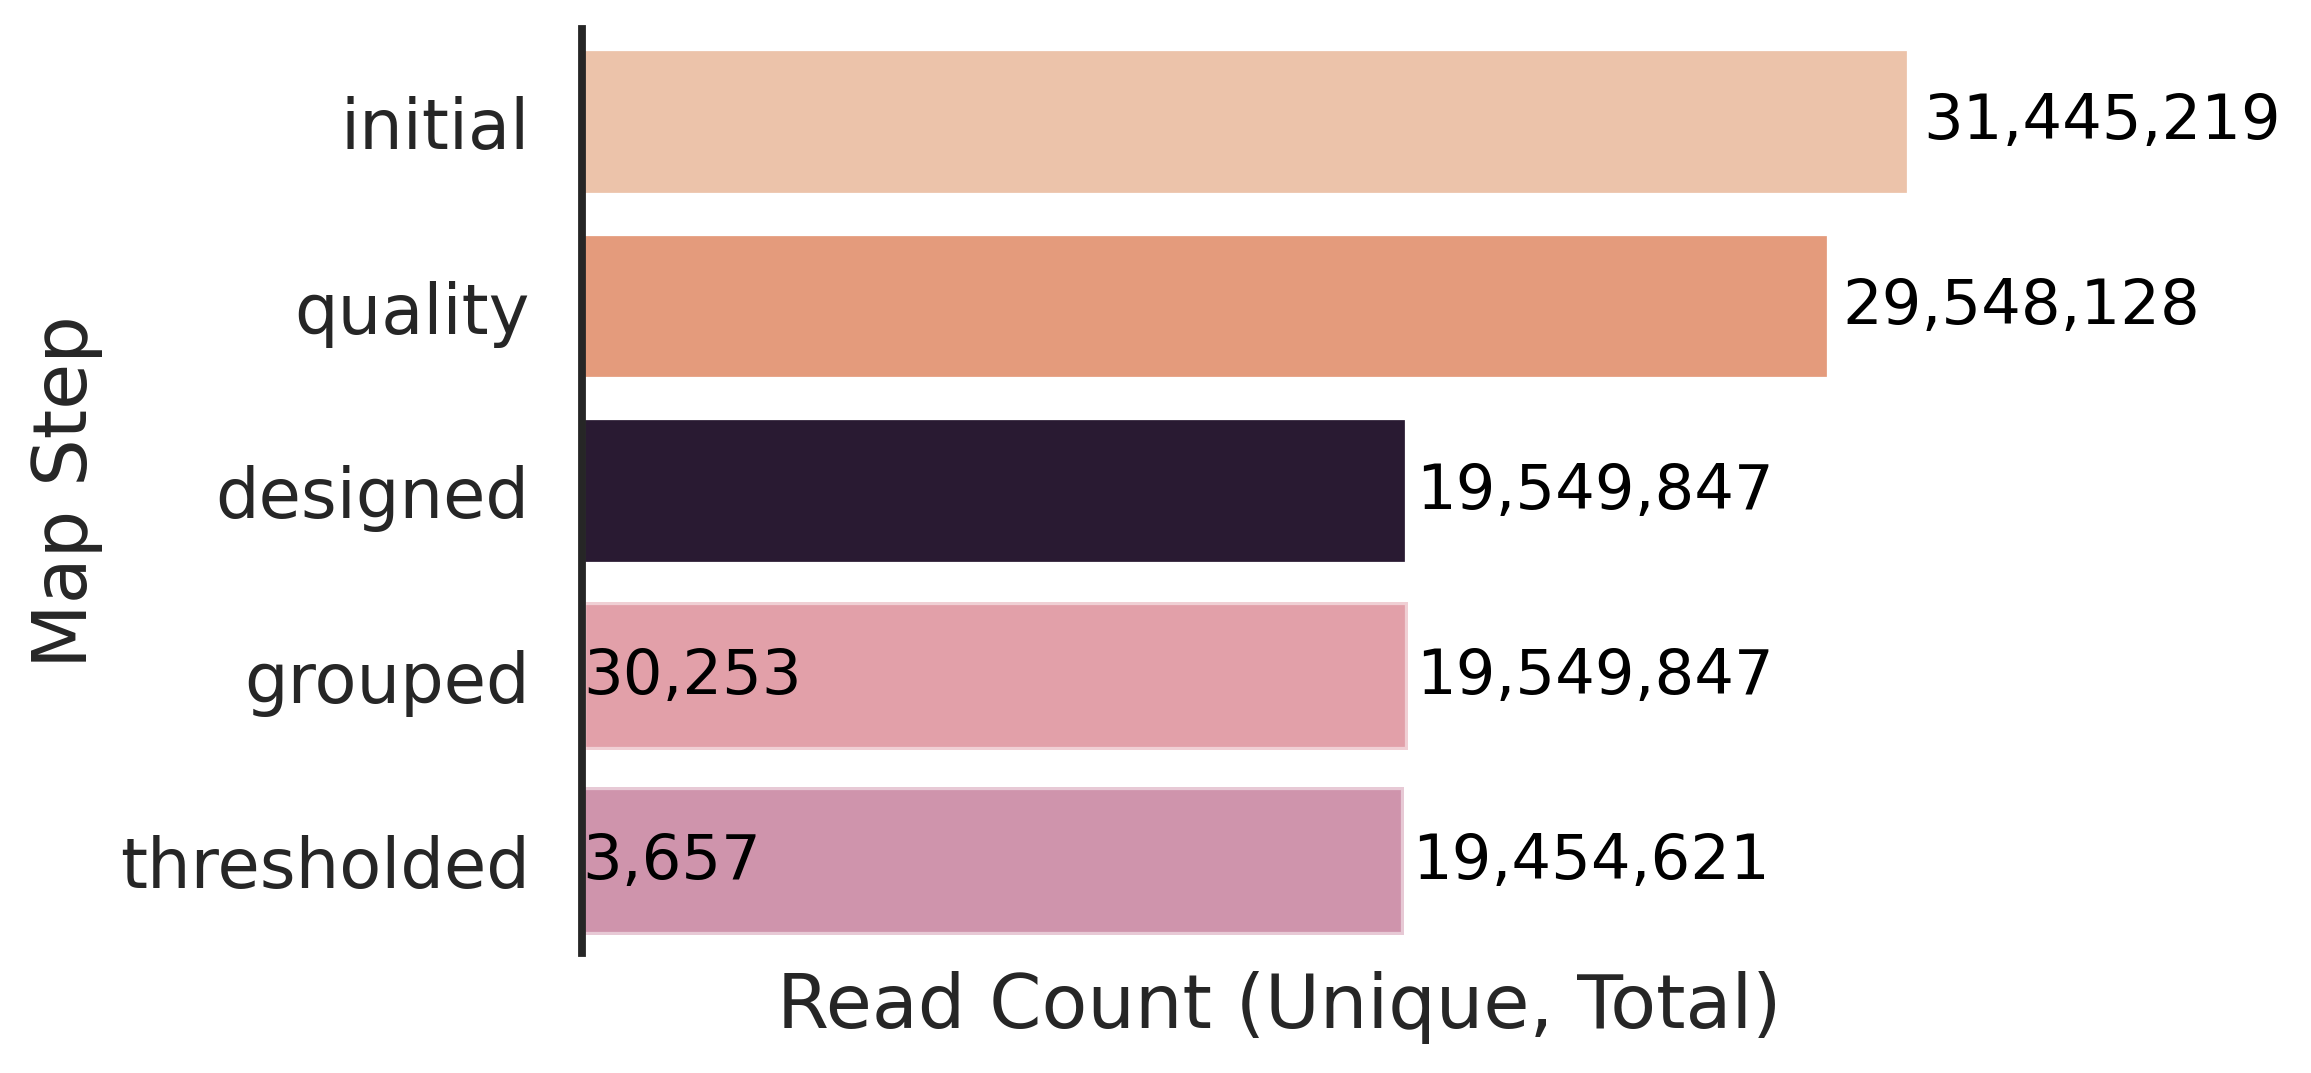

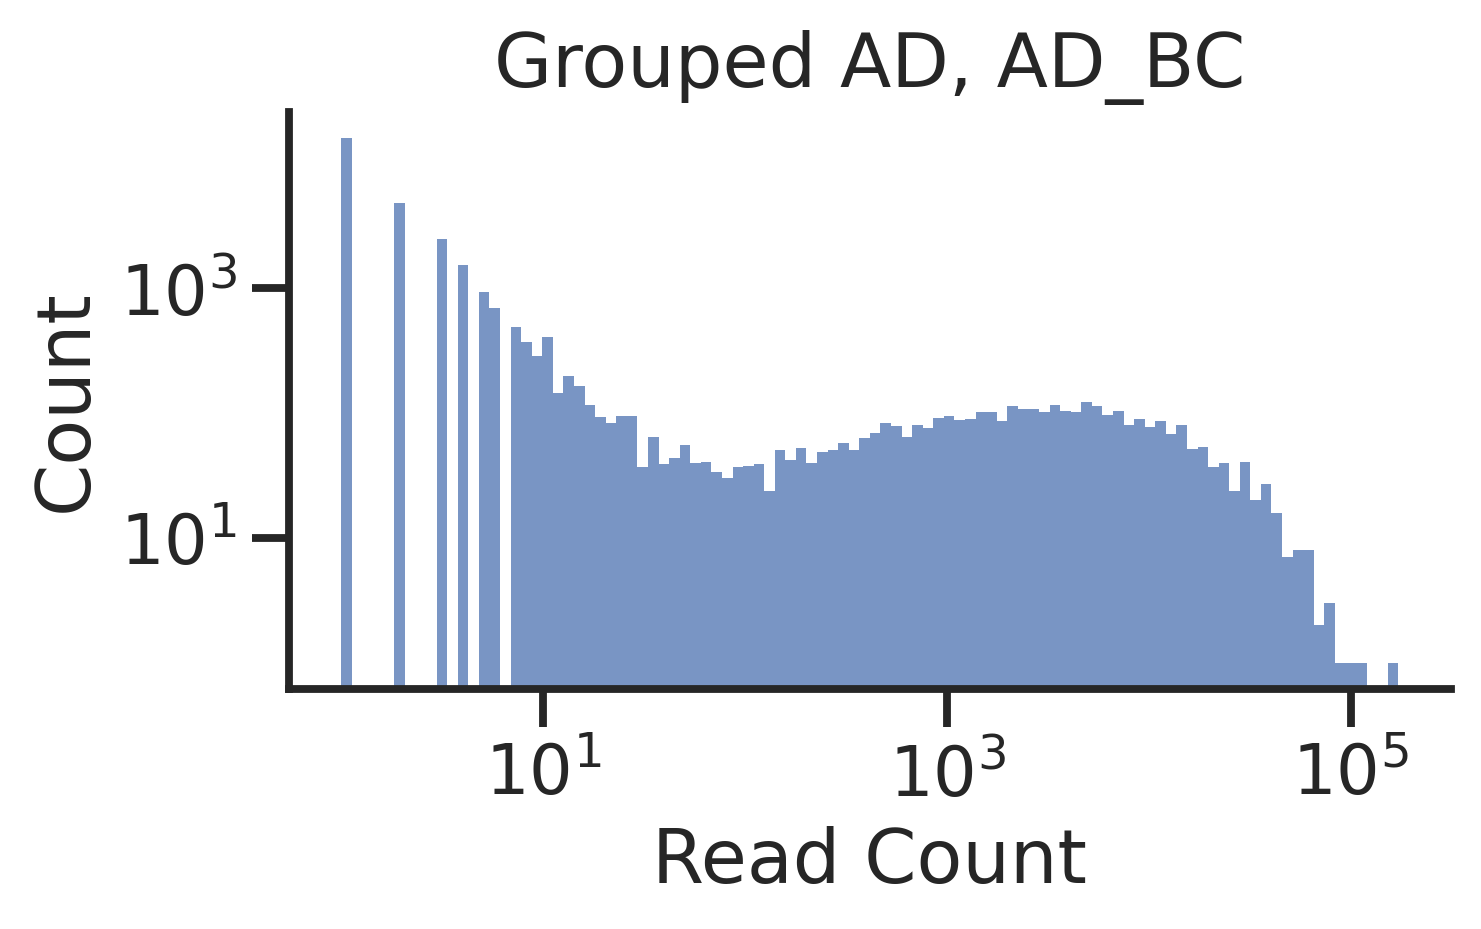

Done in 0.88 seconds.

Thresholding...
Using reads threshold of 100.


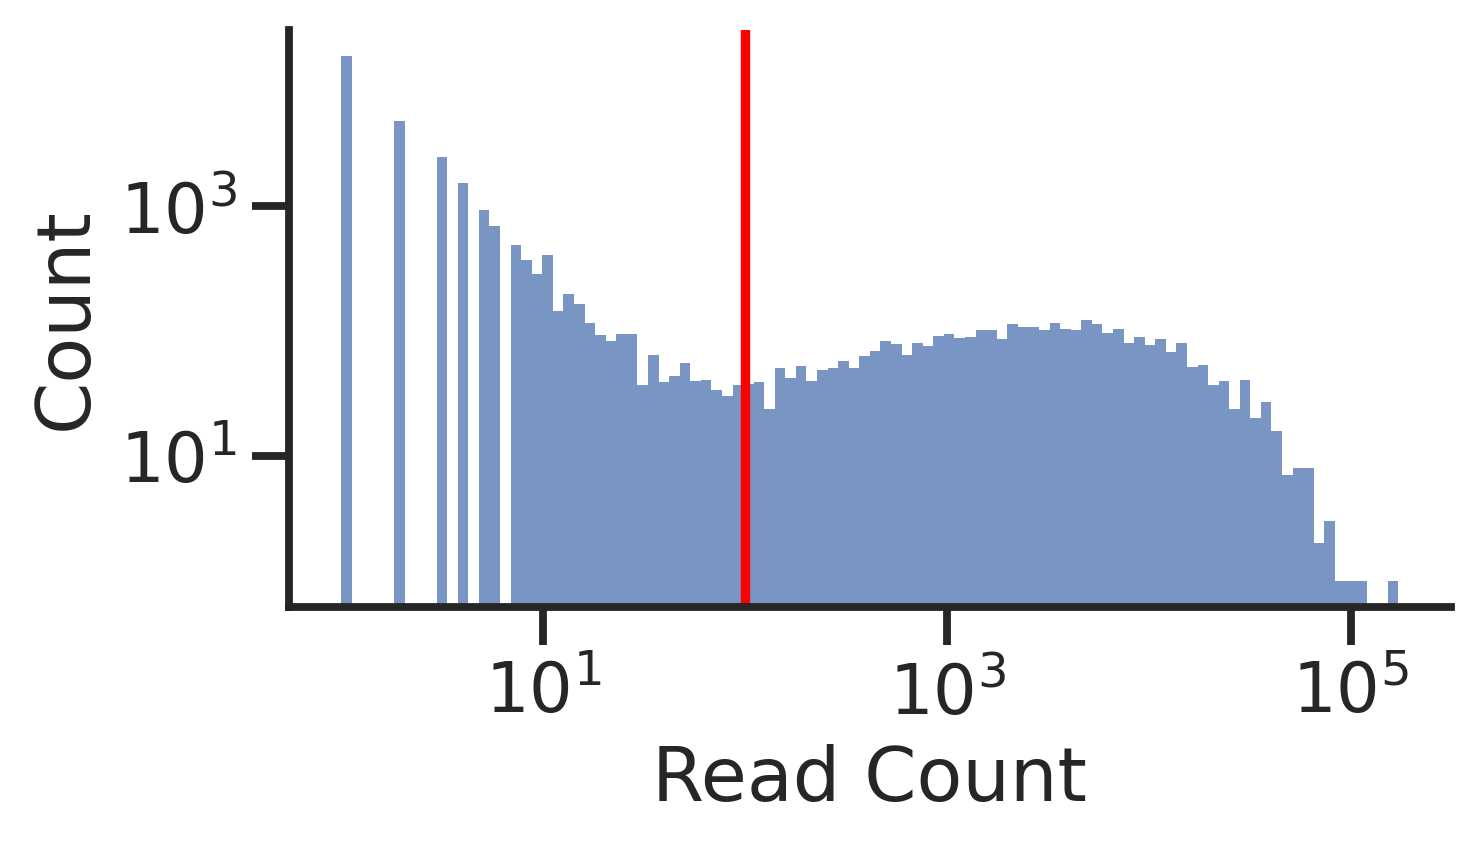

Done in 0.34 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_B_AD_2_15_S47_AD_AD_BC_loss_summary'
Done in 0.61 seconds.

AD_3_0_S50
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B/trebl_experiment_yeast_pool_B_AD_3_0_S50
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
AD_objects = [EC_AD, EC_AD_BC]

complex_AD_results = []
simple_AD_results = []

for file_path in yeast_pool_B_AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # Get the file naeme to use for output
    file_output_path = os.path.join(yeast_pool_B_output_path, f"trebl_experiment_yeast_pool_B_{name_only}")
    print(file_output_path)

    # Extract UMIs and barcodes from reads
    bc_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_B_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                       bc_objects = AD_objects,
                                       reverse_complement = True)
    bc_mapper.create_map()
    display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        map_order = ['quality', 'designed', 'grouped', 'thresholded'],
                                        step_name=f"trebl_experiment_yeast_pool_B_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = True, reads_threshold = 100)
    refiner.refine_map_from_db()
    refiner.plot_loss()
    

In [ ]:
tables = refiner.show_tables()

yeast_pool_B_AD_result_tables = []

for table in tables:
    if "trebl" in table[0] and "thresholded" in table[0]:
        print(table[0])
        df = refiner.get_map_df(table[0])
        df["sample"] = table[0][38:]
        yeast_pool_B_AD_result_tables.append(df)

yeast_pool_B_AD_result_df = pd.concat(yeast_pool_B_AD_result_tables)
yeast_pool_B_AD_result_df